In [1]:
import sys
import os
from timeit import default_timer as timer
import requests
from IPython.display import display, Image, Markdown, Audio
import matplotlib.pyplot as plt
import time
from abc import ABC, abstractmethod
from together import Together
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext dotenv
%dotenv

### NOTE:
- This notebook includes class implementations for the providers **Together AI**, **Cloudflare**, and a **Benchmarking** class for running experiments.
- **Potential improvements:**
    1. **Model Name Mapping**: Currently, each provider class contains a dictionary mapping common model names to provider-specific model IDs (e.g., `mistral-7b-instruct-v0.1` maps to `@cf/mistral/mistral-7b-instruct-v0.1` for Cloudflare). There may be more scalable or efficient approaches to handle this.
    2. **Metric Collection and Plotting**: The Benchmarking class maintains multiple lists for metrics (e.g., response times, time to first token, etc.), which could be optimized, and a better structure for defining tests could be introduced.
    3. **Other Considerations**: Additional improvements to structure, modularization, or code organization may enhance readability and maintainability.

In [3]:
# create an interface for providers (abstract class)
class ProviderInterface(ABC):
    @abstractmethod
    def perform_inference(self, model, prompt):
        pass

    @abstractmethod
    def perform_inference_streaming(self, model, prompt):
        pass

    @abstractmethod
    def get_model_name(self, model):
        pass

In [13]:
class Cloudflare(ProviderInterface):
    def __init__(self):
        cloudflare_account_id = os.environ.get("CLOUDFLARE_ACCOUNT_ID")
        cloudflare_api_token = os.environ.get("CLOUDFLARE_AI_TOKEN")
        
        if not cloudflare_account_id or not cloudflare_api_token:
            raise ValueError("Cloudflare account ID and API token must be provided either as arguments or environment variables.")
        
        self.cloudflare_account_id = cloudflare_account_id
        self.cloudflare_api_token = cloudflare_api_token

        # model names 
        self.model_map = {
            "google-gemma-2b-it": "@cf/google/gemma-2b-it-lora",
            "mistral-7b-instruct-v0.1": "@cf/mistral/mistral-7b-instruct-v0.1",
            "meta-llama-3.1-70b-instruct": "@cf/meta/llama-3.1-70b-instruct"
        }
    
    def get_model_name(self, model):
        return self.model_map.get(model, None) # or model

    def perform_inference(self, model, prompt):
        model_id = self.get_model_name(model)
        if model_id is None:
            display(Markdown(f"Model {model} not available for provider {model_id}"))
        start_time = timer()
        response = requests.post(
            f"https://api.cloudflare.com/client/v4/accounts/{self.cloudflare_account_id}/ai/run/{model_id}",
            headers={"Authorization": f"Bearer {self.cloudflare_api_token}"},
            json={
            "messages": [
                # {"role": "system", "content": "Explain your answer step-by-step."},
                # {"role": "system", "content": "Answer only in Yes/No. 1 word answer ONLY."},
                {"role": "user", "content": prompt}
            ]
            }
        )
        elapsed = timer() - start_time
        inference = response.json()
        display(Markdown(inference["result"]["response"]))
        display(Markdown(f"#### _Generated in *{elapsed:.2f}* seconds_"))
        return elapsed

    def perform_inference_streaming(self, model, prompt):
        inter_token_latencies = []
        model_id = self.get_model_name(model)
        start_time = time.perf_counter()

        response = requests.post(
            f"https://api.cloudflare.com/client/v4/accounts/{self.cloudflare_account_id}/ai/run/{model_id}",
            headers={"Authorization": f"Bearer {self.cloudflare_api_token}",     'Content-Type': 'application/json' },
            json={
            "stream" : True,
            "messages": [
                # {"role": "system", "content": "You are a friendly assistant"},
                {"role": "user", "content": prompt}
            ]
            },
            stream=True
        )

        first_token_time = None
        for line in response.iter_lines():
            if line:
                if first_token_time is None:
                    first_token_time = time.perf_counter()
                    TTFT = first_token_time - start_time
                    prev_token_time = first_token_time
                    display(Markdown(f"##### Time to First Token (TTFT): {TTFT:.4f} seconds\n"))

                line_str = line.decode('utf-8').strip()

                # Check if the stream is done
                if line_str == "data: [DONE]":
                    end_time = time.perf_counter()
                    total_time = end_time - start_time
                    display(Markdown(f"##### Total Response Time: {total_time:.4f} seconds"))
                    break
                else:
                    time_to_next_token = time.perf_counter()
                    inter_token_latency = time_to_next_token - prev_token_time
                    prev_token_time = time_to_next_token

                    inter_token_latencies.append(inter_token_latency)
                    print(line_str[19:].split('"')[0], end='')
                    
        display(Markdown(f'##### Number of output tokens/chunks: {len(inter_token_latencies) + 1}'))
        return {'TTFT': TTFT, 'Total Time': total_time, 'Time between Tokens': inter_token_latencies}
    

In [14]:
provider = Cloudflare()

model = "google-gemma-2b-it"
prompt = "What are some fun things to do in New York? Give me 1 short example."

latency = provider.perform_inference(model, prompt)

Take a stroll through Central Park and admire the swans glistening on the lake.

This is just a suggestion, you could also do many other fun things such as:

* Visit the Statue of Liberty and Ellis Island in Brooklyn for free admission.
* Take a walk across the Brooklyn Bridge at sunset for stunning views of Manhattan and the Brooklyn Bridge.
* Visit the Metropolitan Museum of Art, which houses a massive collection of art from around the world.
* See a Broadway show, dance performance, or comedy routine.
* Take a helicopter tour over Manhattan for a breathtaking panoramic view.
* Visit the Empire State Building for free admission on certain days.
* Explore the vibrant neighborhoods of Greenwich Village, SoHo, and Harlem.

#### _Generated in *5.56* seconds_

In [87]:
# provider = Cloudflare()

# model = "@hf/thebloke/mistral-7b-instruct-v0.1-awq"
# prompt = "What are some fun things to do in New York?"
# provider.perform_inference(model, prompt)

 New York City is one of the most iconic cities in the world, offering a wide range of fun activities for visitors. Here are some ideas to make the most of your trip to New York:

1. Visit the famous attractions: You can't come to New York without seeing the Statue of Liberty, the Empire State Building, and Central Park.

2. Take a walk or bike ride across the Brooklyn Bridge: Enjoy breathtaking views of the city while crossing this historic landmark.

3. Explore the Metropolitan Museum of Art and the Museum of Modern Art: These world-renowned museums offer an incredible collection of art and artifacts.

4. Go shopping: From high-end designer stores to vintage boutiques and flea markets, New York has something for every shopper.

5. See a Broadway show: Take in a performance at one of the many theaters on Broadway, known for its world-class productions.

6. Take a tour: There are many tours available that will take you to see the sights and learn about the history of the city.

7. Enjoy the nightlife: From rooftop bars and speakeasies to world

#### _Generated in *6.82* seconds_

6.81913004105445

In [289]:
provider = Cloudflare()

model = "google-gemma-2b-it"
prompt = 'Translate "Excuse me, which way to the restroom?" from "English" to "Spanish"'
metrics = provider.perform_inference_streaming(model, prompt)


##### Time to First Token (TTFT): 1.9980 seconds


Sure, here is the translation you requested:\n\n**English:** Excuse me, which way to the restroom?\n\n**Spanish:** Perdón, ¿Cuál es la mejor manera al baño?

##### Total Response Time: 3.0900 seconds

##### Number of output tokens/chunks: 40

In [290]:
metrics

{'TTFT': 1.9979597500059754,
 'Total Time': 3.0899572079069912,
 'Time between Tokens': [0.0013060409110039473,
  0.018447750015184283,
  0.029496459057554603,
  0.02946654101833701,
  0.023083459003828466,
  0.03207383293192834,
  0.026875250041484833,
  0.03143229195848107,
  0.029172457987442613,
  0.02912712504621595,
  0.04057812492828816,
  0.014444083091802895,
  0.04078387492336333,
  0.017962833982892334,
  0.027941625099629164,
  0.03136854094918817,
  0.023646458983421326,
  0.02272958296816796,
  0.026109375059604645,
  0.02803504199255258,
  0.031027582939714193,
  0.03216995811089873,
  0.032471041893586516,
  0.02612129203043878,
  0.017442541080527008,
  0.028190458891913295,
  0.04705366608686745,
  0.02726016694214195,
  0.031063750036992133,
  0.026234874967485666,
  0.027390292030759156,
  0.031862915959209204,
  0.023602250032126904,
  0.027637750026769936,
  0.04020170902367681,
  0.025772207998670638,
  0.03750191698782146,
  0.023934416007250547,
  0.03011762490

In [6]:
class TogetherAI(ProviderInterface):
    def __init__(self):
        together_api = os.environ["TOGETHER_AI_API"]
        
        if not together_api:
            raise ValueError("Together AI API token must be provided as environment variables.")
        
        self.client = Together(api_key=together_api)

        # model names 
        self.model_map = {
            "google-gemma-2b-it": "google/gemma-2b-it",
            "mistral-7b-instruct-v0.1": "mistralai/Mistral-7B-Instruct-v0.1",
            "meta-llama-3.1-70b-instruct": "meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
            "meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo": "meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo"
        }
    
    def get_model_name(self, model):
        return self.model_map.get(model, None) # or model
    
    def perform_inference(self, model, prompt):
        model_id = self.get_model_name(model)
        if model_id is None:
            display(Markdown(f"Model {model} not available for provider {model_id}"))
        start = timer()
        response = self.client.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": prompt}],
        )
        elapsed = timer() - start

        display(Markdown(response.choices[0].message.content))
        display(Markdown(f"##### _Generated in *{elapsed:.2f}* seconds_"))

        return elapsed

    def perform_inference_streaming(self, model, prompt):    
        model_id = self.get_model_name(model)    
        if model_id is None:
            display(Markdown(f"Model {model} not available for provider {model_id}"))    
        first_token_time = None
        inter_token_latencies = []

        start = timer()

        response = self.client.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": prompt}],
            stream=True
        )

        for chunk in response:
            if first_token_time is None:
                # print(chunk)
                first_token_time = timer()
                TTFT = first_token_time - start
                prev_token_time = first_token_time
                display(Markdown(f"##### Time to First Token (TTFT): {TTFT:.4f} seconds\n"))
            
            if chunk.choices[0].finish_reason :
                elapsed = timer() - start
                display(Markdown(f"##### Total Response Time: {elapsed:.4f} seconds"))
                break
                                            
            time_to_next_token = timer()
            inter_token_latency = time_to_next_token - prev_token_time
            prev_token_time = time_to_next_token

            inter_token_latencies.append(inter_token_latency)
            
            print(chunk.choices[0].delta.content or "", end="", flush=True)
        
        display(Markdown(f'##### Number of output tokens/chunks: {len(inter_token_latencies) + 1}'))

        return {'TTFT': TTFT, 'Total Time': elapsed, 'Time between Tokens': inter_token_latencies}

SyntaxError: invalid syntax (1464577013.py, line 15)

In [7]:
provider = TogetherAI()

model = "meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo"
prompt = "What are some fun things to do in New York? Give me 1 short example."

latency = provider.perform_inference(model, prompt)

Model meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo not available for provider None

ValidationError: 1 validation error for ChatCompletionRequest
model
  Input should be a valid string [type=string_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.6/v/string_type

In [108]:
metrics = provider.perform_inference_streaming(model, prompt)

##### Time to First Token (TTFT): 0.7357 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.1888 seconds

##### Number of output tokens/chunks: 41

In [17]:
class Benchmark:
    def __init__(self, providers, num_requests, models, prompt, streaming=False):
        self.providers = providers
        self.num_requests = num_requests
        self.models = models
        self.prompt = prompt
        self.streaming = streaming
        self.response_times = {}
        self.timetofirsttoken = {}
        self.totaltime = {}
        self.timebetweentokens = {}
        self.timebetweentokens_median = {}
        self.timebetweentokens_p95 = {}


    def plot_metrics(self, metrics_list):
        plt.figure(figsize=(8, 8))

        for provider, models in metrics_list.items():
            for model, latencies in models.items():
                # Convert to milliseconds and sort for CDF
                latencies_sorted = np.sort(latencies) * 1000
                cdf = np.arange(1, len(latencies_sorted) + 1) / len(latencies_sorted)
                
                # Plot each model's CDF
                plt.plot(latencies_sorted, cdf, marker='o', linestyle='-', markersize=5, label=f'{provider} - {model}')

        # Add title, labels, and grid
        plt.title('Latency Comparison of 3 Models')
        plt.xlabel('Latency (ms)', fontsize=12)
        plt.ylabel('Portion of requests', fontsize=12)
        plt.grid(True)

        # Add legend
        plt.legend(loc='lower right')

        # Show the plot
        plt.tight_layout()
        plt.show() 
    
    def run(self):
        for provider in self.providers:
            provider_name = provider.__class__.__name__

            if provider_name not in self.response_times:
                self.response_times[provider_name] = {}
                self.timetofirsttoken[provider_name] = {}
                self.totaltime[provider_name] = {}
                self.timebetweentokens[provider_name] = {}
                self.timebetweentokens_median[provider_name] = {}
                self.timebetweentokens_p95[provider_name] = {}


            display(Markdown(f"##### {provider_name}"))
            for model in self.models:
                display(Markdown(f"##### Model: {model}\n ##### Prompt: {prompt}"))
                self.response_times[provider_name][model] = []
                self.timetofirsttoken[provider_name][model] = []
                self.totaltime[provider_name][model] = []
                self.timebetweentokens[provider_name][model] = []
                self.timebetweentokens_median[provider_name][model] = []
                self.timebetweentokens_p95[provider_name][model] = []
                
                for _ in range(self.num_requests):
                    display(Markdown(f'Request {_}'))
                    if self.streaming:
                        metrics = provider.perform_inference_streaming(model, prompt)
                        self.timetofirsttoken[provider_name][model].append(metrics['TTFT'])
                        self.totaltime[provider_name][model].append(metrics['Total Time'])
                        self.timebetweentokens[provider_name][model].extend(metrics['Time between Tokens'])
                        
                        median = np.percentile(metrics['Time between Tokens'], 50)
                        p95 = np.percentile(metrics['Time between Tokens'], 95)
                        p99 = np.percentile(metrics['Time between Tokens'], 99)
                        
                        self.timebetweentokens_median[provider_name][model].append(median)
                        self.timebetweentokens_p95[provider_name][model].append(p95)
                    else:
                        result = provider.perform_inference(model, prompt)
                        self.response_times[provider_name][model].append(result)           

##### TogetherAI

##### Model: google-gemma-2b-it
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.74* seconds_

Request 1

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.75* seconds_

Request 2

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *2.01* seconds_

##### Cloudflare

##### Model: google-gemma-2b-it
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

Watching a Broadway show is a fun and immersive experience in New York City.

#### _Generated in *1.66* seconds_

Request 1

Sure! Here's a fun example of something to do in New York:

* **Take a ferry to Long Island City:** Enjoy scenic views of Manhattan skyline and explore the trendy shops and restaurants in this vibrant neighborhood.

#### _Generated in *2.53* seconds_

Request 2

Sure, here's a fun example:

**Explore the High Line:**

Take a stroll along The High Line, an elevated park built on an old freight rail line. Enjoy stunning city views and unique gardens.

#### _Generated in *1.96* seconds_

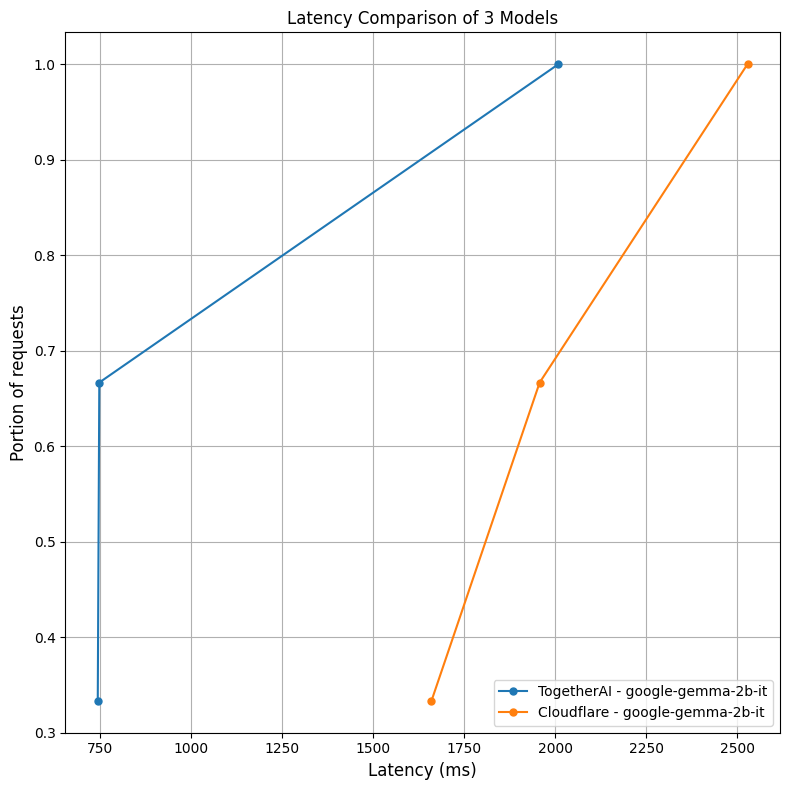

In [18]:
models = ["google-gemma-2b-it"]#, "mistral-7b-instruct-v0.1", "meta-llama-3.1-70b-instruct"]
prompt = "What are some fun things to do in New York? Give me 1 short example."
b = Benchmark([TogetherAI(), Cloudflare()], 3, models, prompt)
b.run()
b.plot_metrics(b.response_times)

##### TogetherAI

##### Model: mistral-7b-instruct-v0.1
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.90* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.78* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *2.18* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.98* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.89* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.26* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.77* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.77* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's winding path, enjoy the views of the city, and explore the various gardens, art installations, and food vendors along the way.

##### _Generated in *2.66* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.78* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.78* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.01* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.86* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.78* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *2.18* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.42* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.28* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.20* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.50* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's gardens, art installations, and stunning views of the city.

##### _Generated in *1.75* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.13* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.16* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.95* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.24* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.00* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.16* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.84* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.94* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.48* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.90* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.45* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.17* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.78* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *2.39* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.15* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.45* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.06* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.00* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.99* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.87* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.12* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.02* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.24* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.15* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's gardens, art installations, and stunning views of the city.

##### _Generated in *1.31* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.42* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.31* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.27* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.84* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can explore the gardens, art installations, and stunning views of the city while enjoying a unique and scenic experience.

##### _Generated in *0.87* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.90* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *2.32* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.92* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.02* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.17* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.98* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's gardens, art installations, and stunning views of the city.

##### _Generated in *1.27* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.96* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.20* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.10* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.03* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.82* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *3.44* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.97* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.45* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's gardens, art installations, and stunning views of the city.

##### _Generated in *1.02* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.00* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.07* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.92* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.89* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can explore the gardens, art installations, and stunning views of the city while enjoying a unique and scenic experience.

##### _Generated in *1.22* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.07* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.28* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.49* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.96* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.29* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.89* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.96* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.91* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.95* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.19* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.37* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.35* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.40* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.85* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.98* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.04* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.10* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.14* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.47* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.18* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.25* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.90* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.19* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.11* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.47* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.17* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.94* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.42* seconds_

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.94* seconds_

##### Cloudflare

##### Model: mistral-7b-instruct-v0.1
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

 New York City is known for its vibrant energy and diverse range of activities. One fun and short example would be taking a stroll through Central Park and visiting the Bethesda Terrace and Fountain. This picturesque area is located in the heart of Central Park and offers a beautiful backdrop for relaxation, people watching, and even a free concert at the Bethesda Terrace and Fountain's Angel of the Waters statue on select days. Additionally, you can rent a rowboat and paddle around the lake for a small fee. It's a great way to soak in the city's scenic beauty while creating memorable experiences.

#### _Generated in *9.61* seconds_

 New York City offers a vast array of exciting and fun activities for visitors! One short example would be a day spent exploring the Intrepid Sea, Air & Space Museum located on Pier 86 in Manhattan.

The Intrepid Museum is home to a unique collection of historic ships, aircraft, and spacecraft. You can explore the legendary space shuttle Enterprise, walk through the historic submarine Growler, and even touch a real meteorite! Interactive exhibits and educational programs provide opportunities for visitors of all ages to learn about the history and science behind these incredible machines.

Additionally, the Intrepid Museum often hosts special events, such as IMAX films, guided tours, and workshops, adding to the overall experience. A visit to the Intrepid Sea, Air & Space Museum is sure to be an educational, memorable, and fun experience for any traveler to New York City!

#### _Generated in *12.77* seconds_

 One fun and iconic activity to do in New York is taking a stroll along the High Line. The High Line is an elevated park built on an old railway line, running from the Meatpacking District in the south to 34th Street in the north. With beautiful views of the city, the park offers a unique perspective of New York's architecture, street life, and art installations. You can relax on the benches, enjoy a picnic, explore the various gardens, or even grab a bite to eat or a drink at one of the many cafes and restaurants along the way. This is just one of the many exciting things you can do in the bustling city of New York!

#### _Generated in *11.24* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at the Rockefeller Center. Here, you can enjoy breathtaking views of the city from the indoor and outdoor observatory on the 70th floor. Watch the sun set over the Manhattan skyline, or take in the vibrant cityscape during the day. Additionally, you might even catch a glimpse of famous New York landmarks such as the Empire State Building, Central Park, and Times Square. It's a must-see experience for any visitor to the Big Apple!

#### _Generated in *9.44* seconds_

 One fun and short activity in New York City is visiting the High Line, an elevated park built on an old railway line. Stroll through the lush greenery, take in the breathtaking views of the city, and explore the various art installations and public spaces along the way. It's a unique and refreshing experience in the heart of Manhattan.

#### _Generated in *6.17* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from an elevation of 70 stories. During the day, you can see Central Park, the Hudson and East Rivers, and some of the most famous buildings in New York. At night, the city comes alive with twinkling lights, offering a magical experience. Plus, it's typically less crowded than the Empire State Building, making for a more enjoyable experience.

#### _Generated in *8.25* seconds_

 New York City offers a wide variety of fun activities for locals and tourists alike. One short example of a fun and popular activity is visiting the Top of the Rock Observation Deck at Rockefeller Center. This observation deck offers breathtaking views of the city from three different levels, including an open-air observation deck that provides a unique experience.

During the day, visitors can enjoy panoramic views of Central Park, the Manhattan skyline, and famous city landmarks. At night, the views are even more spectacular as the city lights up. In addition to the observation decks, Rockefeller Center is home to many other attractions, including the iconic ice-skating rink and NBC Studios, making it a great destination for a full day of fun in New York City.

#### _Generated in *11.22* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This provides an incredible view of the city, especially at sunset or after dark when the lights of the city are on. It's a great way to see the famous New York City skyline, landmarks such as the Empire State Building, Central Park, and Times Square. Plus, it's usually less crowded than the Empire State Building observatory.

#### _Generated in *6.95* seconds_

 One fun and iconic activity to do in New York is taking a stroll through Central Park. It's a great way to experience the city's natural beauty, enjoy a leisurely walk or bike ride, and maybe even catch a performance by the Central Park liveliness. You might spot street performers, artists selling their work, or even a movie or TV production in action. Plus, you'll be within reach of many famous New York landmarks like the Bethesda Terrace, Strawberry Fields, the Central Park Zoo, and the Central Park Conservatory Garden.

#### _Generated in *8.56* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the city's skyline and landmarks such as Central Park, the Empire State Building, and Times Square. You can observe the hustle and bustle of the city from a bird's eye view while sipping on a hot cup of coffee or an ice-cold beverage. It's an experience that's both exciting and memorable!

#### _Generated in *7.14* seconds_

 One fun and iconic activity to do in New York is taking a stroll through Central Park and renting a rowboat or a bicycle to explore its beautiful landscapes. In the warmer months, Central Park comes alive with colorful flowers, lush greenery, and entertainment from street performers. Take a break to enjoy a picnic or visit the Central Park Zoo. Plus, Central Park is located in the heart of Manhattan, making it a convenient and ideal destination for travelers looking to experience the best of the city.

#### _Generated in *7.81* seconds_

 One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center for breathtaking views of the city. In just one short example, imagine an early evening visit during the summer. You can take the elevator up to the observatory level, where you'll find stunning views of Central Park, Times Square, the Empire State Building, and the Hudson River. Sip on a refreshing beverage from the café while you take in the sights and sounds of the bustling city below. Don't forget to bring your camera for unforgettable photos!

#### _Generated in *9.74* seconds_

 One fun and short activity to do in New York is visiting the High Line, an elevated park built on an old railway line. Stroll through the beautiful gardens, take in the unique views of the city, and stop at various art installations and food vendors along the way. It's a great way to spend a few hours enjoying the beauty of nature in the middle of the bustling city.

#### _Generated in *5.98* seconds_

 One fun and short activity to do in New York is visiting the High Line, an elevated park built on an old railway line. It offers stunning views of the city, unique public art installations, and various food vendors along the way. A leisurely stroll through the High Line is a great way to experience New York's beauty and charm while getting some exercise. Make sure to check out the different sections of the park to discover hidden gems and unique perspectives of the bustling city below.

#### _Generated in *7.74* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city's skyline and landmarks such as Central Park, the Chrysler Building, and the Empire State Building. Plus, if you time it right, you can experience the stunning sunset over the city. It's a must-do experience for first-time visitors or repeat travelers looking for a new perspective on the bustling metropolis.

#### _Generated in *7.59* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you'll get stunning views of the city, including Central Park, Times Square, and the iconic skyline. short example: Spend an afternoon enjoying the breathtaking vistas from the Top of the Rock during sunset. Don't forget to capture the moment with a memorable photo!

#### _Generated in *6.43* seconds_

 One fun and iconic activity to do in New York is taking a stroll through Central Park, especially during the spring and summer months. Rent a bike, rollerblade, or simply walk and enjoy the beautiful scenery. Don't miss out on visiting the Central Park Zoo, StrawberryFields, or taking a boat ride in the lake. Stop for a bite to eat at one of the many food carts or have a picnic in the park. On the weekends, check out the various performances and events happening in the park, like a free concert in the Delacorte Theater or a street fair. It's a classic New York experience that's sure to create lasting memories.

#### _Generated in *10.55* seconds_

 One fun and iconic activity in New York is visiting the Top of the Rock Observation Deck at the Rockefeller Center. It offers breathtaking views of the city, including Central Park, Times Square, and the Statue of Liberty. You can enjoy these views during the day or at night when the city is beautifully lit up. Plus, it's often less crowded than the observatories at the Empire State Building or One World Trade Center. After taking in the sights, you can explore the Rockefeller Center area, which hosts various events and activities throughout the year.

#### _Generated in *8.74* seconds_

 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a rowboat and paddle around the beautiful lake, hire a bike to explore the park's scenic trails, or simply relax and enjoy a picnic in the sunshine. Don't forget to visit famous landmarks such as the Bethesda Terrace and Fountain, the Conservatory Water, and the Central Park Zoo. It's a great way to experience the natural beauty and energy of the city.

#### _Generated in *7.74* seconds_

 New York City is known for its vibrant energy and endless possibilities for entertainment. One fun and short activity you could try is visiting the High Line, an elevated park built on an old railway line. Stretching from the Meatpacking District to 34th Street, the High Line offers unique views of the city, artistic installations, and a variety of plants and gardens. Have a picnic, take a leisurely walk, or simply enjoy the panoramic vistas of the city from this unusual perspective. It's a great way to spend an afternoon in New York!

#### _Generated in *8.11* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center for breathtaking views of the city. In just one short example, imagine an early afternoon visit during the spring or summer months. After purchasing your ticket, you'll take a quick elevator ride up to the observation deck on the 70th floor. Once there, you'll be greeted with panoramic views of New York City,Central Park, and the famous skyline. Sipping on a hot or cold beverage from the on-site café, you can relax on one of the bench seats while taking in the spectacular vistas. As the sun begins to set, the city transforms with the vibrant colors of the sunset and the twinkling lights coming on in the buildings. It's a unique and unforgettable experience that is sure to put a smile on your face.

#### _Generated in *13.50* seconds_

 One fun and iconic activity in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Standing 70 stories above the city, you can enjoy breathtaking views of New York's famous skyline and Central Park. During the day, you'll see an incredible panorama of the city, and at night, the view transforms into a stunning light show. Take your time to explore the three observation levels, take some photos, and maybe even bring a picnic to enjoy with the view! Fun fact: The Top of the Rock is less crowded compared to the Empire State Building, making for a more relaxed and enjoyable experience!

#### _Generated in *9.34* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including Central Park, Times Square, and the Statue of Liberty (on a clear day). Plus, it's open later hours than the Empire State Building Observatory, making for great sunset or nighttime views. A short example of an experience could be: "I went to the Top of the Rock Observation Deck at sunset and watched as the city transformed from day to night, with the glittering lights illuminating the skyline. It was a truly magical experience!"

#### _Generated in *9.70* seconds_

 One fun and iconic activity in New York is taking a stroll across the Brooklyn Bridge. The bridge offers stunning views of the Manhattan skyline, the Hudson River, and the bustling city below. The walk is approximately 1.3 miles long and is great for both tourists and locals alike. Once you reach the Brooklyn side, be sure to explore the nearby Brooklyn Heights neighborhood for some delicious food and unique shops. Keep in mind that the bridge may be busier during peak hours, so consider going earlier in the day for a more enjoyable experience.

#### _Generated in *8.16* seconds_

 New York City is known for its vibrant and diverse range of activities. Here's a short example of a fun thing to do:

Visit the Top of the Rock Observation Deck:
Located in the Heart of Rockefeller Center, this observation deck offers stunning views of the city. You can take in the breathtaking panorama of iconic landmarks such as Central Park, Times Square, and the Empire State Building. Plus, it's open later than the Empire State Building Observatory, making it a great option for an evening visit to see the city lights. Just remember to book your tickets in advance to avoid long lines!

#### _Generated in *10.32* seconds_

 New York City offers a wide range of fun activities for visitors. one short example would be a day trip to Central Park. You can rent a bike and explore the park's scenic paths, visit the Central Park Zoo, relax in the Sheep Meadow, or take a leisurely stroll through the Alice in Wonderland sculpture garden. In the evening, you can enjoy a free concert in the Delacorte Theater or watch the sun set from the Top of the Rock Observation Deck. There's truly something for everyone in Central Park!

#### _Generated in *8.55* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This experience offers stunning 360-degree views of the city, including Central Park, Times Square, and the Statue of Liberty. Plus, it's open later than the Observatory at the Empire State Building, allowing you to enjoy the breathtaking sunset over the city. Make sure to have your camera ready to capture some amazing memories!

#### _Generated in *7.90* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from an elevation of 70 stories. It's open year-round, and the stunning 360-degree panorama is particularly beautiful at sunset or during the winter season when the city is adorned with holiday lights. Additionally, it's a bit more affordable than the Empire State Building, making it an excellent choice for budget-conscious travelers. Plus, it's located in the heart of Midtown Manhattan, making it easily accessible from most parts of the city.

#### _Generated in *10.27* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Tickets grant you access to three observation levels, offering breathtaking views of the city's skyline and central park. An added bonus is that the observation decks close an hour earlier than the Empire State Building, giving visitors a chance to enjoy the views at sunset or even after dark when the city lights up beautifully. Short example: Spend an evening at Top of the Rock, soaking in unobstructed views of the New York City skyline as the sun sets over the horizon. Additionally, if you're visiting during the winter season, make sure to attend the Rink at Rockefeller Center located at the base of the building and skate under the twinkling Christmas tree right after your observation deck visit.

#### _Generated in *12.21* seconds_

 New York City offers a vast array of fun activities for visitors. One short example is a day trip to Central Park. You can rent a rowboat or a bike, take a leisurely stroll through the park's beautiful gardens and scenic paths, visit the Central Park Zoo or the Central Park Conservatory Garden, or even attend a free outdoor concert or performance in the summer months. Additionally, you may want to grab a hot dog from a street vendor, relax in the sun, or take in the iconic views of the city from the park's various vantage points. Remember to bring a camera to capture some memories!

#### _Generated in *8.90* seconds_

 One fun and iconic activity to do in New York is taking a stroll through Central Park and renting a rowboat or a paddleboat at the Loeb Boathouse. It's a perfect way to enjoy the beautiful scenery of the park, relax at a leisurely pace, and take in the sights and sounds of the bustling city surrounding it. Keep in mind that the boathouse operates seasonally, so be sure to check their hours of operation before planning your visit.

#### _Generated in *7.33* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city's skyline and Central Park from an elevation of 70 stories. Plus, the observation deck offers both indoor and outdoor viewing areas, so you can experience the classic New York City view rain or shine. Additionally, visiting at sunset or after dark allows you to see the city's stunning lights and skyline transformation.

#### _Generated in *7.93* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the city's skyline and landmarks such as Central Park, Times Square, and the Statue of Liberty. You can also time your visit to see the sunset over the city for an unforgettable experience. Short example: "Let's go to the Top of the Rock Observation Deck today! We'll enjoy amazing views of New York and maybe even catch the sunset over the city."

#### _Generated in *8.31* seconds_

 One fun and iconic activity to do in New York is taking a stroll through Central Park. In the heart of the city, Central Park offers various attractions for visitors, from relaxing in the beautiful gardens and meadows, renting a rowboat or a bike, visiting the Central Park Zoo, or even just people-watching. It's a great way to escape the hustle and bustle of the city while still experiencing the unique energy of New York. Plus, it's free to enter and explore!

#### _Generated in *8.23* seconds_

 One fun and iconic activity in New York City is taking a stroll through Central Park. In the heart of the city, Central Park offers a variety of activities for visitors. You can rent a rowboat or a bike and explore the park's scenic beauty, take a leisurely walk among its beautiful gardens, or enjoy a picnic on a sunny day. Additionally, Central Park hosts numerous events and festivals throughout the year, so be sure to check their calendar for fun and unique experiences.

#### _Generated in *7.63* seconds_

 One fun and iconic activity in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the city, including the Empire State Building, Times Square, Central Park, and the Hudson River. You can take in the stunning vistas during the day or at sunset for an unforgettable experience. Short in length but full of adventure and memory-making moments!

#### _Generated in *6.92* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the city, including the famous Central Park, Times Square, and the statue of liberty (on a clear day). You can also time your visit to see the sunset over the city. It's a great experience for both tourists and locals alike. Plus, it's open 365 days a year, so you can visit at any time of the year.

#### _Generated in *8.03* seconds_

 New York City offers a vast array of fun activities for visitors. One short example would be a day spent exploring Central Park. You can start your day by renting a rowboat or a bike to explore the lake or the park's many paths. Grab a hot dog from a street vendor and have a picnic in Sheep Meadow. Catch a show at the Delacorte Theater in the summer or visit the Central Park Zoo. For art lovers, the Metropolitan Museum of Art is just a short walk away. And no visit to Central Park would be complete without checking out the iconic Bow Bridge or the Bethesda Fountain and Terrace. There's always something new to discover in this urban oasis!

#### _Generated in *10.85* seconds_

 One fun and iconic activity in New York City is visiting the Top of the Rock Observation Deck at Rockefeller Center. With stunning 360-degree views of the city, you can see famous landmarks such as the Empire State Building, Central Park, and Times Square. The observation deck is open year-round, and the best time to visit is during sunset for a breathtaking view of the city as the sun goes down. Additionally, check out the area around Rockefeller Center for shopping, dining, and special events throughout the year.

#### _Generated in *8.32* seconds_

 Absolutely! New York City is known for its vibrant energy and endless list of things to see and do. One fun activity that is beloved by both tourists and locals is visiting the High Line, an elevated park built on a former railway line. The High Line offers breathtaking views of the city, unique art installations, and beautiful gardens spread over a mile long park. During your walk, you can grab a bite to eat at one of the many food vendors or stop by the various shops along the way. It's a great way to experience the city in a unique and outdoor setting. Plus, it's free to enter! Enjoy your New York adventure! :)

#### _Generated in *9.38* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city's skyline and Central Park from an observatory deck on the 70th floor. It's open year-round, and the hours extend later in the summer months, allowing you to catch a stunning sunset over the city. Additionally, you can take a stroll through the nearby Rockefeller Plaza andice-skate on the famous rink during the winter season. This is just one of the many exciting experiences New York has to offer!

#### _Generated in *11.01* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at the Rockefeller Center. This offers stunning views of the city, including the famous Central Park and the towering skyscrapers that make up the New York City skyline. Plus, the observation deck is open earlier than some other popular observation decks in the city, making it a great option for catching sunrise or sunset views. A short example of a fun day out could be: Start your day with a visit to Top of the Rock, followed by a leisurely stroll through Central Park, have lunch at a local street food vendor, and spend your afternoon exploring some of the city's great museums or shopping districts. In the evening, head back to the Top of the Rock to witness the city's breathtaking lights and energy come alive at night.

#### _Generated in *14.52* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from an observation deck with open-air terraces. You can see famous landmarks like the Empire State Building, Central Park, and Times Square from this vantage point. Plus, you may even be treated to a beautiful sunset over the skyline. It's an experience that's sure to create lasting memories!

#### _Generated in *7.01* seconds_

 New York City is known for its vibrant culture and endless variety of things to see and do. One fun and short example would be a visit to the Top of the Rock Observation Deck at Rockefeller Center. Here, you can take in breathtaking views of the city skyline and Central Park from an elevation of over 70 stories. You can also enjoy a stroll through the beautiful gardens and fountains at the base of the Rockefeller Center campus. This activity is perfect for both tourists and locals looking for a fun and memorable experience in the heart of New York City.

#### _Generated in *8.26* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at the Rockefeller Center. Here, you can enjoy breathtaking views of the city's skyline and Central Park, especially during sunset. Plus, the observation deck offers both indoor and outdoor viewing areas, making it a great option for any weather. Once you reach the top, take your time to soak in the panoramic landscape and maybe even take some memorable photos. It's a must-do experience for anyone visiting New York!

#### _Generated in *8.16* seconds_

 One fun and iconic activity to do in New York is taking a stroll through Central Park and visiting the Bethesda Terrace and Fountain. You can enjoy a picnic, rent a rowboat, or simply take in the beautiful scenery and people-watch. In the autumn, the leaves create a breathtaking backdrop, while in the winter, the fountain freezes over and becomes a popular ice-skating rink. Don't forget to make a wish by tossing a coin into the fountain!

#### _Generated in *8.72* seconds_

 One fun and iconic activity to do in New York is taking a stroll through Central Park and visiting the Central Park Zoo. You can rent a rowboat or a bike to explore the park, enjoy a picnic, or even take a guided tour. The Central Park Zoo is home to over 130 species of animals, including penguins, seals, reptiles, and birds. Kids and adults alike will enjoy the interactive exhibits and learning about the animals from the knowledgeable staff. Remember to keep an eye out for the famous Central Park characters like the Bethesda Fountain Angel or the Bow Bridge!

#### _Generated in *10.24* seconds_

 One fun and iconic activity to do in New York is taking a stroll through Central Park and visiting the Central Park Zoo. You can rent a bike or a rowboat, have a picnic, or simply enjoy the beautiful scenery. At the zoo, you can get up close and personal with animals from around the world, including penguins, seals, and red pandas. It's a great way to experience the best of nature in the heart of the city.

#### _Generated in *7.24* seconds_

 New York City offers a vast array of exciting and fun activities for visitors. One short example that combines history, culture, and fun is a visit to the Intrepid Sea, Air & Space Museum. Here, you can explore a variety of historic vessels and artifacts, including the USS Intrepid aircraft carrier, thespace shuttle Enterprise, and a Concorde supersonic jet. Interactive exhibits and multimedia presentations help bring the history to life, making it an educational and entertaining experience for all ages. Additionally, the museum often hosts events and activities, such as IMAX films and special exhibitions, adding an extra layer of excitement to your visit.

#### _Generated in *9.86* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center for breathtaking views of the city. You can enjoy panoramic vistas of the Manhattan skyline, Central Park, and various landmarks such as the Empire State Building and the Chrysler Building. Additionally, visiting at sunset offers an extra special treat as you get to witness the beautiful transition of the city from day to night. This is just one of the many exciting experiences New York City has to offer!

#### _Generated in *8.06* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at the Rockefeller Center.You can enjoy breathtaking views of the city from three different levels, including an outdoor terrace. The experience is even more exciting during sunset or at night when the city lights up. plus, you can take some great photos! Just remember to book your tickets in advance to avoid long lines. It's not just fun, it's a must-do when visiting New York City!

#### _Generated in *8.85* seconds_

 New York City is known for its vibrant culture and endless entertainment options. One fun activity you can do is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from three observation decks and an open-air terrace. This short example combines sightseeing with beautiful views, making it an exciting experience in the heart of the city. Afterward, you might enjoy a delicious meal at one of the many restaurants in the area or take a stroll through Central Park to explore more of what New York has to offer!

#### _Generated in *10.00* seconds_

 New York City is known for its vibrant energy and endless activities. Here's a short example of a fun and popular activity:

Visiting the Top of the Rock Observation Deck at Rockefeller Center:
Experience breathtaking views of New York City by visiting the Top of the Rock observatory. Scarlett Johansson, in Woody Allen's movie "Sleepless in Seattle," famously describes the city's skyline from this very spot. Take an elevator ride up to the observation deck and enjoy panoramic views of iconic landmarks such as Central Park, Times Square, and the Statue of Liberty. It's a great place for both daytime and nighttime visits.

#### _Generated in *11.97* seconds_

 Absolutely! New York City is known for its vibrant energy and diverse activities. One fun and short example would be taking a stroll through Central Park and renting a rowboat or a bike to explore its beautiful landscapes, lakes, and scenic views. Don't forget to take some pictures by the iconic Central Park Bridge or the Central Park Bethesda Terrace and Fountain. This is an excellent way to enjoy nature in the heart of the bustling city while getting some exercise and fresh air.

#### _Generated in *7.49* seconds_

 New York City offers a wide range of fun activities for visitors. Here's a short example of an enjoyable experience:

Take a Stroll in Central Park: Central Park is an urban oasis in the heart of Manhattan. You can rent a bike, rollerblade, or simply take a leisurely walk through this beautiful 843-acre park. Enjoy the picturesque landscape, take in the iconic views of the city, and perhaps even catch a street performer or two. Central Park also offers a variety of attractions, including the Central Park Zoo, the Alice in Wonderland Statue, and several lakes where you can rent a rowboat. Spending an afternoon in Central Park is a must-do activity when visiting New York City.

#### _Generated in *11.37* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at the Rockefeller Center. You can take the elevator to the 70th floor and enjoy breathtaking views of the city, including Central Park, Times Square, and the Statue of Liberty. Plus, it's open later hours than the Empire State Building Observatory, making it an ideal spot to watch the sunset or the city lights at night. And if you're there during the holiday season, you can't miss the stunning view of the Rockefeller Center Christmas Tree!

#### _Generated in *9.43* seconds_

 New York City is known for its vibrant energy and endless activities. One fun thing to do is a visit to Central Park, especially during the warmer months. You can rent a bike and explore the park's scenic paths, relax in the Sheep Meadow, go boating on the Lake, or even attend a free concert or event at the Delacorte Theater. It's a great way to experience the beauty of nature in the heart of the city. Another fun activity is exploring the diverse food scene, from classic New York pizza to international cuisine in various neighborhoods.

#### _Generated in *8.63* seconds_

 New York City offers a wide range of fun and exciting activities for visitors. One short example is a day spent exploring Central Park. You can rent a bike or take a leisurely stroll through the park, enjoying the beautiful scenery and various landmarks such as the Bethesda Terrace and Fountain, the Central Park Zoo, and the Conservatory Water. Additionally, you can visit the Central Park Boathouse for a delicious lunch with a view of the lake, or take a boat ride around the lake for an extra special experience. There are also numerous events and activities occurring in the park throughout the year, such as outdoor concerts, film screenings, and sports competitions, so be sure to check the Central Park website for upcoming events.

#### _Generated in *12.05* seconds_

 One fun activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center for stunning views of the city. Here's a short example:

Imagine standing at the edge of the observational deck, feeling the crisp air against your skin as the sun begins to set over the city. To your left, the iconic Empire State Building casts a golden glow against the evening sky. Directly in front of you, the sprawling metropolis stretches out in all directions, from the towering structures of Midtown to the bustling streets of Times Square. And to your right, the serene waters of Central Park reflect the dying light of the day.

As you take it all in, the sounds of the city fade into the background, leaving only the gentle hum of conversation between you and your companions. The experience is a perfect reminder of the beauty and energy that New York constantly embodies.

#### _Generated in *13.32* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the city and its famous skyline, including Central Park, Times Square, and the Statue of Liberty (on a clear day). Plus, you can also take in the view at sunset for an extra special experience. Make sure to book your tickets in advance to avoid long lines!

#### _Generated in *6.56* seconds_

 One fun and short activity to do in New York is visiting the High Line, an elevated park built on a former railway track. Stroll through the lush greenery and unique gardens, take in breathtaking views of the city and the Hudson River, and explore various art installations along the way. Don't forget to try some delicious street food from nearby vendors! This activity is perfect for a leisurely afternoon or early evening.

#### _Generated in *7.57* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including the iconic view of the Empire State Building. Plus, it's open later than the observatory at the Empire State Building, so you can enjoy the city lights at night. A short example of the experience could be: "Imagine standing at the Top of the Rock, feeling the cool evening breeze against your face as you look out at the sprawling cityscape before you. The sun sets behind you, casting the sky in beautiful hues of orange and pink. As the night comes alive, the city lights twinkle and dance below you, creating a magical and unforgettable moment."

#### _Generated in *11.35* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city's skyline and landmarks such as Central Park, Times Square, and the Statue of Liberty. A short example of the experience could be: "Imagine standing at the Top of the Rock, feeling the cool breeze in your hair as you gaze upon the vibrant, sprawling city below. The sun sets behind you, painting the sky with hues of pink and orange as the city lights twinkle to life. It's a moment of awe and wonder that encapsulates the essence of New York City."

#### _Generated in *9.98* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including the iconic view of the Statue of Liberty and Ellis Island on a clear day. You can also enjoy it after dark to see the city illuminated. Additionally, you may even catch a free outdoor performance at the Rockefeller Center Plaza. It's a great way to experience the magic of New York and create lasting memories.

#### _Generated in *7.70* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at the Rockefeller Center. Here, you can enjoy breathtaking views of the city's skyline and central park from an observation deck open on all sides, offering unobstructed views. It's particularly beautiful at sunset or during the holiday season when the city is adorned with festive lights. Plus, it's often less crowded than the competing observation decks at the Empire State Building, making for a more enjoyable experience!

#### _Generated in *8.93* seconds_

 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a bike, have a picnic, visit the Central Park Zoo, or simply enjoy the beautiful scenery and people-watching. In the summer months, you can also attend free outdoor concerts and events. It's a great way to experience the natural beauty of the city and get some exercise, all while creating lasting memories.

#### _Generated in *6.34* seconds_

 New York City is known for its vibrant energy, cultural diversity, and numerous attractions. One fun activity that is both entertaining and educational is visiting the Intrepid Sea, Air & Space Museum.

Located on the western side of Manhattan, this unique museum features a collection of historic aircraft, spacecraft, and naval vessels. Visitors can explore the legendary Concorde supersonic jet, the Space Shuttle Enterprise, and even take a tour aboard the historic aircraft carrier, USS Intrepid.

This is just one example of the many exciting things to do in New York City. Other popular activities include visiting iconic landmarks such as Times Square, Central Park, and the Statue of Liberty; trying world-class cuisine from various ethnic neighborhoods; seeing a Broadway show; or taking a stroll along the High Line, an innovative elevated park built on an old rail line.

#### _Generated in *13.24* seconds_

 One fun and iconic activity in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including Central Park, Times Square, and the Empire State Building. It's open year-round, and the Sunset & Night Views are particularly spectacular. A short example: Spend an evening at Top of the Rock, watching the sunset over Manhattan and then experiencing the illuminated cityscape at night. Fun fact: the observation deck has three levels with indoor and outdoor viewing areas, giving you various perspectives of the city.

#### _Generated in *8.68* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city's skyline and landmarks such as Central Park, Times Square, and the Statue of Liberty. You can also time your visit for sunset to experience the magical transition of the city as the day turns into night. Additionally, you may even spot some filming crews, as the site is a popular location for movies and TV shows.

#### _Generated in *7.41* seconds_

 New York City offers a vast array of fun activities for visitors. One short example that combines culture, history, and entertainment is a visit to the Metropolitan Museum of Art, followed by a stroll through Central Park.

At the Met (located on 5th Avenue and 82nd Street), you can explore over 2 million works of art from around the world and throughout history. Be sure to check out the Egyptian Temple of Dendur and the European Paintings galleries.

Once you've had your fill of art, head to Central Park, just a few blocks north. You can rent a rowboat and paddle around the Lake, take a leisurely stroll through the Bethesda Terrace and Fountain, or simply enjoy a picnic in the sun. The park is bustling with life, so there's always something interesting to see or do.

#### _Generated in *13.87* seconds_

 New York City offers a vast array of fun activities for visitors. One short example of a fun and iconic experience is taking a stroll across the Brooklyn Bridge. This scenic walk or bike ride provides stunning views of the Manhattan skyline and the New York Harbor. The bridge's rich history and architectural beauty make it a must-see attraction for both first-time and returning travelers to the city. Don't forget to capture a memorable photo, especially during sunrise or sunset, for an unforgettable New York experience.

#### _Generated in *8.09* seconds_

 New York City is known for its bustling energy and diverse cultural offerings. One fun and short activity to experience is a visit to the Top of the Rock Observation Deck at Rockefeller Center. Here, you can take in breathtaking views of the city's iconic skyline and Central Park from an elevation of 70 stories. It's an unforgettable experience that showcases the true beauty of the Big Apple. Plus, it's open year-round, so you can enjoy the view regardless of the season!

#### _Generated in *8.86* seconds_

 New York City is known for its vibrant culture and endless possibilities for entertainment. Here's a short example of a fun activity you can do:

Take a stroll through Central Park and rent a rowboat! For just a few dollars, you can rent a rowboat and enjoy a peaceful hour on the water. Central Park's scenic lake is the perfect place to unwind and take in some beautiful views of New York City. Keep in mind that rowboats are available on a first-come, first-served basis, so it's best to arrive early in the day to secure one. Have a great time exploring this iconic New York City landmark!

#### _Generated in *10.02* seconds_

 One fun and iconic activity in New York City is taking a stroll through Central Park. You can rent a boat and row on the lake, rent a bike and explore the park's many trails, or simply enjoy a picnic and people-watch. In the summer months, you might catch a free outdoor concert or performance. Central Park is a must-see attraction that offers something for everyone.

#### _Generated in *6.86* seconds_

 One fun and iconic activity in New York is taking a stroll through Central Park and visiting the Central Park Zoo. Central Park is a 843-acre urban park located in the heart of Manhattan, offering a variety of activities for visitors including scenic walks, picnics, boating, and biking. The Central Park Zoo, located at the southern end of Central Park, is home to over 130 animal species. Some popular exhibits include the Tisch Children's Zoo, where kids can interact with animals, and the Sea Lion Pool, where you can watch sea lions perform playful behaviors. It's a great way to enjoy the outdoors, explore the city, and see some amazing creatures.

#### _Generated in *10.33* seconds_

 One fun and iconic activity to do in New York is taking a stroll around Central Park. You can rent a boat and row along the lake, rent a bike to pedal around the park's scenic paths, or simply enjoy a picnic on the green lawn. Don't forget to visit the Central Park Zoo or Bethesda Fountain for added excitement. It's a great way to experience the beauty and vibrancy of the city while enjoying some fresh air and sunshine.

#### _Generated in *7.22* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at the Rockefeller Center. Besides enjoying the breathtaking views of the city's skyline and Central Park, this destination offers a unique perspective of the famous New York City landmarks, such as the Empire State Building and the Chrysler Building. Additionally, visiting during sunset presents an incredible sight, as the city transforms from day to night. It's an experience that perfectly embodies the excitement and energy of New York City.

#### _Generated in *8.82* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center for stunning views of the city. You can take in breathtaking views of the Manhattan skyline, Central Park, and various landmarks such as the Empire State Building and the Chrysler Building. Plus, it's open later hours than some other observation decks, so you can experience the city's beautiful nighttime skyline. And it's a short example, promise!

#### _Generated in *7.67* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from an observation deck with open-air terraces. After taking in the panoramic vistas, you can explore the surrounding area and visit other attractions such as Radio City Music Hall or ice-skate at the Rockefeller Center Rink (seasonal). It's a great way to experience the city's energy and beauty from a unique perspective.

#### _Generated in *8.57* seconds_

 New York City offers a wide range of fun activities for visitors. One short example that combines history, art, and beautiful views is a visit to the Metropolitan Museum of Art, followed by a stroll through Central Park.

At the Met, you can explore over two million works of art from around the world and throughout history. Some highlights include the Egyptian temples, the European paintings galleries, and the American Wing. After spending a few hours immersed in culture, take a leisurely walk through Central Park. You can rent a rowboat and paddle in the Lake, visit the Central Park Zoo, or simply enjoy a picnic in the sun.

Another short activity could be taking a ferry to the Statue of Liberty and Ellis Island. Experience the wonder of Lady Liberty and learn about the history of immigrants who came to America through Ellis Island. This excursion is both educational and iconic.

#### _Generated in *13.85* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. For a short example, imagine a breezy afternoon in late spring. You purchase your ticket and ascend in a swift escalator ride to the 70th floor, where you step out onto an open-air terrace with breathtaking views of Central Park, the Empire State Building, and the sprawling metropolis beyond. With a sweet treat in hand from the nearby café, you wouldn't want to leave but, as the sun begins to set, the glow of the city lights up the night sky, illuminating the vibrant streets below.

#### _Generated in *10.05* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Not only can you enjoy breathtaking views of the city from three different levels, but you can also experience it at various times of the day or night. event (during sunset or after dark is especially magical). The observation deck is open year-round, so no matter when you visit, you're sure to have an amazing experience. Plus, it's a great photo opportunity!

#### _Generated in *8.58* seconds_

 One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers stunning views of the city, including the iconic Central Park and the impressive city skyline. Plus, visiting during sunset adds an extra magical touch. Short example: "Let's head to the Top of the Rock at sunset for breathtaking views of New York's vibrant cityscape."

#### _Generated in *6.32* seconds_

 One fun and iconic activity to do in New York is taking a stroll through Central Park. In the heart of the city, Central Park offers a refreshing escape with its beautiful landscapes, lakes, gardens, and various attractions. Rent a rowboat or a bike, feed the ducks, catch a show at the Delacorte Theater, or simply enjoy a picnic while taking in the bustling city skyline. It's an excellent way to experience the unique blend of urban energy and natural beauty that New York has to offer.

#### _Generated in *8.61* seconds_

 One fun and short activity to do in New York is visiting the High Line, an elevated park built on an old railway line. You can take a leisurely stroll among the greenery, enjoy beautiful views of the city and the Hudson River, and discover various public art installations along the way. Plus, there are several food and beverage vendors located nearby, perfect for a quick snack or drink while taking in the sights.

#### _Generated in *6.80* seconds_

 One fun and iconic activity in New York City is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including the iconic Central Park, the Statue of Liberty, and the stunning Manhattan skyline. plus, you can witness the city's vibrant energy and lights during the day and transform into a twinkling metropolis at night. A short example of how to get there: Take the subway to the 47-50 Streets Rockefeller Center station, then walk through the stunning shopping concourse and up to the observation deck. Don't forget to bring a camera to capture the memories!

#### _Generated in *10.09* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including the iconic Central Park, the Statue of Liberty, and the stunning Manhattan skyline. You can also time your visit to see the sunset over the city, making for a memorable experience. Additionally, you may even catch a glimpse of various filming locations for movies and TV shows. It's an excellent choice for tourists and locals alike!

#### _Generated in *7.50* seconds_

 One fun and iconic activity in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers stunning views of the city skyline and central park from an elevation of 70 stories. You can enjoy the breathtaking scenery during the day or at night when the city comes alive with twinkling lights. Don't forget to bring your camera! For an added adventure, consider visiting during sunset for a truly magical experience.

#### _Generated in *6.81* seconds_

 One fun and iconic activity in New York City is visiting the Top of the Rock Observation Deck at Rockefeller Center for stunning views of the city. Not only can you see the famous Manhattan skyline, but you can also enjoy panoramic views of Central Park and various city landmarks such as the Statue of Liberty and the Chrysler Building. It's a great way to experience the scale and beauty of New York City, and it's particularly breathtaking during sunset or at night when the city is all lit up.

#### _Generated in *8.47* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers stunning panoramic views of the city, including Central Park, Times Square, and the bustling streets below. You can also time your visit to see the sunset, making for a memorable experience. Just a heads up, it can get quite crowded, so try to go during less busy hours if possible.

#### _Generated in *6.44* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from over 70 floors up. It's open late into the night, offering stunning sunset and after-dark views of the city lights. Plus, the observation deck is less crowded than the Statue of Liberty or Empire State Building, making for a more relaxing experience. Keep in mind that it's best to book tickets in advance during peak season to skip the lines.

#### _Generated in *8.82* seconds_

 One fun and short activity to do in New York is visiting the High Line, an elevated park built on a former railway line. You can take a leisurely stroll among the greenery, enjoy stunning views of the city and Hudson River, and discover unique public art installations along the way. Additionally, there are various food vendors and cafes located nearby, making it a perfect spot for a relaxing afternoon in the heart of Manhattan.

#### _Generated in *8.36* seconds_

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking panoramic views of the city from the indoor and outdoor observation decks, located on the 70th and 67th floors. It's a fantastic experience, especially during sunset, when you can witness the city transforming from day to night. Additionally, it's less crowded compared to the Empire State Building, making for a more enjoyable experience. Keep in mind that advance ticket purchase is highly recommended to avoid long lines.

#### _Generated in *9.48* seconds_

 One fun and iconic activity in New York City is taking a stroll through Central Park. You can rent a rowboat or a bike, enjoy a picnic, visit the Central Park Zoo, or simply relax and soak in the bustling energy of the city surrounded by nature. Keep in mind that it's always a good idea to check the official Central Park website for current hours and activities.

#### _Generated in *7.58* seconds_

 One fun and iconic activity to do in New York is to take a stroll through Central Park and visit the Bethesda Terrace and Fountain. This beautiful area in the heart of Central Park is famous for its stunning architecture, intricate mosaic tiles, and the elegant Bethesda Fountain, also known as the "Angel of the Waters." You can enjoy a leisurely picnic, take a boat ride on the Lake, or simply relax and soak in the stunning views. Additionally, street performers and musicians often entertain visitors, adding to the vibrant and lively atmosphere.

#### _Generated in *10.63* seconds_

 One fun thing to do in New York is taking a stroll through Central Park, especially during the spring and summer months. You can rent a boat and row on The Lake, visit the Central Park Zoo, or just enjoy a picnic in the sunshine. Another popular activity is renting a bike and biking around the park's scenic routes. Don't forget to take in the iconic views of the city skyline, and keep an eye out for famous landmarks such as the Bethesda Fountain and the Bow Bridge.

#### _Generated in *7.90* seconds_

 New York City offers a vast array of exciting activities for visitors. One fun and short example is a visit to the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from the indoor and outdoor observation decks on the 70th floor. Plus, it's open late into the night, making for a romantic experience during twilight hours or under the stars. Don't miss the iconic view of the Empire State Building lit up at night!

#### _Generated in *8.24* seconds_

 New York City is known for its vibrant energy and endless entertainment options. Here's a fun and short example of an activity you could do:

Visit the Top of the Rock Observation Deck at Rockefeller Center:
Walk through the iconic Art Deco halls of Rockefeller Center and ascend to the Top of the Rock Observation Deck for breathtaking views of New York City. This observation deck offers panoramic vistas of the city's skyline, Central Park, and the famous landmarks such as the Statue of Liberty and the Chrysler Building. It's an unforgettable experience that allows you to truly appreciate the grandeur of the Big Apple. Plus, visiting during sunset provides an additional visual treat!

#### _Generated in *11.59* seconds_

 One fun and iconic activity to do in New York is to visit the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city's skyline and landmarks, such as Central Park, Times Square, and the Statue of Liberty. Plus, during the holiday season, the observation deck offers stunning views of the Rockefeller Center Christmas Tree. You can also time your visit for sunset to witness the magical transformation of the city as the day turns into night.

#### _Generated in *8.83* seconds_

 Sure thing! New York City is known for its endless array of activities and attractions. Here are a few fun things you could do:

1. Take a stroll through Central Park: Central Park is a beautiful green oasis in the heart of Manhattan. You can rent a rowboat or a bike, visit the Central Park Zoo, or just take a leisurely walk through the park's many paths and gardens. It's the perfect way to spend an afternoon, especially during the spring and summer months. (Short example: Pack a picnic, rent a rowboat, and spent an afternoon on the Serene Lake in Central Park.)

#### _Generated in *9.12* seconds_

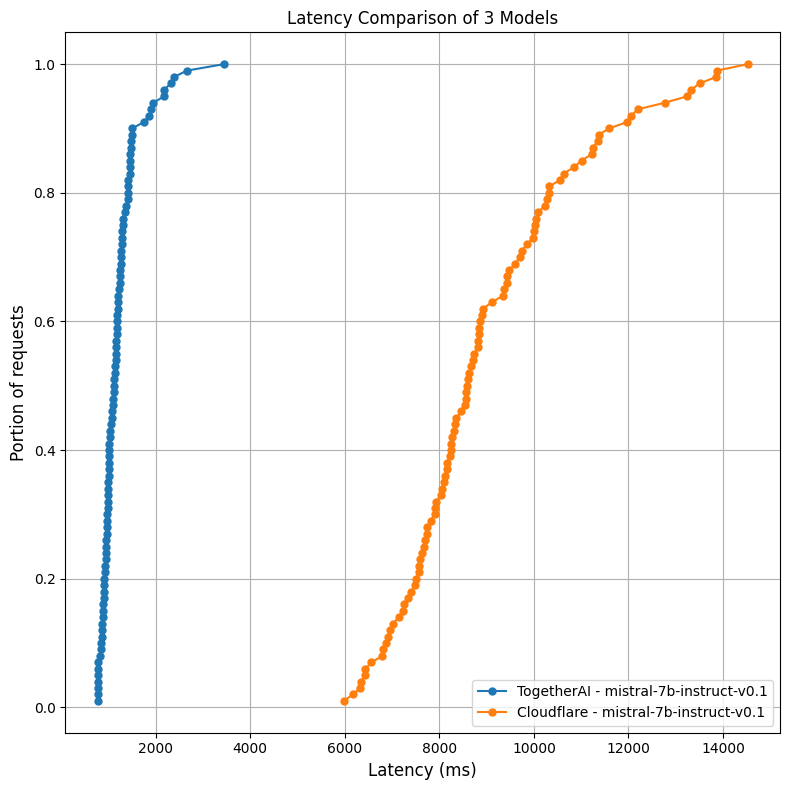

In [300]:
# Comparing end to end response times 
prompt = "What are some fun things to do in New York? Give me 1 short example."
b = Benchmark([TogetherAI(), Cloudflare()], 100, models=["mistral-7b-instruct-v0.1"], prompt=prompt)
b.run()
b.plot_metrics(b.response_times)

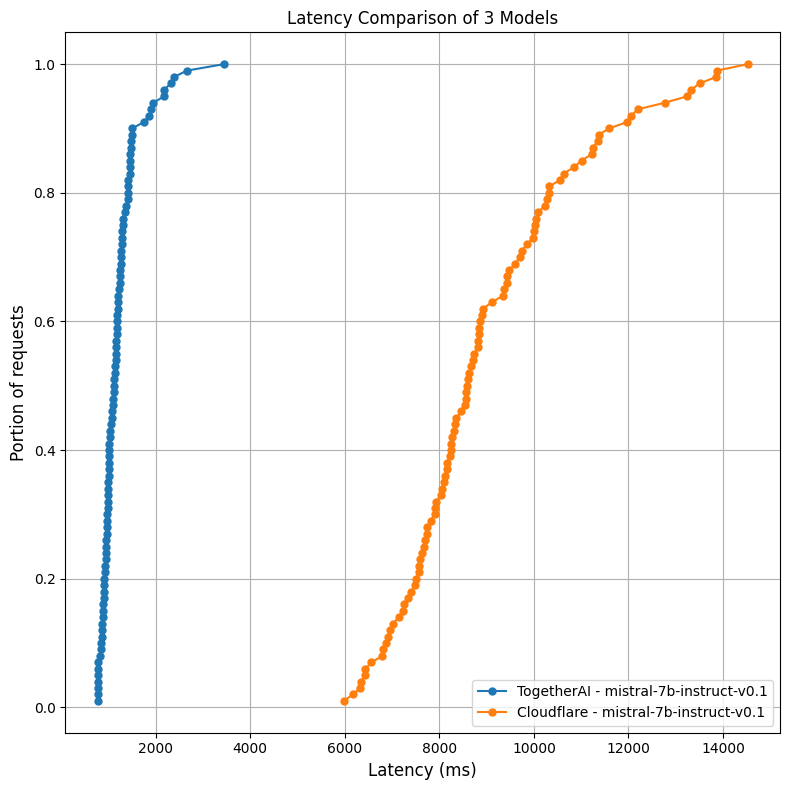

In [301]:
b.plot_metrics(b.response_times)

In [19]:
# Comparing TTFT 
prompt = "What are some fun things to do in New York? Give me 1 short example."
b = Benchmark([TogetherAI(), Cloudflare()], 100, models=["mistral-7b-instruct-v0.1"], prompt=prompt, streaming=True)
b.run()

##### TogetherAI

##### Model: mistral-7b-instruct-v0.1
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 0.3276 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.7806 seconds

##### Number of output tokens/chunks: 60

Request 1

##### Time to First Token (TTFT): 0.9209 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.7439 seconds

##### Number of output tokens/chunks: 60

Request 2

##### Time to First Token (TTFT): 0.4154 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.1900 seconds

##### Number of output tokens/chunks: 60

Request 3

##### Time to First Token (TTFT): 0.5595 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.9491 seconds

##### Number of output tokens/chunks: 41

Request 4

##### Time to First Token (TTFT): 1.2927 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 2.6534 seconds

##### Number of output tokens/chunks: 60

Request 5

##### Time to First Token (TTFT): 1.0603 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.5279 seconds

##### Number of output tokens/chunks: 41

Request 6

##### Time to First Token (TTFT): 0.9909 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's gardens, art installations, and stunning views of the city.

##### Total Response Time: 2.3604 seconds

##### Number of output tokens/chunks: 53

Request 7

##### Time to First Token (TTFT): 0.4819 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 2.1582 seconds

##### Number of output tokens/chunks: 60

Request 8

##### Time to First Token (TTFT): 0.8271 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.7973 seconds

##### Number of output tokens/chunks: 60

Request 9

##### Time to First Token (TTFT): 0.3670 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8238 seconds

##### Number of output tokens/chunks: 60

Request 10

##### Time to First Token (TTFT): 0.3533 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8089 seconds

##### Number of output tokens/chunks: 60

Request 11

##### Time to First Token (TTFT): 0.3521 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8199 seconds

##### Number of output tokens/chunks: 60

Request 12

##### Time to First Token (TTFT): 0.7595 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2170 seconds

##### Number of output tokens/chunks: 60

Request 13

##### Time to First Token (TTFT): 0.7562 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2150 seconds

##### Number of output tokens/chunks: 60

Request 14

##### Time to First Token (TTFT): 0.3578 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8133 seconds

##### Number of output tokens/chunks: 60

Request 15

##### Time to First Token (TTFT): 0.3487 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8038 seconds

##### Number of output tokens/chunks: 60

Request 16

##### Time to First Token (TTFT): 1.9458 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 2.4036 seconds

##### Number of output tokens/chunks: 60

Request 17

##### Time to First Token (TTFT): 0.7477 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2080 seconds

##### Number of output tokens/chunks: 60

Request 18

##### Time to First Token (TTFT): 0.9430 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.6275 seconds

##### Number of output tokens/chunks: 60

Request 19

##### Time to First Token (TTFT): 1.2949 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.7639 seconds

##### Number of output tokens/chunks: 60

Request 20

##### Time to First Token (TTFT): 0.3558 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8130 seconds

##### Number of output tokens/chunks: 60

Request 21

##### Time to First Token (TTFT): 1.6775 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's winding path, enjoy the views of the city, and explore the various gardens, art installations, and food vendors along the way.

##### Total Response Time: 2.7327 seconds

##### Number of output tokens/chunks: 68

Request 22

##### Time to First Token (TTFT): 0.8146 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.7346 seconds

##### Number of output tokens/chunks: 60

Request 23

##### Time to First Token (TTFT): 0.7226 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.2707 seconds

##### Number of output tokens/chunks: 41

Request 24

##### Time to First Token (TTFT): 0.5274 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.3141 seconds

##### Number of output tokens/chunks: 60

Request 25

##### Time to First Token (TTFT): 0.9580 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.4787 seconds

##### Number of output tokens/chunks: 41

Request 26

##### Time to First Token (TTFT): 1.0059 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4629 seconds

##### Number of output tokens/chunks: 60

Request 27

##### Time to First Token (TTFT): 0.5086 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.0340 seconds

##### Number of output tokens/chunks: 41

Request 28

##### Time to First Token (TTFT): 0.6321 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.0243 seconds

##### Number of output tokens/chunks: 41

Request 29

##### Time to First Token (TTFT): 0.3639 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8187 seconds

##### Number of output tokens/chunks: 60

Request 30

##### Time to First Token (TTFT): 1.0587 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.5174 seconds

##### Number of output tokens/chunks: 60

Request 31

##### Time to First Token (TTFT): 0.7594 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2234 seconds

##### Number of output tokens/chunks: 60

Request 32

##### Time to First Token (TTFT): 0.5766 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.0185 seconds

##### Number of output tokens/chunks: 60

Request 33

##### Time to First Token (TTFT): 0.7635 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2270 seconds

##### Number of output tokens/chunks: 60

Request 34

##### Time to First Token (TTFT): 0.7062 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's winding path, enjoy the views of the city, and explore the various gardens, art installations, and food vendors along the way.

##### Total Response Time: 1.4767 seconds

##### Number of output tokens/chunks: 68

Request 35

##### Time to First Token (TTFT): 0.5578 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.9920 seconds

##### Number of output tokens/chunks: 41

Request 36

##### Time to First Token (TTFT): 0.5337 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.0200 seconds

##### Number of output tokens/chunks: 41

Request 37

##### Time to First Token (TTFT): 1.0041 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.7904 seconds

##### Number of output tokens/chunks: 60

Request 38

##### Time to First Token (TTFT): 0.7935 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2561 seconds

##### Number of output tokens/chunks: 60

Request 39

##### Time to First Token (TTFT): 0.8121 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2114 seconds

##### Number of output tokens/chunks: 60

Request 40

##### Time to First Token (TTFT): 1.0411 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.8162 seconds

##### Number of output tokens/chunks: 60

Request 41

##### Time to First Token (TTFT): 0.6186 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's winding path, enjoy the views of the city, and explore the various gardens, art installations, and food vendors along the way.

##### Total Response Time: 1.5509 seconds

##### Number of output tokens/chunks: 68

Request 42

##### Time to First Token (TTFT): 0.3481 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.9344 seconds

##### Number of output tokens/chunks: 41

Request 43

##### Time to First Token (TTFT): 0.6792 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's gardens, art installations, and stunning views of the city.

##### Total Response Time: 1.3308 seconds

##### Number of output tokens/chunks: 53

Request 44

##### Time to First Token (TTFT): 0.4026 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8646 seconds

##### Number of output tokens/chunks: 60

Request 45

##### Time to First Token (TTFT): 0.7687 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2448 seconds

##### Number of output tokens/chunks: 60

Request 46

##### Time to First Token (TTFT): 0.8660 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.3744 seconds

##### Number of output tokens/chunks: 41

Request 47

##### Time to First Token (TTFT): 1.2134 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's gardens, art installations, and stunning views of the city.

##### Total Response Time: 1.7787 seconds

##### Number of output tokens/chunks: 53

Request 48

##### Time to First Token (TTFT): 0.4088 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.9701 seconds

##### Number of output tokens/chunks: 41

Request 49

##### Time to First Token (TTFT): 1.0222 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's winding path, enjoy the views of the city, and explore the various gardens, art installations, and food vendors along the way.

##### Total Response Time: 1.7033 seconds

##### Number of output tokens/chunks: 68

Request 50

##### Time to First Token (TTFT): 1.2787 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.7978 seconds

##### Number of output tokens/chunks: 41

Request 51

##### Time to First Token (TTFT): 0.7384 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4421 seconds

##### Number of output tokens/chunks: 60

Request 52

##### Time to First Token (TTFT): 0.3604 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8156 seconds

##### Number of output tokens/chunks: 60

Request 53

##### Time to First Token (TTFT): 1.0537 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.8572 seconds

##### Number of output tokens/chunks: 60

Request 54

##### Time to First Token (TTFT): 0.3941 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8400 seconds

##### Number of output tokens/chunks: 60

Request 55

##### Time to First Token (TTFT): 1.1553 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.8230 seconds

##### Number of output tokens/chunks: 60

Request 56

##### Time to First Token (TTFT): 0.4361 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.1840 seconds

##### Number of output tokens/chunks: 60

Request 57

##### Time to First Token (TTFT): 0.8169 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's winding path, enjoy the views of the city, and explore the various gardens, art installations, and food vendors along the way.

##### Total Response Time: 1.7751 seconds

##### Number of output tokens/chunks: 68

Request 58

##### Time to First Token (TTFT): 0.5059 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.0291 seconds

##### Number of output tokens/chunks: 41

Request 59

##### Time to First Token (TTFT): 0.5598 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.0599 seconds

##### Number of output tokens/chunks: 41

Request 60

##### Time to First Token (TTFT): 0.8267 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4305 seconds

##### Number of output tokens/chunks: 60

Request 61

##### Time to First Token (TTFT): 0.8093 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.6268 seconds

##### Number of output tokens/chunks: 60

Request 62

##### Time to First Token (TTFT): 1.0310 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.4452 seconds

##### Number of output tokens/chunks: 41

Request 63

##### Time to First Token (TTFT): 0.7934 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.2663 seconds

##### Number of output tokens/chunks: 41

Request 64

##### Time to First Token (TTFT): 0.3585 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8120 seconds

##### Number of output tokens/chunks: 60

Request 65

##### Time to First Token (TTFT): 0.3828 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8190 seconds

##### Number of output tokens/chunks: 60

Request 66

##### Time to First Token (TTFT): 0.9767 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.7720 seconds

##### Number of output tokens/chunks: 60

Request 67

##### Time to First Token (TTFT): 0.8605 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.3539 seconds

##### Number of output tokens/chunks: 41

Request 68

##### Time to First Token (TTFT): 0.9696 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.6100 seconds

##### Number of output tokens/chunks: 41

Request 69

##### Time to First Token (TTFT): 0.8348 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4247 seconds

##### Number of output tokens/chunks: 60

Request 70

##### Time to First Token (TTFT): 0.8617 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.5910 seconds

##### Number of output tokens/chunks: 60

Request 71

##### Time to First Token (TTFT): 1.0800 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.5280 seconds

##### Number of output tokens/chunks: 41

Request 72

##### Time to First Token (TTFT): 1.1060 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.9338 seconds

##### Number of output tokens/chunks: 60

Request 73

##### Time to First Token (TTFT): 0.4318 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8922 seconds

##### Number of output tokens/chunks: 60

Request 74

##### Time to First Token (TTFT): 0.7878 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2422 seconds

##### Number of output tokens/chunks: 60

Request 75

##### Time to First Token (TTFT): 0.4997 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2947 seconds

##### Number of output tokens/chunks: 60

Request 76

##### Time to First Token (TTFT): 0.5399 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.3482 seconds

##### Number of output tokens/chunks: 60

Request 77

##### Time to First Token (TTFT): 0.5477 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2411 seconds

##### Number of output tokens/chunks: 60

Request 78

##### Time to First Token (TTFT): 0.3691 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8254 seconds

##### Number of output tokens/chunks: 60

Request 79

##### Time to First Token (TTFT): 0.3441 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8023 seconds

##### Number of output tokens/chunks: 60

Request 80

##### Time to First Token (TTFT): 1.5859 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 2.1680 seconds

##### Number of output tokens/chunks: 41

Request 81

##### Time to First Token (TTFT): 0.6285 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.1456 seconds

##### Number of output tokens/chunks: 41

Request 82

##### Time to First Token (TTFT): 0.6782 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4322 seconds

##### Number of output tokens/chunks: 60

Request 83

##### Time to First Token (TTFT): 0.6336 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4650 seconds

##### Number of output tokens/chunks: 60

Request 84

##### Time to First Token (TTFT): 0.7257 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4492 seconds

##### Number of output tokens/chunks: 60

Request 85

##### Time to First Token (TTFT): 0.8809 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.3738 seconds

##### Number of output tokens/chunks: 41

Request 86

##### Time to First Token (TTFT): 0.8302 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.1470 seconds

##### Number of output tokens/chunks: 41

Request 87

##### Time to First Token (TTFT): 0.9206 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.4954 seconds

##### Number of output tokens/chunks: 41

Request 88

##### Time to First Token (TTFT): 0.3847 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.9098 seconds

##### Number of output tokens/chunks: 41

Request 89

##### Time to First Token (TTFT): 0.5869 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.1447 seconds

##### Number of output tokens/chunks: 41

Request 90

##### Time to First Token (TTFT): 0.5165 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2419 seconds

##### Number of output tokens/chunks: 60

Request 91

##### Time to First Token (TTFT): 0.3497 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8056 seconds

##### Number of output tokens/chunks: 60

Request 92

##### Time to First Token (TTFT): 1.5592 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's gardens, art installations, and stunning views of the city.

##### Total Response Time: 1.6483 seconds

##### Number of output tokens/chunks: 53

Request 93

##### Time to First Token (TTFT): 0.9804 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.5336 seconds

##### Number of output tokens/chunks: 41

Request 94

##### Time to First Token (TTFT): 0.5103 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.5970 seconds

##### Number of output tokens/chunks: 60

Request 95

##### Time to First Token (TTFT): 0.5725 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's winding path, enjoy the views of the city, and explore the various gardens, art installations, and food vendors along the way.

##### Total Response Time: 1.7453 seconds

##### Number of output tokens/chunks: 68

Request 96

##### Time to First Token (TTFT): 0.5724 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.1821 seconds

##### Number of output tokens/chunks: 60

Request 97

##### Time to First Token (TTFT): 0.3549 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8104 seconds

##### Number of output tokens/chunks: 60

Request 98

##### Time to First Token (TTFT): 0.3741 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.9827 seconds

##### Number of output tokens/chunks: 41

Request 99

##### Time to First Token (TTFT): 0.8851 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.6412 seconds

##### Number of output tokens/chunks: 60

##### Cloudflare

##### Model: mistral-7b-instruct-v0.1
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 2.5394 seconds


 New York City offers a vast array of fun activities for visitors. One short example that combines history, culture, and entertainment is a visit to the Intrepid Sea, Air & Space Museum. Here you can explore historic aircraft and spaceships, including the legendary Concorde supersonic jet and the SpaceShuttle Enterprise. You can also step aboard the Intrepid itself, a retired aircraft carrier, and learn about its role in military history. This interactive and educational experience is sure to provide an enjoyable and memorable time for people of all ages.

##### Total Response Time: 9.7981 seconds

##### Number of output tokens/chunks: 116

Request 1

##### Time to First Token (TTFT): 1.2490 seconds


 New York City is known for its abundance of cultural, entertainment, and recreational activities. Here's a short example of a fun activity:\n\nVisit the Top of the Rock Observation Deck: Enjoy breathtaking views of New York City from the Top of the Rock Observation Deck located at the Rockefeller Center. This observation deck offers both indoor and outdoor viewing areas, providing panoramic vistas of iconic landmarks like the Empire State Building, Statue of Liberty, Central Park, and Times Square. You can also visit at different times throughout the day to see the city's ever-changing scenery. Buy your tickets online to avoid longer lines. It's an exhilarating experience that is not to be missed when in New York City!

##### Total Response Time: 11.6289 seconds

##### Number of output tokens/chunks: 166

Request 2

##### Time to First Token (TTFT): 1.4478 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking 360-degree views of the city from the 70th floor. You can see famous landmarks such as the Empire State Building, Central Park, and Times Square. Plus, the observation deck is open late into the night, making it an ideal spot for watching the city's beautiful sunset and stunning nighttime skyline. You can even purchase tickets that include access to the Top of the Rock during both day and night for an unforgettable experience!

##### Total Response Time: 9.7697 seconds

##### Number of output tokens/chunks: 137

Request 3

##### Time to First Token (TTFT): 0.6563 seconds


 New York City is known for its vibrant energy and endless entertainment options. One fun activity you could do is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here's a short example of what you can experience:\n\n1. Take the elevator up to the observation deck: The journey starts as soon as you step into the elevator, which features glass walls allowing you to see the city coming up to meet you.\n2. Reach the observation deck: Upon arrival, you're greeted with breathtakingviews of Central Park, the iconic New York City skyline, and Times Square.\n3. Explore indoor and outdoor spaces: Choose between the indoor and outdoor observation areas, both offering unique perspectives of the city.\n4. Watch the sunset: Plan your visit during golden hour to witness the sunset over Manhattan – a truly romantic experience.\n5. Dine with a view: Many restaurants and cafes nearby offer delicious meals while providing stunning views, making for a memorable dining experience.\n6.

##### Total Response Time: 19.0220 seconds

##### Number of output tokens/chunks: 291

Request 4

##### Time to First Token (TTFT): 1.3304 seconds


 New York City offers a vast array of exciting and fun activities for visitors. Here's a short example:\n\nVisit the Top of the Rock Observation Deck at Rockefeller Center:\nTake an elevator ride up to the Top of the Rock Observation Deck, located on the 70th, 71st, and 72nd floors of Rockefeller Center. This offers stunning views of the city's iconic skyline, Central Park, and Times Square. You can enjoy these breathtaking vistas during the day or at night when the city is beautifully lit up. Plus, it's less crowded than the Empire State Building's observation deck, making for a more enjoyable experience.

##### Total Response Time: 10.7696 seconds

##### Number of output tokens/chunks: 155

Request 5

##### Time to First Token (TTFT): 0.6541 seconds


 New York City is known for its vibrant energy and endless possibilities for entertainment. Here are some fun things to do in New York, with a short example:\n\n1. Visiting Central Park: Central Park is an urban oasis in the heart of Manhattan. You can go for a picnic, rent a bike or a rowboat, take a scenic walk, or even attend a free outdoor concert or movie screening. A short example: Rent a rowboat at the Loeb Boathouse, paddle around the lake, and enjoy the scenic views of the park and city skyline while sipping on some lemonade.\n\nOther fun things to do in New York include:\n- Exploring the Museum of Modern Art (MoMA) and seeing some world-famous art.\n- Taking a stroll down the High Line, an elevated park built on an old railway line.\n- Experiencing the hustle and bustle of Times Square.\n- Seeing a Broadway show, such as Hamilton or Wicked.\n- Trying some famous New York pizza at Lombardi's or Di Fara.\n- Taking a ferry to the Statue of Liberty and Ellis Island.\n- Visiting t

##### Total Response Time: 23.5918 seconds

##### Number of output tokens/chunks: 360

Request 6

##### Time to First Token (TTFT): 1.3704 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers stunning views of the city, including Central Park, Times Square, and the famous New York City skyline. You can also time your visit to see the sunset over the city, making for an unforgettable experience. Plus, it's open later hours than some other observatories, allowing for beautiful nighttime views of the city lights.

##### Total Response Time: 8.0300 seconds

##### Number of output tokens/chunks: 105

Request 7

##### Time to First Token (TTFT): 0.4637 seconds


 New York City is known for its vibrant energy, diverse culture, and endless entertainment options. Here's a short example of a fun activity you could do:\n\nVisit the Top of the Rock Observation Deck at Rockefeller Center:\nExperience breathtaking views of the city that never sleeps from the Top of the Rock Observation Deck. Located on the 70th floor, this iconic vantage point offers expansive views of Central Park, Times Square, the Statue of Liberty, and the entire Manhattan skyline.\n\nDuring the day, you'll get a stunning view of the bustling city, while at night, the city is transformed into a twinkling metropolis. Take your time exploring the various viewing platforms and don't forget to take some snapshots to remember your New York adventure!

##### Total Response Time: 11.6447 seconds

##### Number of output tokens/chunks: 182

Request 8

##### Time to First Token (TTFT): 0.7673 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the city, including Central Park, Times Square, and the sprawling metropolis beyond. You can enjoy this experience anytime of the year, but it's especially magical during the winter holidays when the city is adorned with twinkling lights. Shortly after sunset, the view transforms into a breathtaking canvas of stars and city lights. Check their website for updated hours and ticket information.

##### Total Response Time: 8.1226 seconds

##### Number of output tokens/chunks: 122

Request 9

##### Time to First Token (TTFT): 2.3189 seconds


 New York City offers a vast array of fun and exciting activities for visitors. One short example of a fun thing to do is a visit to Central Park. You can rent a bike or a rowboat, take a leisurely stroll through the beautiful gardens and landscapes, or even go for a run. In the summer months, you can also attend a free outdoor concert or watch a Shakespeare production in the Delacorte Theater. Central Park is a must-visit destination for any traveler looking for a quintessential New York experience.

##### Total Response Time: 9.1318 seconds

##### Number of output tokens/chunks: 113

Request 10

##### Time to First Token (TTFT): 1.3930 seconds


 New York City is full of exciting and fun things to do! One short example would be a visit to Central Park. You can rent a bike, rollerblade, or just take a leisurely stroll through the beautiful greenery. Rent a rowboat or paddleboat and enjoy the serene lake. Visit the Central Park Zoo or the Central Park Conservatory Garden. Or, if you're looking for something more active, try a round of mini golf or play a game of chess in the park. Central Park is a must-see attraction that offers something for everyone!

##### Total Response Time: 9.0646 seconds

##### Number of output tokens/chunks: 126

Request 11

##### Time to First Token (TTFT): 1.6257 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a rowboat and paddle around the Lake, visit the Central Park Zoo, or take a leisurely walk through the gardens and enjoy the picturesque scenery. Additionally, you may come across various performers, street artists, and vendors adding to the lively atmosphere of the park. It's an ideal place to soak up the city's energy while enjoying some fresh air and natural beauty.

##### Total Response Time: 8.1639 seconds

##### Number of output tokens/chunks: 110

Request 12

##### Time to First Token (TTFT): 1.5250 seconds


 One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers stunning views of the city, including the iconic Central Park and the majestic skyline. You can also time your visit to catch a beautiful sunset over the city. It's an unforgettable experience that is both exciting and relaxing. Plus, it's open year-round, so you can visit no matter the season!

##### Total Response Time: 7.5355 seconds

##### Number of output tokens/chunks: 100

Request 13

##### Time to First Token (TTFT): 0.6234 seconds


 New York City offers a vast array of fun and exciting activities for visitors. One short example is a day spent exploring the Intrepid Sea, Air & Space Museum. Here, you can get up close and personal with historic aircraft, a Concorde supersonic jet, and even spacecraft. Don't miss the chance to explore the historic aircraft carrier USS Intrepid itself, as well as the SPACEShuttle Pavilion which features the Enterprise, the first space-worthy NASA space Shuttle. This interactive museum is a great option for all ages and is sure to provide an unforgettable New York experience.

##### Total Response Time: 8.6889 seconds

##### Number of output tokens/chunks: 133

Request 14

##### Time to First Token (TTFT): 3.5208 seconds


 New York City offers a vast range of fun activities for visitors. One short example of an enjoyable experience is taking a stroll through Central Park, especially during spring or fall when the weather is pleasant. You can rent a rowboat or a bike, have a picnic, visit the Central Park Zoo, or simply relax and soak up the picturesque scenery. Don't forget to stop by the iconic Bethesda Terrace and Fountain, a beautiful landmark where many memorable moments in films have been captured. Make sure to add Central Park to your list for a fun and relaxing day in New York City!

##### Total Response Time: 13.0403 seconds

##### Number of output tokens/chunks: 132

Request 15

##### Time to First Token (TTFT): 0.4559 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. In the heart of the city, Central Park offers a variety of attractions and activities for visitors. You can rent a rowboat and glide across the serene waters of the Lake, take a leisurely walk through the beautiful gardens, or even visit the Central Park Zoo. Furthermore, Central Park is home to numerous landmarks such as the Bethesda Fountain, the Bow Bridge, and the Strawberry Fields memorial. This free outdoor destination is a must-visit for both locals and tourists alike.

##### Total Response Time: 8.3763 seconds

##### Number of output tokens/chunks: 129

Request 16

##### Time to First Token (TTFT): 0.8833 seconds


 One fun and iconic activity to do in New York is to visit the Top of the Rock Observation Deck at Rockefeller Center for stunning views of the city. It offers breathtaking panoramic vistas of the Manhattan skyline, Central Park, and various landmarks such as the Statue of Liberty and the Empire State Building. You can also time your visit to experience the breathtaking sunset over the city. It's an experience not to be missed!

##### Total Response Time: 7.5890 seconds

##### Number of output tokens/chunks: 102

Request 17

##### Time to First Token (TTFT): 1.1234 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park and visiting the Central Park Zoo. Central Park is a large urban park located in the heart of Manhattan, offering various recreational activities for visitors. You can rent a rowboat, bike, or simply enjoy a leisurely walk while taking in the beautiful scenery. The Central Park Zoo, located on the eastern side of the park, is a great addition to your visit. Here, you can observe a variety of animals, such as seals, penguins, reptiles, and primates, in their natural habitats. It's a wonderful experience for people of all ages and a must-visit for anyone coming to New York City.

##### Total Response Time: 10.7673 seconds

##### Number of output tokens/chunks: 158

Request 18

##### Time to First Token (TTFT): 1.3083 seconds


 One fun and iconic activity in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can take in breathtaking views of the city from an elevation of over 70 stories. This experience is even more enjoyable during sunset or at night when the city is beautifully lit up. Additionally, you can explore Rockefeller Center and its surrounding area, including Radio City Music Hall, Nathan's Famous Hot Dogs, and the Ice Rink. A short visit to this New York landmark is sure to leave you with lasting memories!

##### Total Response Time: 9.5280 seconds

##### Number of output tokens/chunks: 127

Request 19

##### Time to First Token (TTFT): 1.4078 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city's iconic skyline and central park from an elevation of 70 stories. Additionally, you can experience this adventure at sunset to witness the stunning transformation of the city as the day turns into night. For an extra charge, you can also visit the Rio package which includes access to the indoor and outdoor observation decks, as well as the stunning views from the Top of the Rock VIP lounge, offering exclusive bars and seating areas. It's a great activity for tourists and locals alike, and a must-see when in New York City.

##### Total Response Time: 11.4430 seconds

##### Number of output tokens/chunks: 159

Request 20

##### Time to First Token (TTFT): 0.9256 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a rowboat or a bike, have a picnic, visit the Central Park Zoo, or simply enjoy the beautiful scenery and people-watching. Don't forget to stop by the iconic Bow Bridge, Great Lawn, and Bethesda Terrace and Fountain. It's a perfect way to experience the natural beauty of the city amongst the hustle and bustle.

##### Total Response Time: 7.5535 seconds

##### Number of output tokens/chunks: 109

Request 21

##### Time to First Token (TTFT): 0.9468 seconds


 One fun and short activity to do in New York is visiting the High Line, an elevated park built on an old railway line. Stroll through the green oasis amidst the concrete jungle, taking in the unique views of the city and enjoying the public art installations. You can also stop at one of the many food vendors or cafes along the way for a bite to eat or a refreshing drink. The High Line is open year-round and is free to visit.

##### Total Response Time: 7.0236 seconds

##### Number of output tokens/chunks: 101

Request 22

##### Time to First Token (TTFT): 0.4765 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park and visiting the Bethesda Terrace and Fountain. This beautiful area is located in the heart of Central Park and features a stunning mosaic tiled ceiling, intricate ironwork, and the iconic Bethesda Fountain, also known as the \Angel of the Waters.\ Visitors can enjoy a picnic, rent a rowboat, or simply relax and take in the stunning architecture and serene atmosphere. It's a perfect way to experience the natural beauty and charm of New York City.

##### Total Response Time: 8.3102 seconds

##### Number of output tokens/chunks: 129

Request 23

##### Time to First Token (TTFT): 0.4410 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park and renting a rowboat or a bicycle to explore its beautiful scenery. You can also visit the Central Park Zoo, have a picnic, or enjoy a performance at the Delacorte Theater during the summer months. Don't forget to check out the famous landmarks within the park like the Bethesda Terrace, Belvedere Castle, and the Central Park Lake. It's a great way to experience the natural beauty and vibrant energy of the city.

##### Total Response Time: 7.8574 seconds

##### Number of output tokens/chunks: 121

Request 24

##### Time to First Token (TTFT): 0.7869 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Not only can you enjoy breathtaking views of the city and Central Park, but you can also experience it at various times of the day or night to see the city in different lights. Additionally, it's often less crowded than the Statue of Liberty or the Empire State Building observation deck. Plus, it's a great spot for taking memorable photos!

##### Total Response Time: 7.0758 seconds

##### Number of output tokens/chunks: 104

Request 25

##### Time to First Token (TTFT): 1.4342 seconds


 New York City is known for its rich culture, iconic landmarks, and endless entertainment options. Here's a fun and short activity you can do:\n\nTake a stroll through Central Park and rent a rowboat at the Loeb Boathouse. Pack a picnic or grab some delicious takeout from nearby eateries to enjoy while you row around the lake. Keep an eye out for the various sculptures and gardens along the way, and take in the scenic beauty of the city from a unique perspective. Afterwards, explore the surrounding areas such as the American Museum of Natural History or the Metropolitan Museum of Art.

##### Total Response Time: 9.5266 seconds

##### Number of output tokens/chunks: 133

Request 26

##### Time to First Token (TTFT): 1.3492 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. After taking the elevator to the 70th floor, you'll be treated to breathtaking views of the city, including Central Park, Times Square, and the Statue of Liberty. It's a great place to take in the vibrant energy and beauty of New York City – especially during sunset or at night when the city lights up. Plus, it's often less crowded than the Empire State Building, making for a more enjoyable experience.

##### Total Response Time: 9.1902 seconds

##### Number of output tokens/chunks: 125

Request 27

##### Time to First Token (TTFT): 1.4667 seconds


 New York City is known for its vibrant energy and countless attractions. Here's a short example of a fun activity:\n\nTake a stroll through Central Park and visit the Central Park Zoo! Central Park is an urban oasis in the heart of Manhattan and offers beautiful scenic views, gardens, lakes, and walking trails. The Central Park Zoo, located on the east side of the park, is home to more than 130 animal species. You can see penguins, seals, reptiles, and many other fascinating creatures up close. Don't miss out on the sea lion demonstrations and penguin feeding sessions! Combining a peaceful walk in the park with a visit to the zoo is an excellent way to spend an enjoyable afternoon in New York City.

##### Total Response Time: 11.9982 seconds

##### Number of output tokens/chunks: 169

Request 28

##### Time to First Token (TTFT): 1.0328 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including Central Park, Times Square, and the impactful skyline. You can enjoy this experience anytime of the year, but it's especially magical during the winter months when the city is adorned with holiday lights. Shortly after sunset, make sure to stick around for the stunning view of the city lit up at night. Remember to bring a camera for capturing the memories!

##### Total Response Time: 9.7769 seconds

##### Number of output tokens/chunks: 120

Request 29

##### Time to First Token (TTFT): 0.8971 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at the Rockefeller Center. It offers breathtaking views of the city, including the Central Park, Times Square, and the Statue of Liberty. You can enjoy the panoramic scenes during the day or at sunset when the city lights up. It's an unforgettable experience that is sure to leave you with memories of New York's unique beauty. (Short example: Spend an afternoon at the Top of the Rock, taking in the breathtaking views of New York City!)

##### Total Response Time: 9.1746 seconds

##### Number of output tokens/chunks: 130

Request 30

##### Time to First Token (TTFT): 1.4037 seconds


 New York City offers a vast array of fun activities for visitors. One short example would be a visit to Central Park. You can rent a boat and row on the lake, rent a bike and ride around the park's scenic paths, or simply take a leisurely stroll and enjoy the beautiful scenery. Don't forget to visit the Central Park Zoo or the Alice in Wonderland statue while you're there. It's a perfect way to spend a day in the heart of the city, immersed in nature.

##### Total Response Time: 9.1508 seconds

##### Number of output tokens/chunks: 115

Request 31

##### Time to First Token (TTFT): 0.5257 seconds


 New York City offers a wide range of fun activities for visitors. One short example is a visit to Central Park. You can rent a bike or a boat, have a picnic, take a leisurely stroll, or even go for a run in the park. Don't forget to check out some of the famous landmarks within Central Park such as the Bethesda Fountain and the Bow Bridge. It's a great way to experience the natural beauty of the city and enjoy some outdoor fun.

##### Total Response Time: 7.0538 seconds

##### Number of output tokens/chunks: 107

Request 32

##### Time to First Token (TTFT): 0.5849 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. From there, you can enjoy breathtaking views of the city's skyline and central park, as well as the famous urban landscape that includes the iconic Empire State Building and One World Trade Center. Plus, you can take some fantastic photos to remember your New York experience!

##### Total Response Time: 5.8697 seconds

##### Number of output tokens/chunks: 88

Request 33

##### Time to First Token (TTFT): 0.6541 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a rowboat or a bike to explore the park's beautiful landscapes, visit the Central Park Zoo, enjoy a picnic in the Sheep Meadow, or simply relax in the sun at the Great Lawn. Another fun option is to visit the Central Park Conservancy's Belvedere Castle, where you can take in stunning views of the city skyline and explore the castle's exhibits.

##### Total Response Time: 7.5906 seconds

##### Number of output tokens/chunks: 111

Request 34

##### Time to First Token (TTFT): 1.5803 seconds


 New York City is known for its exciting and diverse array of activities. One fun and short example would be taking a stroll through Central Park and renting a rowboat or a bike to explore the park's beautiful scenery. In the warmer months, you can also enjoy a picnic, visit the Central Park Zoo, or relax in the sun at Sheep Meadow. Don't forget to take a selfie in front of the iconic Bow Bridge!

##### Total Response Time: 8.4757 seconds

##### Number of output tokens/chunks: 101

Request 35

##### Time to First Token (TTFT): 0.8333 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including the famous Central Park and the expansive skyline. The observation deck is open year-round, and visiting at sunset is an especially magical experience. Shortly after, you could explore Times Square, which is just a short walk away, to experience the vibrant energy and excitement of the \Crossroads of the World.\

##### Total Response Time: 7.6157 seconds

##### Number of output tokens/chunks: 109

Request 36

##### Time to First Token (TTFT): 1.4411 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. In the heart of the city, Central Park offers a refreshing escape with its beautiful landscapes, lakes, gardens, and various attractions. You can rent a rowboat or a bike, visit the Central Park Zoo, relax in the sun, or enjoy a picnic. There's always something new to discover in this urban oasis!

##### Total Response Time: 7.6338 seconds

##### Number of output tokens/chunks: 94

Request 37

##### Time to First Token (TTFT): 0.7748 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including the famous Central Park, Times Square, and the Statue of Liberty (on a clear day). You can also time your visit to experience the stunning sunset over the city. It's an unforgettable experience that is both fun and exciting!

##### Total Response Time: 6.4369 seconds

##### Number of output tokens/chunks: 94

Request 38

##### Time to First Token (TTFT): 1.0808 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from an observation deck open-air deck on the 70th floor and the indoor deck on the 67th floor. It's a great way to experience the city's skyline, especially during sunset or at night when the city is all lit up. Plus, it's often less crowded than the Empire State Building, making for a more enjoyable experience. Short example: Spend an evening at Top of the Rock, sipping on a cocktail while taking in the stunning views of the City That Never Sleeps.

##### Total Response Time: 10.4412 seconds

##### Number of output tokens/chunks: 155

Request 39

##### Time to First Token (TTFT): 0.8197 seconds


 One fun and short activity to do in New York is visiting the High Line, an elevated linear park built on an old railroad track. Stroll through the gardens, take in the unique views of the city, and enjoy a bite or a drink at one of the many cafes and bars along the way. It's a great way to experience New York's artsy and scenic side in just a few hours.

##### Total Response Time: 6.4524 seconds

##### Number of output tokens/chunks: 90

Request 40

##### Time to First Token (TTFT): 1.3594 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. in the heart of the city, Central Park offers various attractions for visitors, from the beautiful scenic views and tranquil gardens to various landmarks such as the Bethesda Fountain and the famous Bow Bridge. You can rent a boat and row on the lake, go biking, picnic, or simply enjoy a leisurely walk. It's a great way to experience the natural beauty amidst the hustle and bustle of the city.

##### Total Response Time: 8.6827 seconds

##### Number of output tokens/chunks: 119

Request 41

##### Time to First Token (TTFT): 1.2404 seconds


 New York City is known for its vibrant energy and endless entertainment options. Here are a few fun things to do:\n\n1. Explore Central Park: take a leisurely stroll through the heart of Manhattan and enjoy the beautiful scenery, go for a boat ride on the Lake, or rent a bike to pedal around. In the summer months, you can even catch a free performance at the Delacorte Theater.\n\nFor a short example, let's imagine you and a friend decide to rent a rowboat in Central Park for an afternoon. After picking up your oars and purchasing tickets from the Boathouse, you set off onto the serene waters, surrounded by the lush greenery of the park. As you row along, you chat and enjoy the sunshine, taking in the sights and sounds of the city. After an hour or so, you return your boat and continue your day with a well-deserved ice cream cone from a nearby stand. A simple yet delightful experience in the heart of New York City!

##### Total Response Time: 15.1097 seconds

##### Number of output tokens/chunks: 222

Request 42

##### Time to First Token (TTFT): 1.4286 seconds


 New York City offers a wide variety of fun activities for visitors. One short example of an enjoyable experience is taking a stroll through Central Park. This iconic urban park features beautiful landscapes, lakes, gardens, and various attractions such as the Central Park Zoo, the Bethesda Terrace and Fountain, and the Strawberry Fields memorial. It's a great place to relax, take in the sights, and enjoy the vibrant energy of the city. Additionally, you can rent a rowboat, go biking, or even have a picnic. The possibilities are endless!

##### Total Response Time: 9.5310 seconds

##### Number of output tokens/chunks: 128

Request 43

##### Time to First Token (TTFT): 1.3870 seconds


 One fun and iconic activity in New York is taking a stroll through Central Park and visiting the Central Park Zoo. You can rent a rowboat or a bike to explore the park, or simply walk while enjoying the picturesque scenery. The Central Park Zoo is home to over 130 species of animals, including penguins, seals, and red pandas. It's a great way to spend a few hours immersed in nature while being in the heart of the bustling city. Additional activities could include visiting the Top of the Rock Observation Deck for breathtaking views of the city, exploring the diverse neighborhoods such as Chinatown or Little Italy, or experiencing Broadway shows and live music performances. New York City truly offers something for everyone!

##### Total Response Time: 11.4355 seconds

##### Number of output tokens/chunks: 166

Request 44

##### Time to First Token (TTFT): 1.0708 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park.Take a leisurely walk, rent a bike, or even go for a boat ride in the Loeb Boathouse. Enjoy the natural beauty of the park, the nearby iconic landmarks like the Bethesda Fountain and the Central Park Zoo, or participate in various activities like a free yoga class or a game of chess in the park. It's a great way to soak in the energy of the city while enjoying some fresh air and green spaces.

##### Total Response Time: 8.8152 seconds

##### Number of output tokens/chunks: 121

Request 45

##### Time to First Token (TTFT): 1.4905 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city's skyline and landmarks, such as Central Park, Times Square, and the Empire State Building. Plus, it's open later hours than some other popular observation decks, allowing you to experience the city's stunning nighttime views. Be sure to plan your visit for sunset to fully appreciate the changing scenery!

##### Total Response Time: 8.2240 seconds

##### Number of output tokens/chunks: 109

Request 46

##### Time to First Token (TTFT): 0.7361 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center for breathtaking views of the city. You can observe the famous New York City skyline, Central Park, and even the Statue of Liberty on a clear day. It's an exciting experience, especially during sunset or at night when the city lights up. You can also take photos and create lasting memories! Keep in mind that it can get busy, so it's best to plan your visit for off-peak hours if possible.

##### Total Response Time: 8.1298 seconds

##### Number of output tokens/chunks: 122

Request 47

##### Time to First Token (TTFT): 0.6871 seconds


 One fun and iconic activity in New York is taking a stroll through Central Park. You can rent a rowboat or a bike, visit the Central Park Zoo, or simply enjoy a picnic while taking in the beautiful scenery and the hustle and bustle of the city. The park is home to many famous landmarks such as the Bethesda Fountain, the Bow Bridge, and the Central Park Conservatory Garden. It's the perfect place to experience the best of both nature and urban life in New York City.

##### Total Response Time: 7.6618 seconds

##### Number of output tokens/chunks: 115

Request 48

##### Time to First Token (TTFT): 0.8808 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city's skyline and central attractions such as Times Square, Central Park, and the Statue of Liberty. It's especially beautiful during sunset or at night when the city lights up. Additionally, you can take some great photos to remember your New York experience. The visit can be made even more enjoyable by combining it with a stroll through Central Park or a show on Broadway.

##### Total Response Time: 9.1601 seconds

##### Number of output tokens/chunks: 122

Request 49

##### Time to First Token (TTFT): 1.5564 seconds


 New York City is known for its vibrant energy and endless activities. One fun thing to do is visiting the High Line, an elevated park built on a former railroad track. You can take a leisurely stroll among the greenery, enjoy breathtaking views of the city and the Hudson River, and discover various art installations along the way. It's a unique way to experience the beauty of nature in the heart of the bustling city. Additionally, you can grab a bite from one of the many food vendors or restaurants nearby.

##### Total Response Time: 9.2065 seconds

##### Number of output tokens/chunks: 116

Request 50

##### Time to First Token (TTFT): 1.2913 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. In just one short example, imagine a crisp autumn evening with the sun setting over the city:\n\n1. Arrive at Rockefeller Center around 6:30 pm.\n2. Purchase your tickets online in advance to avoid queues (or grab same-day tickets if you're feeling adventurous).\n3. Make your way to the observation deck, located on the 70th floor, and take the elevator up.\n4. Once you reach the top, step outside onto the expansive observation deck that overlooks the city.\n5. Take a moment to soak in the breathtaking view of the Manhattan skyline as the sun sets, painting the sky in hues of orange, pink, and purple.\n6. Capture the moment with some photos as the city begins to twinkle to life with nighttime lights.\n7. Warm up with a hot beverage and a treat from the cafe inside before making your way down.\n\nThis unforgettable experience offers an amazing perspective on the city and

##### Total Response Time: 19.2118 seconds

##### Number of output tokens/chunks: 292

Request 51

##### Time to First Token (TTFT): 1.6856 seconds


 New York City offers a multitude of fun and exciting activities for visitors. One short example would be a visit to Central Park. This iconic urban park offers various experiences for all ages, from leisurely strolls among its beautiful scenery, picnics in the sun, bike rides, boat rides in the lake, visiting the Central Park Zoo, or just relaxing in the tranquil Belvedere Castle. Additionally, during the summer months, Central Park hosts numerous events and concerts, adding to the park's vibrant and dynamic atmosphere.

##### Total Response Time: 8.9512 seconds

##### Number of output tokens/chunks: 120

Request 52

##### Time to First Token (TTFT): 1.0652 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from the indoor and outdoor observation decks on the 67th, 69th, and 70th floors. It's a great way to experience the stunning skyline, get a bird's-eye view of Central Park, and even catch a glimpse of some famous landmarks like the Empire State Building and the Chrysler Building. Plus, visiting at sunset or during the holidays when the city is beautifully lit up adds an extra layer of magic to the experience.

##### Total Response Time: 9.9065 seconds

##### Number of output tokens/chunks: 145

Request 53

##### Time to First Token (TTFT): 0.4925 seconds


 Absolutely! New York City is known for its vibrant energy and endless activities. One fun and short example would be a tourist favorite: visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from the 70th floor. As an added bonus, the observation deck offers beautiful sunset views! After your visit, explore the surrounding area of Rockefeller Plaza, where you can find shopping, dining, and other attractions. Remember to bring your camera for some memorable Instagram-worthy photos!

##### Total Response Time: 8.2928 seconds

##### Number of output tokens/chunks: 123

Request 54

##### Time to First Token (TTFT): 1.5255 seconds


 New York City offers an abundance of fun activities for visitors! One short example is a day spent exploring Central Park. You can rent a rowboat or a bike, take a leisurely stroll through the various sections of the park, visit the Central Park Zoo, or even attend a free outdoor concert or movie screening in the summer months. Finish your day with a visit to the Top of the Rock Observation Deck for breathtaking views of the city that never sleeps.

##### Total Response Time: 7.8556 seconds

##### Number of output tokens/chunks: 102

Request 55

##### Time to First Token (TTFT): 1.9832 seconds


 New York City is known for its vibrant energy and diverse range of activities. Here are some fun things to do:\n\nExample: Take a stroll through Central Park and visit the Central Park Zoo. Central Park is an urban oasis located in the heart of Manhattan. You can rent a rowboat or a bike, visit the Bethesda Fountain and the Alice in Wonderland statue, or just take a leisurely walk. The Central Park Zoo, located at the southern end of Central Park, is home to over 130 species of animals. You can see penguins, seals, reptiles, and many other creatures. It's a great way to spend an afternoon enjoying the best of both nature and the city.

##### Total Response Time: 11.7129 seconds

##### Number of output tokens/chunks: 160

Request 56

##### Time to First Token (TTFT): 0.7547 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers stunning views of the city, including the famous Central Park and the iconic skyline. You can also time your visit for sunset to see the city transform as the day ends. It's an unforgettable experience that's great for tourists and locals alike! Plus, it's less crowded than the Empire State Building, making for a more enjoyable visit.

##### Total Response Time: 7.5633 seconds

##### Number of output tokens/chunks: 109

Request 57

##### Time to First Token (TTFT): 0.7608 seconds


 New York City offers a wide range of fun activities for visitors. Here's a short example:\n\nVisiting the Top of the Rock Observation Deck at Rockefeller Center:\n\nTake an elevator ride up to the Top of the Rock Observation Deck located on the 70th floor of Rockefeller Center for stunning views of the city. The observation deck offers 360-degree panoramic views of New York City, including Central Park, Times Square, the Statue of Liberty, and the iconic Manhattan skyline.\n\nThe unique feature of Top of the Rock is that it offers both indoor and outdoor viewing areas, allowing visitors to enjoy the breathtaking views rain or shine. Go early in the day or during sunset hours for the best lighting and unobstructed views. It's an experience that's sure to create lasting memories.

##### Total Response Time: 12.5630 seconds

##### Number of output tokens/chunks: 189

Request 58

##### Time to First Token (TTFT): 0.4270 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center for breathtaking views of the city. In just one short example, imagine experiencing a beautiful sunset over New York City with your loved ones. As the sun begins to set, the sky lights up in various shades of orange, pink, and purple, painting the concrete jungle in a new and magical light. The twinkling city lights below create a picture-perfect scene, making for an unforgettable memory in the \City that Never Sleeps.\ Additionally, you may even catch a glimpse of Times Square, Central Park, and other famous landmarks in their sunset glory.

##### Total Response Time: 9.8918 seconds

##### Number of output tokens/chunks: 154

Request 59

##### Time to First Token (TTFT): 0.5092 seconds


 New York City is known for its excitement and endless possibilities for fun activities. One short example of a fun and unique experience is visiting the Top of the Rock Observation Deck at Rockefeller Center. This observation deck offers breathtaking views of the city from the 70th floor, including a stunning panorama of Central Park and the iconic New York City skyline. Plus, the setting sun over the city is a truly magical sight. Afterward, you can explore Rockefeller Center and perhaps even ice skate on their famous rink during the winter months.

##### Total Response Time: 8.0297 seconds

##### Number of output tokens/chunks: 123

Request 60

##### Time to First Token (TTFT): 1.2821 seconds


 One fun and short activity to do in New York is visiting the High Line, an elevated park built on a former railway line. Stroll through the gardens, take in the views of the city and the Hudson River, and enjoy street performers and food vendors. It's a unique experience that combines nature and urbanity, and it's free to visit!

##### Total Response Time: 6.0758 seconds

##### Number of output tokens/chunks: 78

Request 61

##### Time to First Token (TTFT): 1.3956 seconds


 New York City offers a wide range of fun activities for visitors. One short example of an enjoyable experience is taking a stroll through Central Park. You can rent a rowboat or a bike, visit the Central Park Zoo, relax in the snow in the winter months at the Wollman Rink, or simply enjoy a picnic while enjoying the beautiful scenery and watching the world go by. Keep in mind that this is just one of the many things to do in New York City, so there's plenty more to explore!

##### Total Response Time: 8.1809 seconds

##### Number of output tokens/chunks: 112

Request 62

##### Time to First Token (TTFT): 1.3829 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park and renting a rowboat or a paddleboat to explore the beautiful lake in the heart of the park. Enjoy the picturesque scenery, feed the ducks, and relax while rowing in the peaceful waters. Keep in mind that weather conditions may affect availability, so be sure to check with the Central Park Boathouse for the latest information.

##### Total Response Time: 7.2327 seconds

##### Number of output tokens/chunks: 94

Request 63

##### Time to First Token (TTFT): 0.9204 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from an observation deck that offers 360-degree vistas of Manhattan. Not only can you see famous landmarks like the Empire State Building, Central Park, and Times Square, but you can also experience it at sunset for an unforgettable view. Plus, it's open later hours than some other observatories, allowing for beautiful nighttime cityscape views. Make sure to check the weather and book your tickets in advance for an optimal experience!

##### Total Response Time: 9.6884 seconds

##### Number of output tokens/chunks: 139

Request 64

##### Time to First Token (TTFT): 1.1795 seconds


 New York City is known for its abundance of cultural, entertainment, and recreational attractions. Here's a short example of a fun activity:\n\nVisit the Top of the Rock Observation Deck at Rockefeller Center – This iconic destination offers breathtaking views of the city from three levels: the Lower Observation Deck, the Middle Observation Deck, and the Top Observation Deck. You'll get to see the iconic Statue of Liberty, the stunning Central Park, the towering Empire State Building, and much more. Don't miss out on taking some great photos and experiencing the majestic panorama of the \City That Never Sleeps\!

##### Total Response Time: 10.6015 seconds

##### Number of output tokens/chunks: 150

Request 65

##### Time to First Token (TTFT): 0.8204 seconds


 One fun and iconic activity in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including Central Park, Times Square, and the iconic New York cityscape. You can also time your visit for sunset to experience the magical transformation of the city as the sun goes down. It's an unforgettable experience that combines adventure, beautiful scenery, and a great photo opportunity.

##### Total Response Time: 7.0303 seconds

##### Number of output tokens/chunks: 103

Request 66

##### Time to First Token (TTFT): 2.2648 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from the indoor and outdoor observation decks on the 67th, 69th, and 70th floors.\n\nDuring the day, you can see the city's vibrant energy and sprawling skyline, while at night, the city comes alive with twinkling lights. The observation decks offer a unique perspective, as they face in different directions, allowing you to see Central Park to the west and the Empire State Building to the southeast, among other landmarks.\n\nAnother fun addition to your visit is taking a stroll through the Rockefeller Center Plaza, where you'll find the famous \Sculpture of Atlas,\ as well as various shops and restaurants. Tickets for the Top of the Rock can be purchased in advance or on the day of your visit, and it's recommended to go during off-peak hours to avoid long lines.\n\nFor more information and ticket prices, you can visit 

##### Total Response Time: 20.2699 seconds

##### Number of output tokens/chunks: 263

Request 67

##### Time to First Token (TTFT): 1.6723 seconds


 New York City is known for its vibrant energy and endless activities. One fun and short example that encapsulates the city's essence is a visit to the Top of the Rock Observation Deck at Rockefeller Center.\n\nThis experience offers stunning 360-degree views of the city, allowing you to take in iconic landmarks such as the Statue of Liberty, Central Park, the Empire State Building, and Times Square from a unique perspective. You can enjoy this breathtaking view during the day or at sunset for an even more memorable experience. Additionally, the observation deck often has live music or entertainment, adding to the enjoyable atmosphere.\n\nQuick example: Spend an afternoon at the Top of the Rock Observation Deck, taking in the breathtaking views of New York City while enjoying live music or entertainment.

##### Total Response Time: 12.3065 seconds

##### Number of output tokens/chunks: 178

Request 68

##### Time to First Token (TTFT): 0.8399 seconds


 One fun and short activity to do in New York is visiting the High Line, an elevated park built on a former railroad track. The High Line offers stunning views of the city, unique art installations, and a variety of food vendors. you can take a leisurely stroll through the gardens, enjoy a picnic, or simply soak in the beautiful landscapes and people-watching opportunities. The park is open year-round, and admission is free. The High Line is located in the Meatpacking District and Chelsea neighborhoods, easily accessible by the A, C, E, or L subway lines.

##### Total Response Time: 8.8544 seconds

##### Number of output tokens/chunks: 132

Request 69

##### Time to First Token (TTFT): 1.0823 seconds


 One fun and short activity in New York City is visiting the High Line, a unique park built on a former elevated railway line. You can take a leisurely stroll among the greenery and stunning city views, enjoy street performers, grab a bite to eat at one of the nearby food vendors, or just soak up the vibrant energy of the city. The High Line is free to visit and open year-round, making it a great option for both locals and tourists alike.

##### Total Response Time: 7.6915 seconds

##### Number of output tokens/chunks: 104

Request 70

##### Time to First Token (TTFT): 1.4487 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city's skyline and central park, especially beautiful during sunset or at night when the city lights up. It's an experience that will leave you with lasting memories of the Big Apple. Plus, it's open year-round, so you can visit no matter the season!

##### Total Response Time: 7.4507 seconds

##### Number of output tokens/chunks: 101

Request 71

##### Time to First Token (TTFT): 1.4040 seconds


 New York City offers an abundance of fun and exciting activities for visitors. One short example would be a visit to Central Park, where you can rent a rowboat or a bike, take a leisurely stroll through the picturesque covered bridge and Bethesda Terrace, or even attend a free outdoor concert or movie screening during the warmer months. Don't miss the iconic Bow Bridge, Strawberry Fields, and the Central Park Zoo while you're there!

##### Total Response Time: 8.0691 seconds

##### Number of output tokens/chunks: 102

Request 72

##### Time to First Token (TTFT): 1.5293 seconds


 New York City is known for its vibrant energy and endless attractions. One fun and short example of an activity is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking 360-degree views of the city from the indoor and outdoor observatory on the 70th floor. It's open until midnight, providing a stunning sunset and nighttime cityscape view. Don't forget to bring your camera!

##### Total Response Time: 8.5228 seconds

##### Number of output tokens/chunks: 104

Request 73

##### Time to First Token (TTFT): 1.2969 seconds


 New York City offers a variety of fun activities for visitors. One short example would be a visit to Central Park. You can rent a bicycle or a boat, have a picnic, take a scenic walk, or even go for a run. In the winter months, you can go ice-skating on the Central Park Rink. Central Park is also home to several museums, such as the American Museum of Natural History and the Metropolitan Museum of Art, which are definitely worth exploring. Additionally, you can see street performers, musicians, and artists all over the park, adding to the vibrant, artistic atmosphere. So, whether you're looking for an active day outdoors or a more relaxed cultural experience, Central Park is sure to provide plenty of fun for everyone!

##### Total Response Time: 11.5941 seconds

##### Number of output tokens/chunks: 163

Request 74

##### Time to First Token (TTFT): 0.9753 seconds


 New York City is known for its vibrant energy and countless entertainment options. One fun and iconic activity is taking a stroll through Central Park, especially during the spring and summer seasons. In the heart of the park, you'll find the Bethesda Terrace and Fountain, a beautiful and historic landmark. Enjoy a leisurely walk or rent a rowboat to paddle around the lake, take part in various activities such as yoga classes or cheer on performers in the Bethesda Terrace and Fountain area, and relax and soak up the sun on the grassy lawns. It's an excellent way to experience the natural beauty of the city and enjoy some time away from the hustle and bustle. So pack a picnic lunch, bring some comfortable shoes, and get ready for a memorable adventure in Central Park!

##### Total Response Time: 12.0756 seconds

##### Number of output tokens/chunks: 180

Request 75

##### Time to First Token (TTFT): 2.2772 seconds


 One fun and iconic activity to do in New York is taking a leisurely stroll through Central Park. this 843-acre urban park located in the heart of Manhattan offers a variety of activities for visitors, from renting a rowboat on The Lake, to visiting the Central Park Zoo, to simply enjoying a picnic and people-watching. The beautiful scenery, verdant greenery, and historic landmarks found within Central Park make it a must-visit destination for tourists and locals alike. honoring the park's rich history and natural beauty, you can even take a guided tour or join one of the many free events and workshops offered throughout the year. come and experience the unique charm of Central Park and make lasting memories in the city that never sleeps.

##### Total Response Time: 12.7206 seconds

##### Number of output tokens/chunks: 166

Request 76

##### Time to First Token (TTFT): 1.1209 seconds


 New York City is known for its vibrant energy and endless opportunities for entertainment. One fun and short activity that I'd recommend is visiting the High Line, an elevated park built on an old railway line.\n\nYou can stroll through the gardens, take in breathtaking views of the city, and discover various installations and public art pieces along the way. Additionally, there are several food vendors and cafes located nearby, making it the perfect spot for a relaxing afternoon or an enjoyable breakfast or lunch outing. The High Line is open year-round, so no matter the season, you're guaranteed a unique New York experience!

##### Total Response Time: 10.3443 seconds

##### Number of output tokens/chunks: 134

Request 77

##### Time to First Token (TTFT): 1.1759 seconds


 One fun and iconic activity in New York is a visit to the Top of the Rock Observation Deck at Rockefeller Center. Here, you can take in breathtaking views of the city from over 70 floors up, including Central Park, Times Square, and the famous New York City skyline. Additionally, you can also enjoy a delicious meal at one of the restaurants or grab a snack from a nearby vendor. If you're lucky, a visit during sunset or at night can provide you with magnificent and unforgettable experiences!

##### Total Response Time: 8.5694 seconds

##### Number of output tokens/chunks: 118

Request 78

##### Time to First Token (TTFT): 0.7689 seconds


 One fun and iconic activity in New York City is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from the indoor and outdoor observatory on the 70th floor. It's open year-round and offers stunning vistas of Central Park, Times Square, the Statue of Liberty, and other landmarks. You can also visit the nearby \Rockette's Christamas Spectacular\ show during the holiday season for an extra dose of New York City magic!

##### Total Response Time: 8.1413 seconds

##### Number of output tokens/chunks: 119

Request 79

##### Time to First Token (TTFT): 1.5410 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the city's skyline and landmarks, such as Central Park, the Chrysler Building, and the Empire State Building. Plus, it's open later than some other observation decks, allowing visitors to enjoy the city lights at night. Short example: \After exploring Times Square, my friend and I took the elevator to the Top of the Rock for stunning panoramic views of New York City. We sipped on hot chocolate and marveled at the twinkling lights of the city below.\

##### Total Response Time: 10.1005 seconds

##### Number of output tokens/chunks: 142

Request 80

##### Time to First Token (TTFT): 0.5807 seconds


 One fun and iconic activity in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center for stunning views of the city. In just one short example, imagine spending a lovely evening at the observation deck:\n\n1. Arrive at Rockefeller Center around 6:30 p.m.\n2. Make your way to the Top of the Rock ticket desk to purchase tickets and make any necessary Skyline Restoration Foundation donation.\n3. Take the elevator up to the observation deck, which offers breathtaking views of Central Park and the city's famous skyline.\n4. Spend some time exploring the various observation decks, taking photos, and enjoying the panoramic vistas.\n5. Sit down at one of the benches to watch the sunset over the city, savoring the moment as the sky transitions from day to night.\n6. Once dark, stick around for the breathtaking view of the city's illuminated skyline. It's the perfect backdrop for a date night or celebration with friends and family.\n\nRemember, the Top of the Rock is p

##### Total Response Time: 17.9862 seconds

##### Number of output tokens/chunks: 280

Request 81

##### Time to First Token (TTFT): 1.4019 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a bike, row a boat in the lake, visit the Central Park Zoo, or simply enjoy a picnic while enjoying the beautiful scenery and vibrant energy of the park. Keep in mind that Central Park is a popular tourist destination, so it's a good idea to plan your visit during less crowded hours.

##### Total Response Time: 6.8680 seconds

##### Number of output tokens/chunks: 91

Request 82

##### Time to First Token (TTFT): 1.1728 seconds


 New York City offers a plethora of fun activities for visitors. Here's a short example: Take a stroll through Central Park and rent a rowboat or a bike to explore its beautiful landscapes. In the summer months, visit the Central Park Zoo or have a picnic and enjoy a live performance at the Delacorte Theater. Don't forget to check out the iconic landmarks such as the Bethesda Fountain, the Belvedere Castle, and the Alice in Wonderland statue while you're there. This is just a tiny taste of the excitement that New York City has to offer!

##### Total Response Time: 9.1200 seconds

##### Number of output tokens/chunks: 131

Request 83

##### Time to First Token (TTFT): 1.4997 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the city, including Central Park, Times Square, and the Statue of Liberty. Plus, it's open later hours compared to the Statue of Liberty's observation deck, making it a great spot for catching sunsets or nighttime cityscapes. Just remember to book your tickets in advance to save time and secure your spot!

##### Total Response Time: 8.4416 seconds

##### Number of output tokens/chunks: 107

Request 84

##### Time to First Token (TTFT): 1.2557 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park and visiting the Bow Bridge. This beautiful pine-covered stone bridge, built in 1862, spans the Lake, offering fantastic views of the park and the city skyline. You can rent a rowboat or a bike to explore the park further, have a picnic, or simply enjoy the scenery. The vast greens and charming bridge create a perfect escape from the hustle and bustle of the city.

##### Total Response Time: 8.2286 seconds

##### Number of output tokens/chunks: 111

Request 85

##### Time to First Token (TTFT): 1.0570 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center for a breathtaking view of the city. With indoor and outdoor observatory levels, you can enjoy panoramic views of the Manhattan skyline, Central Park, and the bustling city below. It's an experience that offers a unique perspective and is a must-see attraction for both locals and tourists alike!

##### Total Response Time: 7.0398 seconds

##### Number of output tokens/chunks: 95

Request 86

##### Time to First Token (TTFT): 1.0866 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including Central Park, Times Square, and the stunning New York City skyline. Plus, it's open later than the Empire State Building, making for a beautiful sunset or nighttime experience. (Short example) After a day of exploring, head to the Top of the Rock for an unforgettable view of the city that never sleeps. Don't forget to bring a camera!

##### Total Response Time: 8.3746 seconds

##### Number of output tokens/chunks: 122

Request 87

##### Time to First Token (TTFT): 0.9085 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a rowboat or a bike, feed the ducks, visit the Central Park Zoo, or simply enjoy a picnic while taking in the beautiful scenery and lively atmosphere. It's a great way to experience the natural beauty of the city and get some fresh air. Plus, you might even spot a celebrity or two!

##### Total Response Time: 6.8883 seconds

##### Number of output tokens/chunks: 95

Request 88

##### Time to First Token (TTFT): 1.8852 seconds


 One fun activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers stunning views of the city, including the iconic Central Park, the Empire State Building, and the Statue of Liberty. Plus, it's open later hours than the Statue of Liberty and the Empire State Building Observatory, making it a great option for catching a breathtaking sunset over the city. You can even purchase tickets that include access to the Rock準身iments中心's Ice Rink and a selection of museums. It's a must-see attraction for any first-time visitor to New York City!

##### Total Response Time: 10.8832 seconds

##### Number of output tokens/chunks: 141

Request 89

##### Time to First Token (TTFT): 0.8245 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from an observation deck with open-air terraces. The actual ascent is quite short, as you take an elevator ride up to the observation level, but the experience is unforgettable, especially during sunset or at night when the city lights up. Don't forget to bring a camera for some fantastic photos!

##### Total Response Time: 7.6587 seconds

##### Number of output tokens/chunks: 109

Request 90

##### Time to First Token (TTFT): 0.8519 seconds


 One fun and iconic activity in New York is taking a stroll across the Brooklyn Bridge. This pedestrian-friendly bridge offers stunning views of the Manhattan and Brooklyn skylines, and the experience is made even more memorable by the gentle breeze and the sound of the water below. Additionally, the bridge is open 24 hours a day, allowing you to choose the time that best suits your schedule and mood. Make sure to snap some photos for lasting memories!

##### Total Response Time: 6.6406 seconds

##### Number of output tokens/chunks: 96

Request 91

##### Time to First Token (TTFT): 1.1756 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city's skyline and landmarks such as Central Park, Times Square, and the Statue of Liberty. Plus, it's open later hours compared to the Statue of Liberty or Empire State Building, so you can enjoy the city lights at night. A short example: \After a busy day of exploring museums and walking through Central Park, I treated myself to an unforgettable experience by visiting the Top of the Rock Observation Deck at sunset. The stunning views of the Manhattan skyline transformed as the sun set, and the city came alive with lights. It was pure magic!\

##### Total Response Time: 12.5797 seconds

##### Number of output tokens/chunks: 163

Request 92

##### Time to First Token (TTFT): 1.1793 seconds


 One fun and iconic activity to do in New York is to visit the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including Central Park, the Statue of Liberty, and Times Square. Plus, it's open later hours than the Statue of Liberty's observation deck, making it a great option for watching the sunset or enjoying the city lights at night. Keep in mind that it can get quite crowded, so consider going early in the day or later in the evening for the best experience.

##### Total Response Time: 8.4353 seconds

##### Number of output tokens/chunks: 120

Request 93

##### Time to First Token (TTFT): 0.5178 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. Shorter than an hour, but still filled with delight, you can rent a rowboat and paddle on the scenic lake, watch street performers and artists, picnic in the meadow, or simply enjoy a leisurely walk among the picturesque landscapes, gardens, and landmarks sprinkled throughout the park. It's a great way to absorb the essence of New York City's energy and natural beauty all in one go.

##### Total Response Time: 7.5905 seconds

##### Number of output tokens/chunks: 115

Request 94

##### Time to First Token (TTFT): 1.5972 seconds


 New York City offers a wide variety of fun activities for visitors! One exciting short example is taking a stroll through Central Park and renting a rowboat or a bike to explore its beautiful landscapes. You can also visit the Central Park Zoo, enjoy a picnic, or relax in the sun at Sheep Meadow. Don't forget to stop by the famous Bow Bridge for a picturesque view of the park's landscapes. There's always something new to discover in Central Park!

##### Total Response Time: 8.1221 seconds

##### Number of output tokens/chunks: 106

Request 95

##### Time to First Token (TTFT): 1.2415 seconds


 New York City offers a vast array of fun activities for visitors. Oneshort and exciting example is exploring the High Line, an elevated park built on an old railway line. Stroll through the lush greenery and take in breathtaking views of the city skyline, the Hudson River, and various art installations along the way. Don't forget to check out the many food vendors, cafes, and pop-up shops located near the park for some delicious bites and unique souvenirs. Enjoying the High Line is a fantastic way to experience New York's unique blend of nature, history, and culture in just a few hours.

##### Total Response Time: 9.8648 seconds

##### Number of output tokens/chunks: 137

Request 96

##### Time to First Token (TTFT): 1.0779 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from an observation deck with open-air terraces. You'll see Central Park, Times Square, the Empire State Building, and other famous landmarks spread out before you. It's a great way to experience the scale and beauty of the city, especially during sunset or at night when the city lights up. And don't forget to take plenty of photos to remember your New York adventure!

##### Total Response Time: 8.9847 seconds

##### Number of output tokens/chunks: 125

Request 97

##### Time to First Token (TTFT): 0.9096 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from the indoor and outdoor observation decks on the 67th, 69th, and 70th floors. As an added bonus, you can also take in beautifully lit city views at night. Another short example would be taking a leisurely stroll through Central Park, where you can rent a boat, visit the Central Park Zoo, or simply enjoy a picnic. There's always something new to discover in this vibrant and exciting city!

##### Total Response Time: 9.9588 seconds

##### Number of output tokens/chunks: 140

Request 98

##### Time to First Token (TTFT): 1.2605 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at the Rockefeller Center for breathtaking views of the city. With indoor and outdoor observatories, you can take in the panoramic views of Manhattan and enjoy the unique perspective of the famous New York City skyline. Plus, you may even catch a glimpse of Central Park below and the famous Television City with its iconic red steps in front of the NBC Studios. It's an experience that truly embodies the excitement and magic of the Big Apple!

##### Total Response Time: 8.9437 seconds

##### Number of output tokens/chunks: 121

Request 99

##### Time to First Token (TTFT): 0.4344 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking 360-degree views of the city, including Central Park, Times Square, and the Statue of Liberty. It's open year-round, and the best time to visit is during sunset or sunrise for an unforgettable experience. (Short example) \Let's go to the Top of the Rock at sunset and take in the stunning views of New York City while sipping on some hot chocolate!\

##### Total Response Time: 8.2963 seconds

##### Number of output tokens/chunks: 129

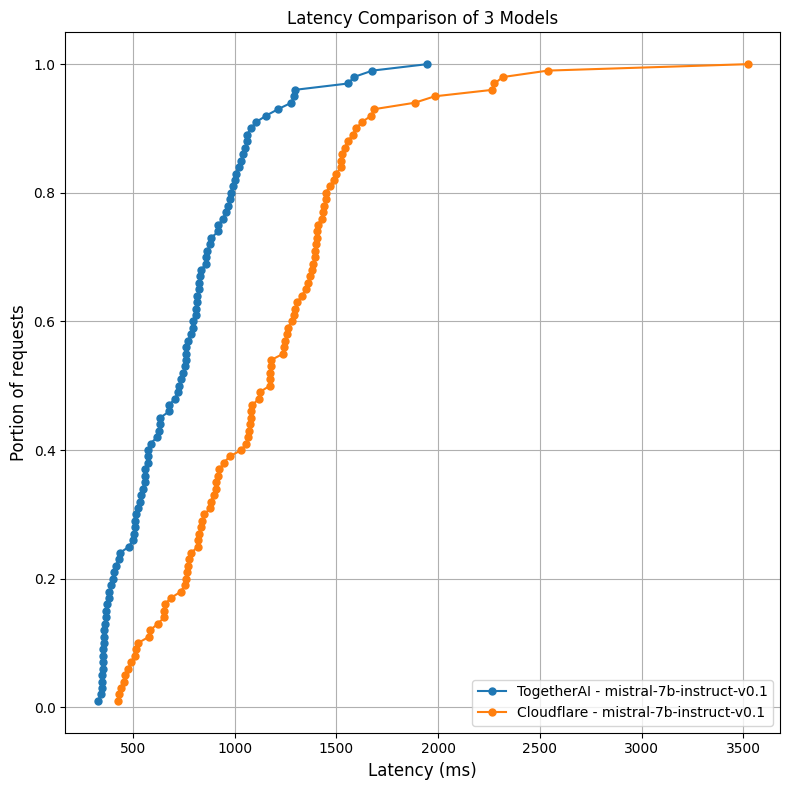

In [20]:
b.plot_metrics(b.timetofirsttoken)

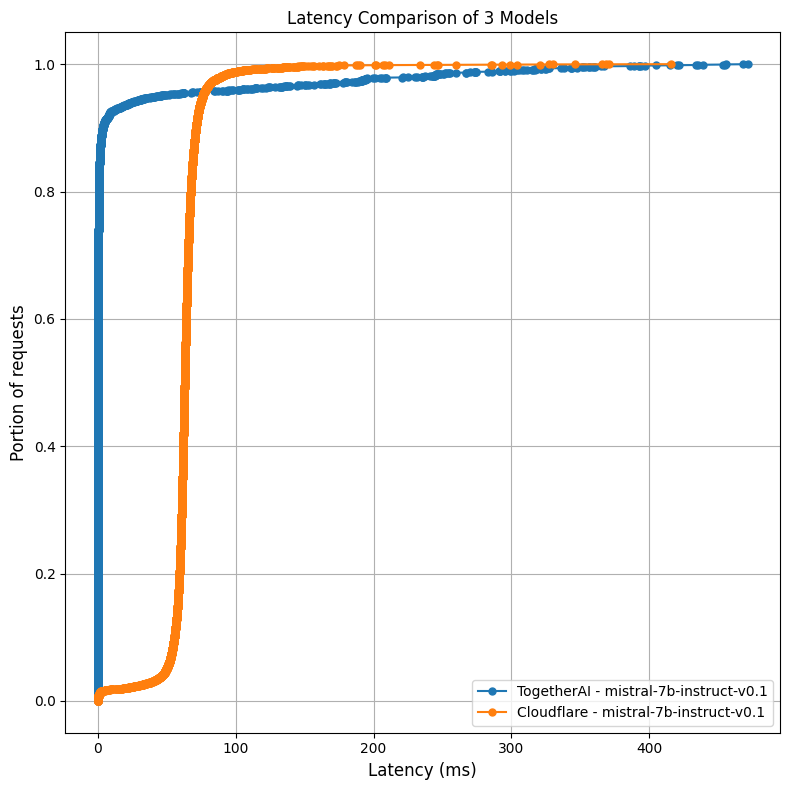

In [21]:
# Time between tokens
b.plot_metrics(b.timebetweentokens)

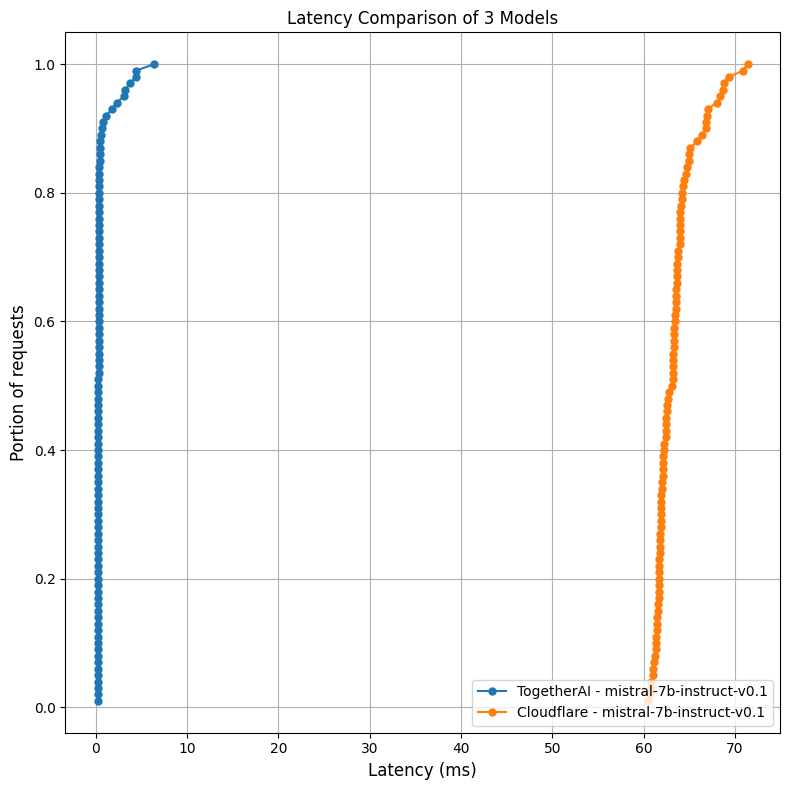

In [22]:
b.plot_metrics(b.timebetweentokens_median)

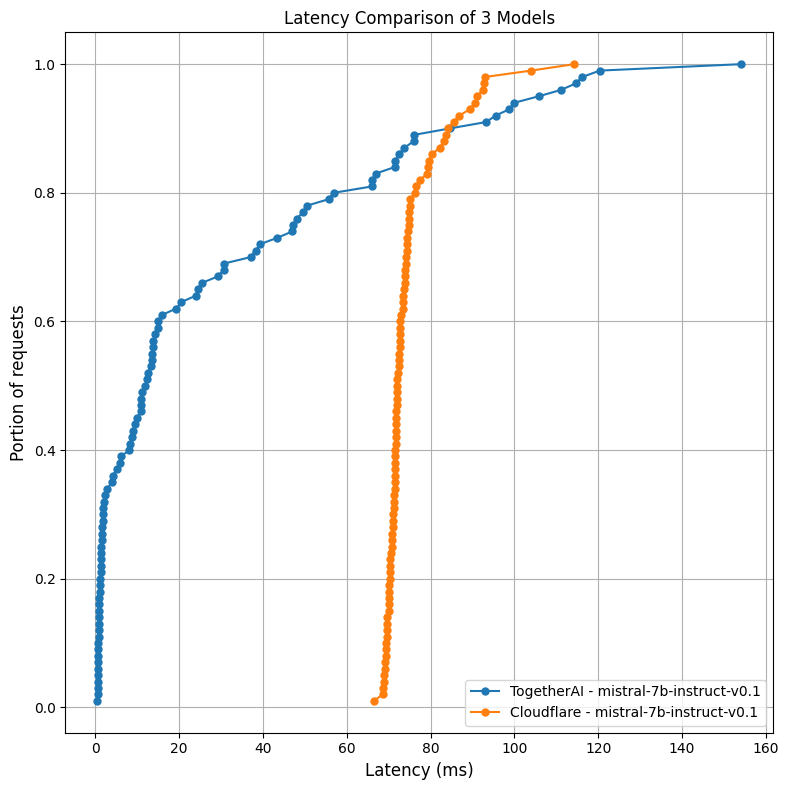

In [23]:
b.plot_metrics(b.timebetweentokens_p95)

##### TogetherAI

##### Model: google-gemma-2b-it
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.24* seconds_

Request 1

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.74* seconds_

Request 2

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.77* seconds_

Request 3

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.76* seconds_

Request 4

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.84* seconds_

Request 5

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.75* seconds_

Request 6

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.97* seconds_

Request 7

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.77* seconds_

Request 8

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.74* seconds_

Request 9

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.86* seconds_

Request 10

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *2.30* seconds_

Request 11

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.88* seconds_

Request 12

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.92* seconds_

Request 13

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.78* seconds_

Request 14

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.92* seconds_

Request 15

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.78* seconds_

Request 16

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.95* seconds_

Request 17

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.76* seconds_

Request 18

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.98* seconds_

Request 19

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.77* seconds_

Request 20

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.90* seconds_

Request 21

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.76* seconds_

Request 22

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *2.00* seconds_

Request 23

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.75* seconds_

Request 24

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.99* seconds_

Request 25

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.76* seconds_

Request 26

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.74* seconds_

Request 27

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.75* seconds_

Request 28

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.87* seconds_

Request 29

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.81* seconds_

Request 30

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *2.12* seconds_

Request 31

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.77* seconds_

Request 32

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *2.03* seconds_

Request 33

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.80* seconds_

Request 34

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.93* seconds_

Request 35

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.75* seconds_

Request 36

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.88* seconds_

Request 37

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.75* seconds_

Request 38

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.93* seconds_

Request 39

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.78* seconds_

Request 40

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.87* seconds_

Request 41

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.81* seconds_

Request 42

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.83* seconds_

Request 43

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.74* seconds_

Request 44

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *2.04* seconds_

Request 45

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.77* seconds_

Request 46

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.98* seconds_

Request 47

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.76* seconds_

Request 48

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *1.99* seconds_

Request 49

* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### _Generated in *0.78* seconds_

##### Model: mistral-7b-instruct-v0.1
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.83* seconds_

Request 1

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *2.53* seconds_

Request 2

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.40* seconds_

Request 3

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.31* seconds_

Request 4

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.84* seconds_

Request 5

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.83* seconds_

Request 6

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *2.19* seconds_

Request 7

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.91* seconds_

Request 8

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.14* seconds_

Request 9

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.47* seconds_

Request 10

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.22* seconds_

Request 11

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.99* seconds_

Request 12

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.11* seconds_

Request 13

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.96* seconds_

Request 14

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.07* seconds_

Request 15

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.21* seconds_

Request 16

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.23* seconds_

Request 17

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.93* seconds_

Request 18

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.95* seconds_

Request 19

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.08* seconds_

Request 20

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.78* seconds_

Request 21

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.45* seconds_

Request 22

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.68* seconds_

Request 23

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.89* seconds_

Request 24

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.02* seconds_

Request 25

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *2.09* seconds_

Request 26

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.13* seconds_

Request 27

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.90* seconds_

Request 28

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.13* seconds_

Request 29

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.26* seconds_

Request 30

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.85* seconds_

Request 31

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.45* seconds_

Request 32

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.83* seconds_

Request 33

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.78* seconds_

Request 34

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *2.24* seconds_

Request 35

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *0.79* seconds_

Request 36

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *2.44* seconds_

Request 37

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.25* seconds_

Request 38

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.95* seconds_

Request 39

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.50* seconds_

Request 40

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's winding path, enjoy the views of the city, and explore the various gardens, art installations, and food vendors along the way.

##### _Generated in *1.22* seconds_

Request 41

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.05* seconds_

Request 42

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.98* seconds_

Request 43

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.18* seconds_

Request 44

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.14* seconds_

Request 45

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *1.08* seconds_

Request 46

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.50* seconds_

Request 47

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.99* seconds_

Request 48

 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### _Generated in *0.93* seconds_

Request 49

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's gardens, art installations, and stunning views of the city.

##### _Generated in *1.28* seconds_

##### Model: meta-llama-3.1-70b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *2.39* seconds_

Request 1

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.81* seconds_

Request 2

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *2.60* seconds_

Request 3

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.98* seconds_

Request 4

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *2.23* seconds_

Request 5

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *2.71* seconds_

Request 6

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.94* seconds_

Request 7

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *2.87* seconds_

Request 8

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.71* seconds_

Request 9

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *2.62* seconds_

Request 10

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.85* seconds_

Request 11

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *2.15* seconds_

Request 12

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *3.20* seconds_

Request 13

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.48* seconds_

Request 14

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *2.03* seconds_

Request 15

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *3.02* seconds_

Request 16

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.48* seconds_

Request 17

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *2.10* seconds_

Request 18

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *2.48* seconds_

Request 19

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *2.81* seconds_

Request 20

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *2.17* seconds_

Request 21

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.82* seconds_

Request 22

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *3.20* seconds_

Request 23

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.57* seconds_

Request 24

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.97* seconds_

Request 25

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *3.00* seconds_

Request 26

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *2.01* seconds_

Request 27

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.34* seconds_

Request 28

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.67* seconds_

Request 29

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.54* seconds_

Request 30

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.71* seconds_

Request 31

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *3.01* seconds_

Request 32

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *2.55* seconds_

Request 33

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *3.28* seconds_

Request 34

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *2.43* seconds_

Request 35

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *2.39* seconds_

Request 36

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.83* seconds_

Request 37

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *3.02* seconds_

Request 38

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *2.85* seconds_

Request 39

One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### _Generated in *2.08* seconds_

Request 40

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.84* seconds_

Request 41

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.44* seconds_

Request 42

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.97* seconds_

Request 43

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.49* seconds_

Request 44

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.99* seconds_

Request 45

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *2.38* seconds_

Request 46

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.57* seconds_

Request 47

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.62* seconds_

Request 48

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *1.94* seconds_

Request 49

One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### _Generated in *2.76* seconds_

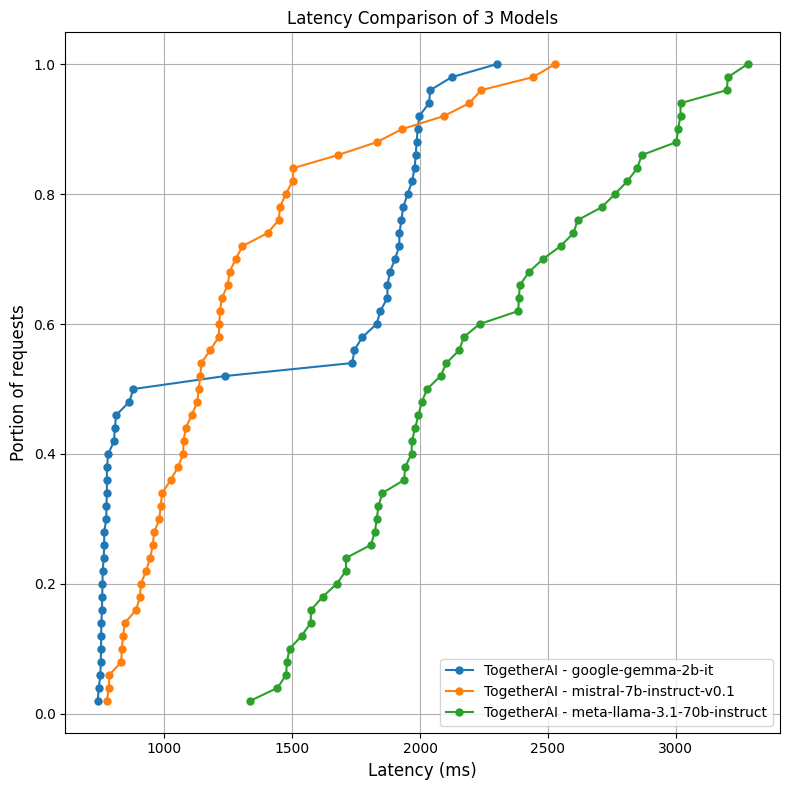

In [25]:
# End to end response times for each provider, 3 different models
prompt = "What are some fun things to do in New York? Give me 1 short example."
models = ["google-gemma-2b-it", "mistral-7b-instruct-v0.1", "meta-llama-3.1-70b-instruct"]

b = Benchmark([TogetherAI()], 50, models=models, prompt=prompt)
b.run()
b.plot_metrics(b.response_times)

In [26]:
# End to end response times for each provider, 3 different models
prompt = "What are some fun things to do in New York? Give me 1 short example."
models = ["google-gemma-2b-it", "mistral-7b-instruct-v0.1", "meta-llama-3.1-70b-instruct"]

b = Benchmark([Cloudflare()], 50, models=models, prompt=prompt)
b.run()
b.plot_metrics(b.response_times)

##### Cloudflare

##### Model: google-gemma-2b-it
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

Sure, here’s a fun short example:

**Example:** Take a stroll down the High Line, a beautiful elevated park built on an old freight rail line. Enjoy the views of the city and relax in this unique and urban oasis.

#### _Generated in *2.70* seconds_

Request 1

Visiting the Top of the Rock for breathtaking panoramas of the city.

Enjoy an evening stroll across the Brooklyn Bridge, soaking in the vibrant ambiance.

#### _Generated in *2.08* seconds_

Request 2

Taking a Peddle-Scoop boat tour through Central Park is a fun and relaxing way to experience the city like a local.

#### _Generated in *1.44* seconds_

Request 3

Sure! Here's a fun activity: Take a boat tour through the East River, enjoying stunning views of Manhattan along the way.

#### _Generated in *1.57* seconds_

Request 4

Sampling a flavor-packed slice of pizza cooked in a wood-fired oven in Little Italy.

#### _Generated in *1.56* seconds_

Request 5

Sure, here's a fun example of an activity that you could do in New York:

**Example:** Take a walk through Central Park and explore the Bethesda Fountain. You can also check out the nearby Castle Cloisters, a stunning Gothic cloister located on the banks of the Hudson River.

#### _Generated in *2.45* seconds_

Request 6

**Example:** Take a free walking tour of Central Park and learn interesting facts about the park and its inhabitants.

#### _Generated in *1.96* seconds_

Request 7

Sure! Here's a fun activity to try in New York City; visit the Top of the Rock at Rockefeller Center for breathtaking city views.

#### _Generated in *1.56* seconds_

Request 8

Sure, here's a fun suggestion:

**Visit the Roosevelt Island Tramway for stunning views of the Manhattan skyline**. 

This is a great way to experience the vibrant energy of New York City while enjoying a unique perspective of the city.

#### _Generated in *2.55* seconds_

Request 9

Sure! Here's a short example of fun things to do in New York City:

**Example:** Explore the vibrant and diverse neighborhood of Greenwich Village by taking a stroll down Bleecker Street, visiting Washington Square Park, and admiring the iconic landmarks like the Statue of Liberty and the Brooklyn Bridge.

#### _Generated in *2.32* seconds_

Request 10

Sure, here's a suggestion:

**Explore the bustling Times Square and soak in the vibrant atmosphere.** The dazzling lights, live performances, and street performers will take your breath away.

#### _Generated in *1.72* seconds_

Request 11

Sure, here's a fun activity you can do in New York City: Visit the Brooklyn Botanic Garden and admire the beautiful collection.

#### _Generated in *1.68* seconds_

Request 12

Ride the Staten Island Ferry for stunning views of the Manhattan skyline and the Statue of Liberty and Ellis Island.

This is just one example, there are many activities to explore in New York City.

#### _Generated in *2.30* seconds_

Request 13

* Take a stroll down the High Line, a charming elevated park built on an historic rail line. For example, enjoying the view at sunset is a popular highlight.

#### _Generated in *2.14* seconds_

Request 14

Take a stroll through Central Park and witness the Bethesda Fountain ballet as it ripples and dances.

#### _Generated in *1.74* seconds_

Request 15

Sure, here's a fun idea: Visit the 9/11 Memorial & Museum and learn about the tragic events of September 11th, 2001.

#### _Generated in *2.05* seconds_

Request 16

**Example:** Visiting the Rockefeller Center Christmas tree for the spectacular holiday lights display.

**Other fun activities:**

* Take a stroll through Central Park, the tranquil heart of Manhattan.
* Visit the Metropolitan Museum of Art for a world-class art experience.
* Catch a Broadway show for a taste of the dazzling cityscape.
* Explore the vibrant neighborhoods of Greenwich Village and SoHo.
* Visit the iconic Statue of Liberty and Ellis Island for stunning views of the city.
* Take a culinary tour and sample the diverse cuisine of NYC.
* Experience an immersive adventure in Times Square's spectacular displays.
* Enjoy the city skyline from the High Line, a raised park in the heart of Manhattan.
* Listen to live music in Washington Square Park or other iconic venues.
* Visit the 9/11 Memorial & Museum to pay tribute to the victims and heroes of that tragic day.

#### _Generated in *5.05* seconds_

Request 17

Sure, here's a fun example:

Visit the Brooklyn Bridge Park and take a ferry to Governor's Island. You can enjoy stunning views of Manhattan, the Brooklyn Bridge, and the East River.

#### _Generated in *2.11* seconds_

Request 18

**Example:** Join a free on-site yoga session in Bryant Park, led by a professional instructor.

#### _Generated in *1.04* seconds_

Request 19

Sure, here's a fun idea. Visit Times Square and catch a free light show every night. Another exciting thing to do is explore all the different boroughs of Manhattan. You can visit different neighborhoods like Greenwich Village, Brooklyn Heights, and Lower Manhattan.

#### _Generated in *2.11* seconds_

Request 20

Sure, here's a fun activity:

* **Visit the Empire State Building**: Enjoy stunning city skyline views from atop this iconic landmark with a hop-on hop-off bus tour.

#### _Generated in *1.87* seconds_

Request 21

Try your luck at Coney Island amusement park. One of the most popular attractions features a giant roller coaster called Thunderbolt that offers stunning views of the city and ocean.

#### _Generated in *1.55* seconds_

Request 22

Sure, here's a fun activity idea:
- Take a fun troll tour around Greenwich Village. The tour provides info and wacky photographic moments.

#### _Generated in *1.68* seconds_

Request 23

Sure! Here are a few fun things to do in New York City: 

* Visit the Top of the Rock for stunning panoramic views of the city. 

You can also enjoy the different activities offered by Top of the Rock, including live entertainment, a museum, and a bar.

#### _Generated in *2.07* seconds_

Request 24

Visit the Vessel in Hudson Yards, a floating cultural institution with a rotating lineup of exhibitions.

**Example:** You could take a free walking tour of Central Park, learning about the park's history and hidden gems.

#### _Generated in *1.58* seconds_

Request 25

**Example:** Take a **FOOD TOUR OF THE Meatpacking District**, where you'll indulge in various bites from hot dogs to delis to diverse international cuisine.

#### _Generated in *1.37* seconds_

Request 26

Visit the Metropolitan Museum of Art and admire the incredible collection of art from all over the world.

Or, take a walk down Times Square and experience the vibrant atmosphere of one of the world's most famous locations.

#### _Generated in *2.03* seconds_

Request 27

Visiting the High Line park in Lower Manhattan and enjoying its unique elevated garden and public art installations.

#### _Generated in *1.91* seconds_

Request 28

Going on a free walking tour of Central Park. A guided tour will give you a deeper understanding of the park's history and culture, as well as fascinating stories about the people who have walked there.

#### _Generated in *1.68* seconds_

Request 29

**Example:** Take a walk across the Brooklyn Bridge for stunning views and a dose of urban adventure.

#### _Generated in *1.92* seconds_

Request 30

Sure, here's a fun idea to do in New York: Take a comedy walking tour in Greenwich Village. This tour will showcase the historic and humorous side of New York City through a mixture of classic and current jokes about the city's culture, life, and history.

#### _Generated in *2.93* seconds_

Request 31

Sure, here's an example of a fun thing to do in New York:

**Go on a Comedy Cellar Tour**: Join a comedian on an intimate, engaging tour of the legendary comedy clubs in the city. You'll get to experience the stand-up magic of a seasoned professional and hear their infectious jokes in a small, intimate setting.

#### _Generated in *2.56* seconds_

Request 32

Sure, here are some fun things to do in New York City:

* **Visit Brooklyn Bridge Park:** Enjoy breathtaking panoramic views of Manhattan and the Brooklyn Bridge. 

* **Explore The High Line:** Take a leisurely stroll through this elevated park built on an old railway line.

#### _Generated in *1.96* seconds_

Request 33

Visiting the Top of the Rock for stunning city views is a great fun activity.

#### _Generated in *1.20* seconds_

Request 34

Join a masked ball masked ball in Greenwich Village—a night of mystery and intrigue where attendees dress up and solve riddles.

#### _Generated in *1.17* seconds_

Request 35

Sure, here's a fun activity:

**Visit Times Square at Night:** At midnight every night, Times Square transforms into a dazzling wonderland of glowing billboards, dazzling lights, and lively street performers.  Take in the sights and sounds of this vibrant cityscape and soak in the vibrant atmosphere.

#### _Generated in *2.33* seconds_

Request 36

One fun thing to do in New York City is take a walk across the Brooklyn Bridge. The views from Brooklyn Bridge are incredible, and it's a great place to people-watch.

#### _Generated in *2.33* seconds_

Request 37

Take a ride on the Staten Island Ferry for stunning views of the Manhattan skyline and to explore the Staten Island Zoo.

#### _Generated in *1.35* seconds_

Request 38

A fun example of an activity in New York City is visiting The High Line, a converted railway line transformed into a lush park with gardens, attractions, and a street performers stage.

#### _Generated in *1.66* seconds_

Request 39

One fun thing to do in New York is explore Central Park, which offers a variety of attractions and activities such as boating, horses-drawn carriage rides, picnicking, and visiting different museums and gardens.

#### _Generated in *1.88* seconds_

Request 40

Sure! Here is a fun example:

* **Take a stroll through Central Park**: Enjoy the sprawling green space and all the activities it offers, including watching a performance, visiting museums, or simply relaxing on a bench and enjoying the views.

#### _Generated in *2.36* seconds_

Request 41

Sure, here's a fun activity: Spend an afternoon wandering around Greenwich Village and soaking in the sights and sounds of street performers.

#### _Generated in *1.44* seconds_

Request 42

Visit the Metropolitan Museum of Art's immersive digital exhibit "The MetXR." This interactive space allows visitors to virtually walk through different galleries of the museum.

#### _Generated in *1.40* seconds_

Request 43

Sure! Here's a fun idea:

**Visit Brooklyn Bridge Park:** Take in breathtaking panoramic views of Manhattan as you stroll across the iconic Brooklyn Bridge.

#### _Generated in *1.58* seconds_

Request 44

Sure, here's an example of a fun thing to do in New York City:

**Visit the Top of the Rock and take in panoramic views of the city.** This iconic landmark offers spectacular views of the city below, or you can enjoy a meal with skyline views at The Rainbow Room.

#### _Generated in *2.28* seconds_

Request 45

Running through Central Park with an umbrella makes for a delightful and unique way to explore the city.

#### _Generated in *2.10* seconds_

Request 46

Enjoy a panoramic view of the city from the Top of the Rock observation deck. Imagine yourself gazing out at Central Park Park below – just a short walk away.

#### _Generated in *1.60* seconds_

Request 47

Sure, here are some fun things to do in New York City:

- Visit the Empire State Building at sunset for breathtaking panoramic views of the city.

#### _Generated in *1.99* seconds_

Request 48

Catching a Broadway show is a classic New York experience. For an adventurous option, explore the Harlem neighborhood and enjoy live jazz or immerse yourself in the vibrant street art scene in Brooklyn.

#### _Generated in *1.61* seconds_

Request 49

**Example:** Take a spooky late-night stroll through the Little Italy neighborhood, where you can hear live music and watch performers morbidly reenact scenes from famous murders.

#### _Generated in *1.98* seconds_

##### Model: mistral-7b-instruct-v0.1
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

 One fun and iconic activity to do in New York is taking a stroll through Central Park. In the heart of the city, Central Park offers a variety of attractions, from renting a rowboat on The Lake, visiting the Central Park Zoo, exploring the Alice in Wonderland statue and the Bethesda Terrace and Fountain, or just enjoying a picnic and people-watching. It's an excellent way to experience some green space and relaxation amidst the bustling city life. Plus, you may even catch a free performances by street musicians or impromptu dance troupes!

#### _Generated in *8.33* seconds_

Request 1

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can take in breathtaking views of the city from an observatory level, as well as an outdoor terrace. You can also time your visit to see the famous Rockettes Christmas Spectacular show during the holiday season. It's a great way to experience the excitement and beauty of New York City.

#### _Generated in *6.58* seconds_

Request 2

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Not only can you enjoy stunning views of the city from three different levels, but you can also take in the breathtaking view of the famous New York City skyline and Central Park. Plus, it's open late into the night, so you can experience the dazzling city lights. Additionally, during the holiday season, the observation deck offers a breathtaking view of the Rockefeller Center Christmas Tree!

#### _Generated in *8.06* seconds_

Request 3

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Not only can you enjoy breathtaking views of the city, but you can also experience it during different times of the day or even at night, when the city is beautifully lit up. Plus, it's less crowded than the Statue of Liberty or the Empire State Building's observatory, making for a more enjoyable experience. Additionally, the location is convenient and easily accessible via public transportation.

#### _Generated in *7.66* seconds_

Request 4

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the city's skyline and landmarks such as Central Park, Times Square, and the Statue of Liberty. You can enjoy this experience anytime during the day, but watching the sunset or the city lit up at night is truly magnificent. Additionally, you may even spot some famous buildings and movie sites from various films and TV shows. It's an experience that every New York visitor should have on their list!

#### _Generated in *8.19* seconds_

Request 5

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center for breathtaking views of the city's skyline and landmarks. During the day, you can see Central Park, Times Square, and the sprawling urban landscape. At night, the city comes alive with twinkling lights, making for an unforgettable view. Additional activities include exploring the diverse neighborhoods like Chinatown or Little Italy, taking a stroll through Central Park, catching a Broadway show, or visiting famous museums like the Metropolitan Museum of Art or the Museum of Modern Art.

#### _Generated in *9.51* seconds_

Request 6

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city from an elevation of 70 stories high. You can enjoy panoramic vistas of Central Park, Times Square, the Empire State Building, and other landmarks. Additionally, the observation deck is open late into the night, providing a stunning view of the city lights. Shortly put, experiencing the breathtaking view of New York City from Top of the Rock is a must-do.

#### _Generated in *8.09* seconds_

Request 7

 New York City is known for its vibrant energy and endless entertainment options. Here's a short example of a fun activity:

Visit the Top of the Rock Observation Deck at Rockefeller Center for breathtaking views of the city. Take an elevator up to the 70th floor to enjoy panoramic views of the iconic New York City skyline, Central Park, and the bustling city below. Once you reach the top, take your time to soak in the stunning vistas, whether it be during the day or at sunset. For an extra thrill, opt for the Sunset Experience, which includes access to the observation deck an hour before it opens to the public, allowing you to witness the breathtaking sunset over the city in peace and tranquility.

#### _Generated in *11.38* seconds_

Request 8

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including the famous Central Park, the Empire State Building, and the Hudson River. You can enjoy this experience during the day or at night when the city is beautifully lit up. Additionally, there's a great photo opportunity with the legendary "I ❤ NY" sign located just a short walk away. It's a must-do for both first-time visitors and locals alike.

#### _Generated in *8.23* seconds_

Request 9

 New York City offers a varyingly exciting and overwhelming array of activities for visitors. One fun and relatively short experience could be a visit to the Top of the Rock Observation Deck at Rockefeller Center.here, you can enjoy breathtaking views of the city's iconic skyline, Central Park, and the bustling streets below. The observation deck is open seven days a week, and the best time to visit for views unobstructed by fog or smog is typically early in the morning or late in the afternoon. Keep in mind that there may be lines, especially during peak tourist season, so planning ahead and purchasing tickets online can help save time. The experience of taking in the vastness of New York City from above is truly unique and memorable.

#### _Generated in *11.87* seconds_

Request 10

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. After taking the elevator to the 70th floor, you'll be treated to breathtaking panoramic views of the city. The observation deck offers a 360-degree perspective, allowing you to see famous landmarks like Central Park, Times Square, and the majestic skyline. In the evening, the city comes alive with twinkling lights, making for a truly magical experience. You can also visit during the day for stunning views of the bustling metropolis.

#### _Generated in *9.57* seconds_

Request 11

 New York City offers a vast array of fun and exciting activities for visitors. One short example of a fun activity is taking a stroll through Central Park. This iconic urban park in the heart of Manhattan is perfect for enjoying a sunny day. You can rent a bike or a rowboat, take a leisurely walk, or even go for a run. Don't forget to stop and take some photos with the famous Central Park landmarks, such as the Bethesda Fountain and the Bow Bridge. Central Park is also home to numerous events, festivals, and concerts throughout the year, so be sure to check the schedule and plan your visit accordingly.

#### _Generated in *9.59* seconds_

Request 12

 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a rowboat and paddle around the lake, hire a bike and explore the park's winding paths, or simply relax on a blanket and enjoy a picnic. Central Park offers many opportunities to enjoy nature in the heart of the city, and it's a must-visit destination for anyone traveling to New York. Plus, you might even spot a celebrity or two!

#### _Generated in *7.23* seconds_

Request 13

 New York City is known for its vibrant energy and endless list of attractions. One fun and short activity you can do is visiting the High Line, an elevated park built on an old railway line. Stroll through the gardens, take in the stunning views of the city and the Hudson River, and discover various art installations along the way. Don't forget to check out the unique shops and restaurants near the park!

#### _Generated in *5.79* seconds_

Request 14

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center for breathtaking views of the city. You can observe the stunning skyline, Central Park, and even the Statue of Liberty on a clear day. Plus, it's open later hours than the observation deck at the Empire State Building, allowing for beautiful sunset views. Afterward, you can explore the surrounding area, shop at the nearby stores, or grab a bite to eat at one of the many restaurants in the area.

#### _Generated in *8.99* seconds_

Request 15

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. You can enjoy breathtaking views of the city from the indoor and outdoor observatory on the 70th floor. sensitive_after_1_day post understand-skin-painting

Additionally, the Rockefeller Center area is home to numerous shops, restaurants, and the famous ice-skating rink. It's a great place to explore and experience the energy of New York City. fun_factor encyclopedic_knowledge travel_and_places tourism_and_hospitality entertainment_and_music culture_and_education list_item

Take in the stunning views of the city's skyline, landmarks such as Central Park and the Empire State Building, and enjoy the vibrant atmosphere. children_playing excitement_and_interest memorable_experience tourist_attractions new_york_city sightseeing travel. Tips: Go early in the morning or late in the day to avoid crowds, and don't forget your camera! smile happy_face_with_raising_hands attention_to_detail thank_you_note contribution_acknowledgment.

#### _Generated in *18.18* seconds_

Request 16

 New York City is known for its vibrant energy and endless possibilities for entertainment. One fun and short activity you could do is visiting the High Line, an elevated public park built on a former railway line. The High Line offers stunning views of the city, unique public art installations, and a variety of food vendors and small gardens. Strolling through the park on a sunny day, enjoying the fresh air and beautiful scenery, is a great way to experience New York's unique charm in a short amount of time.

#### _Generated in *7.34* seconds_

Request 17

 One fun and short activity to do in New York is visiting the High Line, an elevated park built on a former railway line. Stroll through the greenery, enjoy the stunning views of the city and the Hudson River, and discover unique public art installations along the way. Don't forget to grab a bite or a drink at one of the many nearby cafes or restaurants!

#### _Generated in *6.04* seconds_

Request 18

 New York City offers a vast array of fun activities for visitors. One short example of an enjoyable experience is taking a stroll through Central Park. Different seasons bring unique charms to the park, but no matter when you visit, there's always something exciting to discover. Enjoy a leisurely walk, rent a rowboat or bike, visit the Central Park Zoo, or relax in the Sheep Meadow. Don't forget to take a picture in front of the iconic Bow Bridge or Bethesda Fountain. Central Park is more than just a park – it's an essential part of the New York City experience.

#### _Generated in *8.96* seconds_

Request 19

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. You can take an elevator ride up to the observation deck on the 70th floor for stunning views of the city. It offers a breathtaking panorama of Manhattan, including Central Park, the Empire State Building, Times Square, and the Statue of Liberty (on a clear day). The expansive view of the city's skyline and its vibrant energy is truly a must-see experience. Plus, it's open late, so you can enjoy the views at sunset or even at night when the city is beautifully lit up.

#### _Generated in *10.26* seconds_

Request 20

 One fun and iconic thing to do in New York is to take a stroll through Central Park. In the heart of the city, Central Park offers a refreshing escape from the hustle and bustle. You can rent a rowboat and paddle around the lake, rent a bike to explore the park's many twisting paths, or simply relax on a blanket and enjoy a picnic. Keep an eye out for street performers, musicians, and other entertaining acts along the way. Central Park is truly a must-visit attraction for any New York City traveler!

#### _Generated in *9.52* seconds_

Request 21

 New York City offers a wide range of fun and exciting activities for visitors. Here's a short example of a fun activity:

Take a stroll through Central Park and visit the Central Park Zoo. Central Park is a must-visit destination in New York City, and a leisurely walk through its scenic paths is a great way to enjoy the beauty of nature in the heart of the city. The Central Park Zoo is a great addition to a walk through the park. Home to over 130 species of animals, including penguins, seals, and red pandas, the zoo is a fascinating place to explore and learn about wildlife. Plus, the zoo is relatively small, making it a perfect activity for families or those short on time. After your visit, grab a hot dog from a street vendor or have a picnic in the park to make it a truly New York experience!

#### _Generated in *12.34* seconds_

Request 22

 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a rowboat or a bike, have a picnic, see the Central Park Zoo, or just enjoy the beautiful scenery and people-watching. In the summer months, you might even catch a free concert in the park! It's a great way to experience the natural beauty in the midst of the bustling city.

#### _Generated in *6.75* seconds_

Request 23

 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a bike, have a picnic, visit the Central Park Zoo, or even go for a boat ride in the Lake. In the summer, you can enjoy free concerts and movies in the park. In the winter, you can ice-skate on the Wollman Rink. Central Park is a must-see attraction that offers something for everyone throughout the year.

#### _Generated in *7.50* seconds_

Request 24

 Absolutely! New York City is known for its diversity and endless entertainment options. One fun and short activity that I'd recommend is a visit to the High Line. The High Line is an elevated park built on an old railway line, offering stunning views of the city and the Hudson River. You can take a leisurely stroll along the park, enjoy the art installations, and take in the beautiful views of the city. Additionally, there are numerous food vendors and restaurants nearby, making for a perfect afternoon outing.

#### _Generated in *7.82* seconds_

Request 25

 One fun and short activity to do in New York is visiting the High Line, an elevated park built on an old railroad track. Stroll through the beautiful gardens, take in the unique views of the city, and enjoy various public art installations. It's a great way to experience New York's history and natural beauty in one place. (Short example: Spend an hour exploring the High Line and taking in the city views.)

#### _Generated in *8.00* seconds_

Request 26

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including Central Park, Times Square, and the Statue of Liberty (on a clear day). You can also time your visit to see the sunset or enjoy the city lights at night. It's a great experience for both tourists and locals alike!

#### _Generated in *7.22* seconds_

Request 27

 One fun and iconic activity to do in New York is taking a stroll through Central Park, especially during the spring and summer seasons. You can rent a rowboat or a bike, have a picnic, visit the Central Park Zoo, or simply enjoy the beautiful scenery and people-watching. Don't forget to stop by the famous Bow Bridge for a picture!

#### _Generated in *6.66* seconds_

Request 28

 One fun and iconic activity to do in New York is taking a stroll through Central Park. MIT Technology Review called Central Park the "most used park in the world," and for good reason. There's something for everyone: scenic walking paths, bike rentals, boating, theatre, and even a zoo. You can pack a lunch, rent a rowboat, or simply relax on a bench and people-watch. It's a great way to enjoy the beauty of nature amidst the hustle and bustle of the city.

#### _Generated in *7.79* seconds_

Request 29

 Absolutely! New York City offers a wide range of fun activities. Here's a short example:

Visit the Top of the Rock Observation Deck:
Experience breathtaking views of the city that never sleeps! Take an elevator ride up to the Top of the Rock Observation Deck at Rockefeller Center. This popular tourist destination provides panoramic views of Manhattan and the surrounding boroughs. During the day, you can see Central Park, iconic skyscrapers, and the bustling city streets. In the evening, prepare to be dazzled by the twinkling city lights. Don't forget to bring your camera to capture these memorable moments!

#### _Generated in *10.25* seconds_

Request 30

 New York City offers a vast array of fun and exciting activities for visitors! One short example is taking a stroll through Central Park. Explore the beautiful gardens, lakes, and historic landmarks, such as Bethesda Terrace and the Belvedere Castle. Rent a bicycle or a rowboat, or simply relax with a picnic. Central Park is sure to provide you with a memorable experience in the heart of the city.

#### _Generated in *6.37* seconds_

Request 31

 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. You can enjoy breathtaking views of the city, including Central Park and the world-famous skyline. It's open year-round, and the hours vary, so be sure to check their website for the most up-to-date information. During the holidays, the observation deck offers even more magical views with its stunning light displays. A visit to the Top of the Rock is an experience that will leave you with memories to last a lifetime!

#### _Generated in *9.46* seconds_

Request 32

KeyboardInterrupt: 

In [27]:
# TTFT and TBT also do for 3 different models
# End to end response times for each provider, 3 different models
prompt = "What are some fun things to do in New York? Give me 1 short example."
models = ["google-gemma-2b-it", "mistral-7b-instruct-v0.1", "meta-llama-3.1-70b-instruct"]

b = Benchmark([TogetherAI()], 50, models=models, prompt=prompt, streaming=True)
b.run()

##### TogetherAI

##### Model: google-gemma-2b-it
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 0.3828 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8187 seconds

##### Number of output tokens/chunks: 50

Request 1

##### Time to First Token (TTFT): 0.8386 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.1826 seconds

##### Number of output tokens/chunks: 50

Request 2

##### Time to First Token (TTFT): 0.3621 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8711 seconds

##### Number of output tokens/chunks: 50

Request 3

##### Time to First Token (TTFT): 0.3489 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.7840 seconds

##### Number of output tokens/chunks: 50

Request 4

##### Time to First Token (TTFT): 1.8519 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 2.2602 seconds

##### Number of output tokens/chunks: 50

Request 5

##### Time to First Token (TTFT): 0.7580 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.3012 seconds

##### Number of output tokens/chunks: 50

Request 6

##### Time to First Token (TTFT): 0.3528 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8117 seconds

##### Number of output tokens/chunks: 50

Request 7

##### Time to First Token (TTFT): 0.3746 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8139 seconds

##### Number of output tokens/chunks: 50

Request 8

##### Time to First Token (TTFT): 1.8336 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 2.2956 seconds

##### Number of output tokens/chunks: 50

Request 9

##### Time to First Token (TTFT): 0.4933 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8391 seconds

##### Number of output tokens/chunks: 50

Request 10

##### Time to First Token (TTFT): 1.9448 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 2.4348 seconds

##### Number of output tokens/chunks: 50

Request 11

##### Time to First Token (TTFT): 0.4949 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.0484 seconds

##### Number of output tokens/chunks: 50

Request 12

##### Time to First Token (TTFT): 1.4833 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.9648 seconds

##### Number of output tokens/chunks: 50

Request 13

##### Time to First Token (TTFT): 0.3505 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8512 seconds

##### Number of output tokens/chunks: 50

Request 14

##### Time to First Token (TTFT): 0.9531 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.4070 seconds

##### Number of output tokens/chunks: 50

Request 15

##### Time to First Token (TTFT): 0.4130 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.7912 seconds

##### Number of output tokens/chunks: 50

Request 16

##### Time to First Token (TTFT): 1.5388 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.9964 seconds

##### Number of output tokens/chunks: 50

Request 17

##### Time to First Token (TTFT): 0.3664 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8145 seconds

##### Number of output tokens/chunks: 50

Request 18

##### Time to First Token (TTFT): 1.5836 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 2.0400 seconds

##### Number of output tokens/chunks: 50

Request 19

##### Time to First Token (TTFT): 0.3517 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8026 seconds

##### Number of output tokens/chunks: 50

Request 20

##### Time to First Token (TTFT): 1.7961 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 2.2728 seconds

##### Number of output tokens/chunks: 50

Request 21

##### Time to First Token (TTFT): 0.3424 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8032 seconds

##### Number of output tokens/chunks: 50

Request 22

##### Time to First Token (TTFT): 1.8446 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 2.2830 seconds

##### Number of output tokens/chunks: 50

Request 23

##### Time to First Token (TTFT): 0.3453 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8145 seconds

##### Number of output tokens/chunks: 50

Request 24

##### Time to First Token (TTFT): 1.4535 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.9151 seconds

##### Number of output tokens/chunks: 50

Request 25

##### Time to First Token (TTFT): 0.3329 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8259 seconds

##### Number of output tokens/chunks: 50

Request 26

##### Time to First Token (TTFT): 0.8283 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.2247 seconds

##### Number of output tokens/chunks: 50

Request 27

##### Time to First Token (TTFT): 0.7601 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.2224 seconds

##### Number of output tokens/chunks: 50

Request 28

##### Time to First Token (TTFT): 0.3424 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.7943 seconds

##### Number of output tokens/chunks: 50

Request 29

##### Time to First Token (TTFT): 0.3376 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8003 seconds

##### Number of output tokens/chunks: 50

Request 30

##### Time to First Token (TTFT): 1.5511 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.9860 seconds

##### Number of output tokens/chunks: 50

Request 31

##### Time to First Token (TTFT): 0.7837 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.2333 seconds

##### Number of output tokens/chunks: 50

Request 32

##### Time to First Token (TTFT): 0.3739 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.7755 seconds

##### Number of output tokens/chunks: 50

Request 33

##### Time to First Token (TTFT): 0.3560 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.7920 seconds

##### Number of output tokens/chunks: 50

Request 34

##### Time to First Token (TTFT): 1.8316 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 2.2793 seconds

##### Number of output tokens/chunks: 50

Request 35

##### Time to First Token (TTFT): 0.3629 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8220 seconds

##### Number of output tokens/chunks: 50

Request 36

##### Time to First Token (TTFT): 0.7978 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.2193 seconds

##### Number of output tokens/chunks: 50

Request 37

##### Time to First Token (TTFT): 0.3863 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8113 seconds

##### Number of output tokens/chunks: 50

Request 38

##### Time to First Token (TTFT): 1.4873 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.9257 seconds

##### Number of output tokens/chunks: 50

Request 39

##### Time to First Token (TTFT): 0.6631 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.1175 seconds

##### Number of output tokens/chunks: 50

Request 40

##### Time to First Token (TTFT): 1.6593 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 2.0264 seconds

##### Number of output tokens/chunks: 50

Request 41

##### Time to First Token (TTFT): 0.3572 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8150 seconds

##### Number of output tokens/chunks: 50

Request 42

##### Time to First Token (TTFT): 0.8661 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.2065 seconds

##### Number of output tokens/chunks: 50

Request 43

##### Time to First Token (TTFT): 0.3466 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.7888 seconds

##### Number of output tokens/chunks: 50

Request 44

##### Time to First Token (TTFT): 1.4500 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.8481 seconds

##### Number of output tokens/chunks: 50

Request 45

##### Time to First Token (TTFT): 0.7574 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.2047 seconds

##### Number of output tokens/chunks: 50

Request 46

##### Time to First Token (TTFT): 0.8092 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.2168 seconds

##### Number of output tokens/chunks: 50

Request 47

##### Time to First Token (TTFT): 0.7557 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 1.2169 seconds

##### Number of output tokens/chunks: 50

Request 48

##### Time to First Token (TTFT): 0.3576 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.8262 seconds

##### Number of output tokens/chunks: 50

Request 49

##### Time to First Token (TTFT): 0.3422 seconds


* Visit the Brooklyn Bridge Park and enjoy the views of the Manhattan skyline.

This is just one example of many fun things to do in New York City. There are always new events and activities happening, so there's something for everyone.

##### Total Response Time: 0.7921 seconds

##### Number of output tokens/chunks: 50

##### Model: mistral-7b-instruct-v0.1
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 1.5474 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 2.1121 seconds

##### Number of output tokens/chunks: 41

Request 1

##### Time to First Token (TTFT): 0.7192 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4686 seconds

##### Number of output tokens/chunks: 60

Request 2

##### Time to First Token (TTFT): 0.9526 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.5833 seconds

##### Number of output tokens/chunks: 60

Request 3

##### Time to First Token (TTFT): 0.8986 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.3086 seconds

##### Number of output tokens/chunks: 41

Request 4

##### Time to First Token (TTFT): 0.4071 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.0424 seconds

##### Number of output tokens/chunks: 60

Request 5

##### Time to First Token (TTFT): 0.9779 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.7694 seconds

##### Number of output tokens/chunks: 60

Request 6

##### Time to First Token (TTFT): 0.7102 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.1803 seconds

##### Number of output tokens/chunks: 41

Request 7

##### Time to First Token (TTFT): 0.5914 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.0600 seconds

##### Number of output tokens/chunks: 41

Request 8

##### Time to First Token (TTFT): 0.5013 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.0664 seconds

##### Number of output tokens/chunks: 41

Request 9

##### Time to First Token (TTFT): 0.4531 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.9533 seconds

##### Number of output tokens/chunks: 41

Request 10

##### Time to First Token (TTFT): 1.0181 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.5596 seconds

##### Number of output tokens/chunks: 41

Request 11

##### Time to First Token (TTFT): 1.0622 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.5430 seconds

##### Number of output tokens/chunks: 41

Request 12

##### Time to First Token (TTFT): 0.3649 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.8385 seconds

##### Number of output tokens/chunks: 41

Request 13

##### Time to First Token (TTFT): 0.8376 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.5932 seconds

##### Number of output tokens/chunks: 60

Request 14

##### Time to First Token (TTFT): 0.5919 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.9965 seconds

##### Number of output tokens/chunks: 41

Request 15

##### Time to First Token (TTFT): 0.4151 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.8576 seconds

##### Number of output tokens/chunks: 41

Request 16

##### Time to First Token (TTFT): 1.0169 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's gardens, art installations, and stunning views of the city.

##### Total Response Time: 1.6653 seconds

##### Number of output tokens/chunks: 53

Request 17

##### Time to First Token (TTFT): 0.4894 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.9980 seconds

##### Number of output tokens/chunks: 41

Request 18

##### Time to First Token (TTFT): 0.6170 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.6619 seconds

##### Number of output tokens/chunks: 60

Request 19

##### Time to First Token (TTFT): 0.5010 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.0205 seconds

##### Number of output tokens/chunks: 41

Request 20

##### Time to First Token (TTFT): 0.4146 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2072 seconds

##### Number of output tokens/chunks: 60

Request 21

##### Time to First Token (TTFT): 0.3635 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4838 seconds

##### Number of output tokens/chunks: 60

Request 22

##### Time to First Token (TTFT): 1.0769 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4862 seconds

##### Number of output tokens/chunks: 60

Request 23

##### Time to First Token (TTFT): 0.6510 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.9634 seconds

##### Number of output tokens/chunks: 60

Request 24

##### Time to First Token (TTFT): 0.3744 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.9447 seconds

##### Number of output tokens/chunks: 41

Request 25

##### Time to First Token (TTFT): 0.6467 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.1388 seconds

##### Number of output tokens/chunks: 41

Request 26

##### Time to First Token (TTFT): 0.5590 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.0118 seconds

##### Number of output tokens/chunks: 60

Request 27

##### Time to First Token (TTFT): 1.0425 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.6077 seconds

##### Number of output tokens/chunks: 41

Request 28

##### Time to First Token (TTFT): 1.1476 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can explore the gardens, art installations, and stunning views of the city while enjoying a unique and scenic experience.

##### Total Response Time: 1.7866 seconds

##### Number of output tokens/chunks: 54

Request 29

##### Time to First Token (TTFT): 0.7638 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2141 seconds

##### Number of output tokens/chunks: 60

Request 30

##### Time to First Token (TTFT): 0.4001 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.8868 seconds

##### Number of output tokens/chunks: 41

Request 31

##### Time to First Token (TTFT): 0.6234 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's winding path, enjoy the views of the city, and explore the various gardens, art installations, and food vendors along the way.

##### Total Response Time: 1.4103 seconds

##### Number of output tokens/chunks: 68

Request 32

##### Time to First Token (TTFT): 0.7590 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.2163 seconds

##### Number of output tokens/chunks: 60

Request 33

##### Time to First Token (TTFT): 0.9254 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.7916 seconds

##### Number of output tokens/chunks: 60

Request 34

##### Time to First Token (TTFT): 0.4932 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.8988 seconds

##### Number of output tokens/chunks: 41

Request 35

##### Time to First Token (TTFT): 0.3563 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8180 seconds

##### Number of output tokens/chunks: 60

Request 36

##### Time to First Token (TTFT): 1.6341 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 2.6453 seconds

##### Number of output tokens/chunks: 60

Request 37

##### Time to First Token (TTFT): 0.4452 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.9455 seconds

##### Number of output tokens/chunks: 41

Request 38

##### Time to First Token (TTFT): 0.3599 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8206 seconds

##### Number of output tokens/chunks: 60

Request 39

##### Time to First Token (TTFT): 0.8272 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4013 seconds

##### Number of output tokens/chunks: 60

Request 40

##### Time to First Token (TTFT): 0.7659 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.5528 seconds

##### Number of output tokens/chunks: 60

Request 41

##### Time to First Token (TTFT): 0.4238 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's winding path, enjoy the views of the city, and explore the various gardens, art installations, and food vendors along the way.

##### Total Response Time: 1.1224 seconds

##### Number of output tokens/chunks: 68

Request 42

##### Time to First Token (TTFT): 0.3545 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.0248 seconds

##### Number of output tokens/chunks: 60

Request 43

##### Time to First Token (TTFT): 0.7779 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.5915 seconds

##### Number of output tokens/chunks: 60

Request 44

##### Time to First Token (TTFT): 0.7226 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 1.3790 seconds

##### Number of output tokens/chunks: 41

Request 45

##### Time to First Token (TTFT): 0.7078 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.3335 seconds

##### Number of output tokens/chunks: 60

Request 46

##### Time to First Token (TTFT): 0.4962 seconds


 One fun thing to do in New York is to visit the High Line, an elevated park built on a former railroad track that offers stunning views of the city skyline and unique plant life.

##### Total Response Time: 0.9371 seconds

##### Number of output tokens/chunks: 41

Request 47

##### Time to First Token (TTFT): 0.6938 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4900 seconds

##### Number of output tokens/chunks: 60

Request 48

##### Time to First Token (TTFT): 0.8830 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's gardens, art installations, and stunning views of the city.

##### Total Response Time: 1.5471 seconds

##### Number of output tokens/chunks: 53

Request 49

##### Time to First Token (TTFT): 0.3535 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 0.8078 seconds

##### Number of output tokens/chunks: 60

##### Model: meta-llama-3.1-70b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 1.7472 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.8089 seconds

##### Number of output tokens/chunks: 47

Request 1

##### Time to First Token (TTFT): 0.8314 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 1.9367 seconds

##### Number of output tokens/chunks: 47

Request 2

##### Time to First Token (TTFT): 1.1724 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 3.5056 seconds

##### Number of output tokens/chunks: 42

Request 3

##### Time to First Token (TTFT): 1.1810 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 2.6896 seconds

##### Number of output tokens/chunks: 42

Request 4

##### Time to First Token (TTFT): 0.8200 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 1.9069 seconds

##### Number of output tokens/chunks: 47

Request 5

##### Time to First Token (TTFT): 0.9005 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 2.4986 seconds

##### Number of output tokens/chunks: 42

Request 6

##### Time to First Token (TTFT): 0.9206 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.0350 seconds

##### Number of output tokens/chunks: 47

Request 7

##### Time to First Token (TTFT): 1.7299 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 3.5648 seconds

##### Number of output tokens/chunks: 47

Request 8

##### Time to First Token (TTFT): 0.6089 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 2.0835 seconds

##### Number of output tokens/chunks: 42

Request 9

##### Time to First Token (TTFT): 1.1899 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 2.5599 seconds

##### Number of output tokens/chunks: 42

Request 10

##### Time to First Token (TTFT): 0.8723 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.1289 seconds

##### Number of output tokens/chunks: 47

Request 11

##### Time to First Token (TTFT): 0.7932 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 1.8995 seconds

##### Number of output tokens/chunks: 47

Request 12

##### Time to First Token (TTFT): 1.0766 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 2.8003 seconds

##### Number of output tokens/chunks: 42

Request 13

##### Time to First Token (TTFT): 0.7425 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 1.7910 seconds

##### Number of output tokens/chunks: 47

Request 14

##### Time to First Token (TTFT): 0.5740 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 2.0440 seconds

##### Number of output tokens/chunks: 42

Request 15

##### Time to First Token (TTFT): 0.6401 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 2.0918 seconds

##### Number of output tokens/chunks: 42

Request 16

##### Time to First Token (TTFT): 0.9321 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 1.9753 seconds

##### Number of output tokens/chunks: 47

Request 17

##### Time to First Token (TTFT): 1.3634 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 3.2575 seconds

##### Number of output tokens/chunks: 42

Request 18

##### Time to First Token (TTFT): 1.1788 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.5581 seconds

##### Number of output tokens/chunks: 47

Request 19

##### Time to First Token (TTFT): 0.6947 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 1.7827 seconds

##### Number of output tokens/chunks: 47

Request 20

##### Time to First Token (TTFT): 1.2129 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.3509 seconds

##### Number of output tokens/chunks: 47

Request 21

##### Time to First Token (TTFT): 0.5109 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 1.8349 seconds

##### Number of output tokens/chunks: 47

Request 22

##### Time to First Token (TTFT): 1.2103 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.4894 seconds

##### Number of output tokens/chunks: 47

Request 23

##### Time to First Token (TTFT): 0.5268 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 1.6006 seconds

##### Number of output tokens/chunks: 47

Request 24

##### Time to First Token (TTFT): 1.3191 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.5293 seconds

##### Number of output tokens/chunks: 47

Request 25

##### Time to First Token (TTFT): 0.7388 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 1.8471 seconds

##### Number of output tokens/chunks: 47

Request 26

##### Time to First Token (TTFT): 3.6046 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 5.2377 seconds

##### Number of output tokens/chunks: 40

Request 27

##### Time to First Token (TTFT): 1.1343 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 3.1654 seconds

##### Number of output tokens/chunks: 42

Request 28

##### Time to First Token (TTFT): 0.7858 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.8780 seconds

##### Number of output tokens/chunks: 47

Request 29

##### Time to First Token (TTFT): 1.6888 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 3.2604 seconds

##### Number of output tokens/chunks: 42

Request 30

##### Time to First Token (TTFT): 0.5632 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 1.8955 seconds

##### Number of output tokens/chunks: 42

Request 31

##### Time to First Token (TTFT): 0.9012 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.0163 seconds

##### Number of output tokens/chunks: 47

Request 32

##### Time to First Token (TTFT): 0.8507 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 3.0836 seconds

##### Number of output tokens/chunks: 42

Request 33

##### Time to First Token (TTFT): 0.4764 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 1.7149 seconds

##### Number of output tokens/chunks: 42

Request 34

##### Time to First Token (TTFT): 1.1297 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.3897 seconds

##### Number of output tokens/chunks: 47

Request 35

##### Time to First Token (TTFT): 1.7933 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 3.4314 seconds

##### Number of output tokens/chunks: 40

Request 36

##### Time to First Token (TTFT): 0.5791 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 1.7699 seconds

##### Number of output tokens/chunks: 47

Request 37

##### Time to First Token (TTFT): 1.0775 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 3.1391 seconds

##### Number of output tokens/chunks: 47

Request 38

##### Time to First Token (TTFT): 0.9012 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 1.9426 seconds

##### Number of output tokens/chunks: 47

Request 39

##### Time to First Token (TTFT): 1.2609 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 2.8290 seconds

##### Number of output tokens/chunks: 42

Request 40

##### Time to First Token (TTFT): 1.3221 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.3480 seconds

##### Number of output tokens/chunks: 47

Request 41

##### Time to First Token (TTFT): 1.1806 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.5740 seconds

##### Number of output tokens/chunks: 47

Request 42

##### Time to First Token (TTFT): 1.3970 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.6223 seconds

##### Number of output tokens/chunks: 47

Request 43

##### Time to First Token (TTFT): 0.8690 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Chrysler Building.

##### Total Response Time: 2.1671 seconds

##### Number of output tokens/chunks: 41

Request 44

##### Time to First Token (TTFT): 1.0384 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.2224 seconds

##### Number of output tokens/chunks: 47

Request 45

##### Time to First Token (TTFT): 0.9409 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 2.8078 seconds

##### Number of output tokens/chunks: 40

Request 46

##### Time to First Token (TTFT): 1.4232 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck, which offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and the Statue of Liberty.

##### Total Response Time: 2.8696 seconds

##### Number of output tokens/chunks: 42

Request 47

##### Time to First Token (TTFT): 0.5700 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.2618 seconds

##### Number of output tokens/chunks: 47

Request 48

##### Time to First Token (TTFT): 0.9556 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 2.1609 seconds

##### Number of output tokens/chunks: 47

Request 49

##### Time to First Token (TTFT): 1.2247 seconds


One fun thing to do in New York is to visit the Top of the Rock Observation Deck. Located in Midtown Manhattan, it offers breathtaking 360-degree views of the city from the 70th floor of the Rockefeller Center.

##### Total Response Time: 3.2187 seconds

##### Number of output tokens/chunks: 47

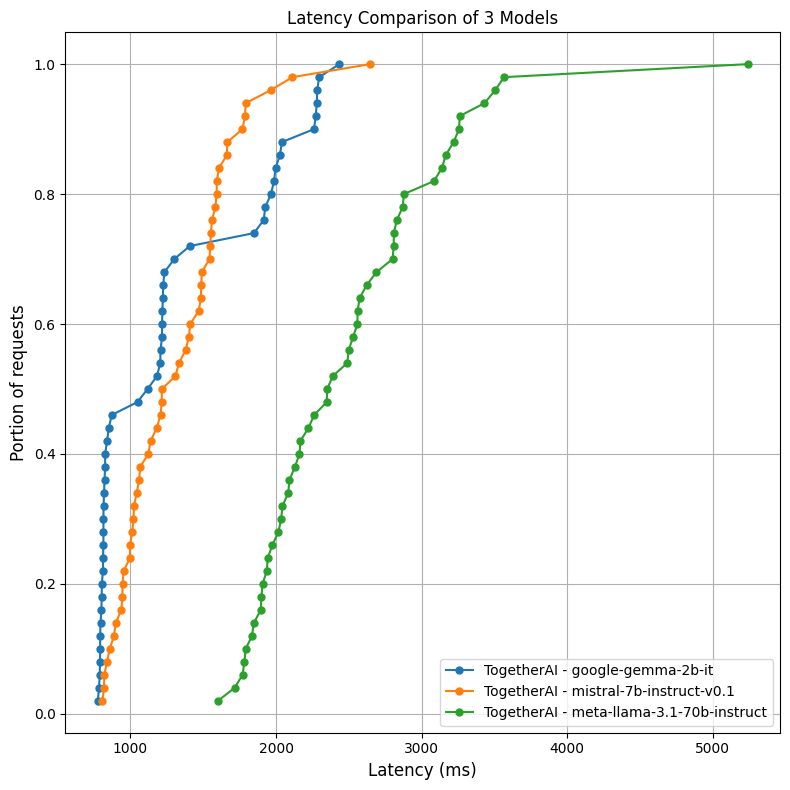

In [28]:
b.plot_metrics(b.totaltime)

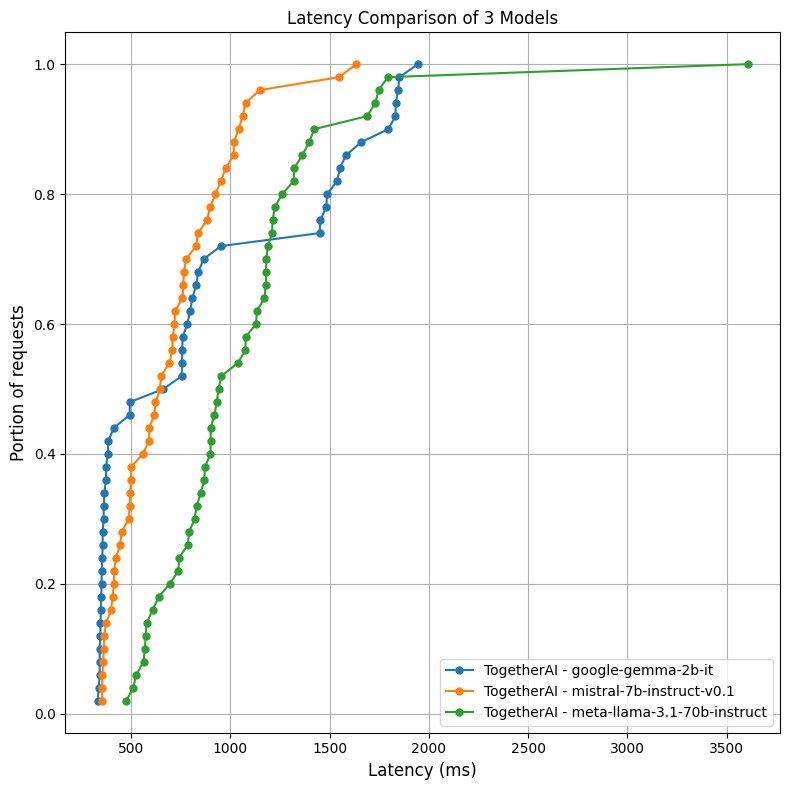

In [29]:
b.plot_metrics(b.timetofirsttoken)

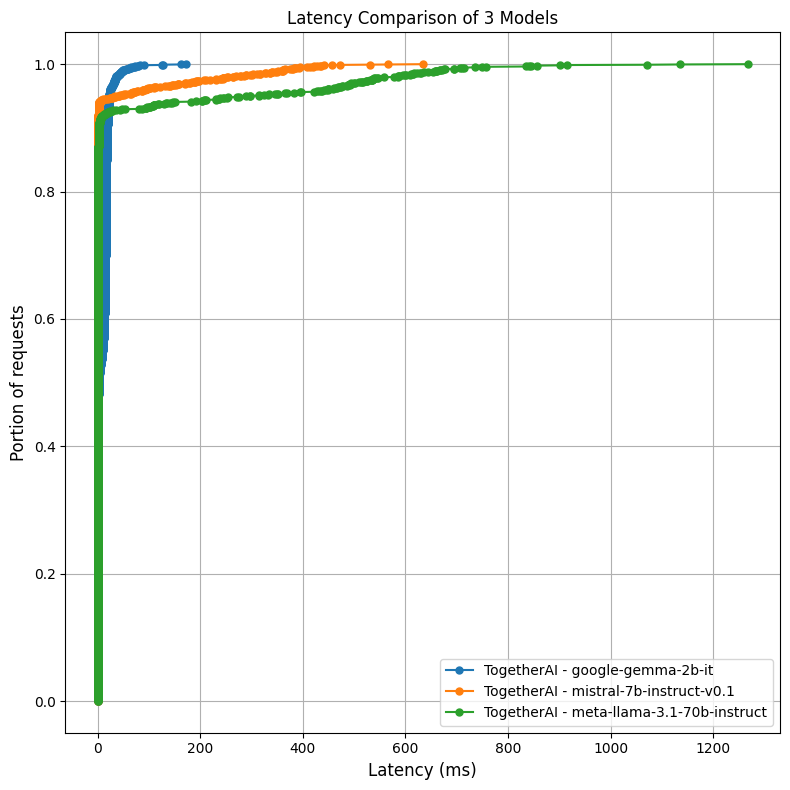

In [30]:
b.plot_metrics(b.timebetweentokens)

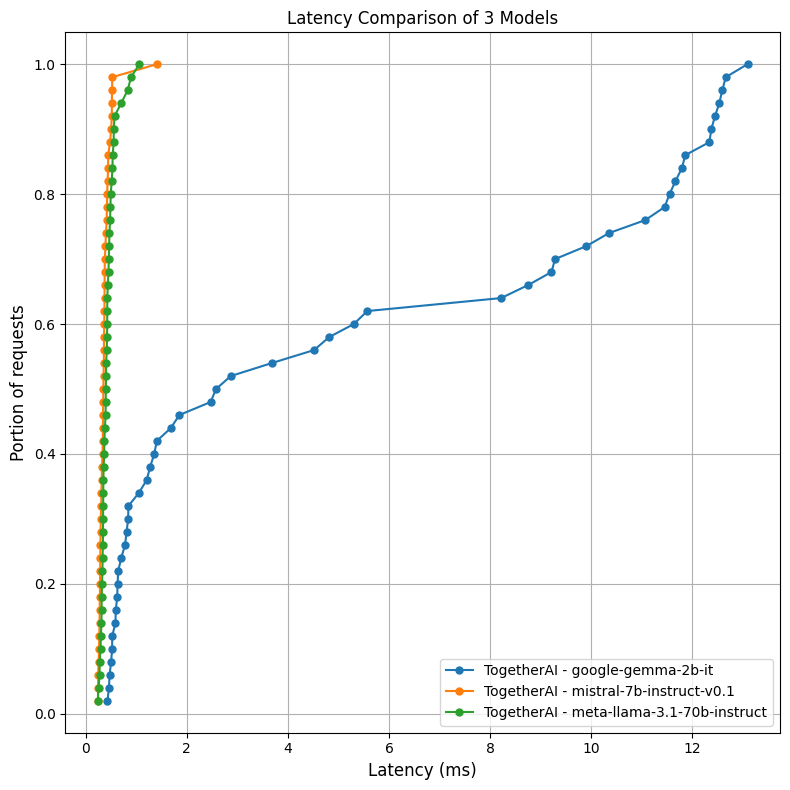

In [31]:
b.plot_metrics(b.timebetweentokens_median)

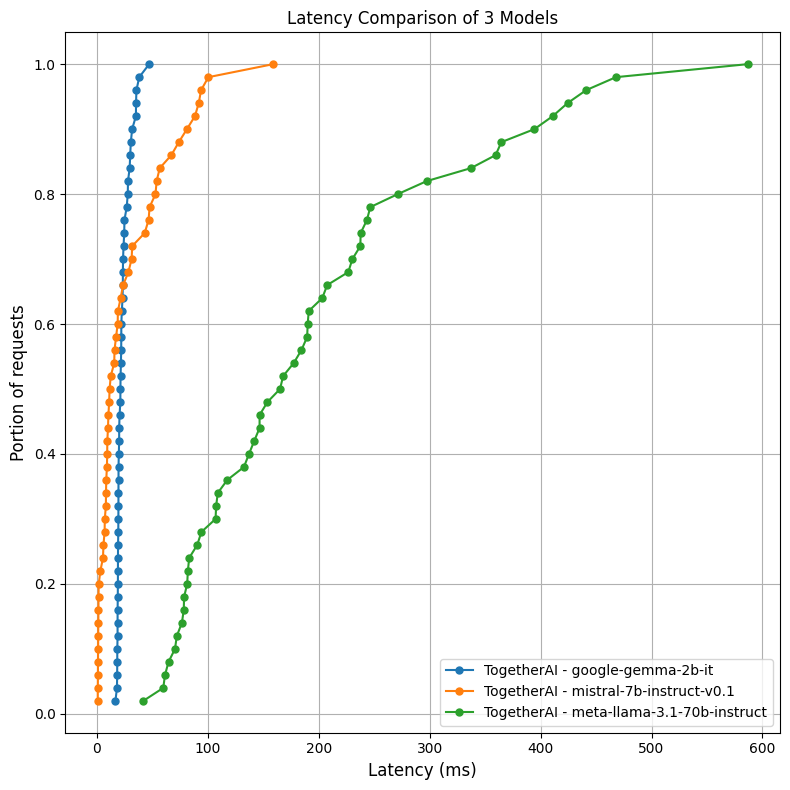

In [32]:
b.plot_metrics(b.timebetweentokens_p95)

In [34]:
prompt = "What are some fun things to do in New York? Give me 1 short example."
models = ["google-gemma-2b-it", "mistral-7b-instruct-v0.1", "meta-llama-3.1-70b-instruct"]

b = Benchmark([Cloudflare()], 50, models=models, prompt=prompt, streaming=True)
b.run()

##### Cloudflare

##### Model: google-gemma-2b-it
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 1.0881 seconds


Sure, here's a fun example of something to do in New York City:\n\nTrying out a capoeira dance class at a local studio. The unique blend of mindfulness and fast-paced dance moves offers a fun and unique experience.

##### Total Response Time: 2.4156 seconds

##### Number of output tokens/chunks: 50

Request 1

##### Time to First Token (TTFT): 2.4873 seconds


One fun thing to do in New York is taking a **walking tour of SoHo** and admiring the different murals and street art on display.

##### Total Response Time: 3.3055 seconds

##### Number of output tokens/chunks: 31

Request 2

##### Time to First Token (TTFT): 0.7109 seconds


Sure, here are a few fun things to do in New York City:\n\n- Visit the Wollston Manor House and Gardens - enjoy a step back in time exploring this historical estate.

##### Total Response Time: 1.8208 seconds

##### Number of output tokens/chunks: 39

Request 3

##### Time to First Token (TTFT): 0.5586 seconds


Sure, here's a fun example of a thing you might do in New York:\n\n**Visit the High Line**, a beautiful elevated park built on an old railway line. It's great for a walk, bike ride, or picnic.

##### Total Response Time: 1.7843 seconds

##### Number of output tokens/chunks: 52

Request 4

##### Time to First Token (TTFT): 0.7123 seconds


Take an unplanned stroll down Times Square and soak in the vibrant atmosphere.\n\nFor more fun, you could visit the brand-new High Line, a beautiful park built along an abandoned railway line.

##### Total Response Time: 1.8196 seconds

##### Number of output tokens/chunks: 41

Request 5

##### Time to First Token (TTFT): 0.5809 seconds


Sure, here's a fun example:\n\nVisit The High Line, a beautiful park built on a former railway line, with stunning city views.

##### Total Response Time: 1.3108 seconds

##### Number of output tokens/chunks: 32

Request 6

##### Time to First Token (TTFT): 0.7985 seconds


Sure, here's a fun example of an activity in New York City:\n\n**Visit the Brooklyn Bridge and climb to the top for stunning city views.**\n\nOther fun activities include:\n\n* **Take a stroll down the High Line**, an elevated park built on an old railway line.\n* **Visit the Metropolitan Museum of Art** and gaze at its vast collection of art.\n* **Catch a Broadway show** and experience the vibrant culture of the city.\n* **Visit the One World Trade Center** and the Rockefeller Center for breathtaking views of the city.\n* **Go on a food tour** and discover the diverse culinary scene of New York City.\n* **Visit the Staten Island Zoo** and see amazing animals from around the world.\n* **Take a walk or bike ride across the Brooklyn Bridge** for a unique perspective of the city.\n* **Attend a comedy show** in Greenwich Village.\n* **Go bar hopping in the East Village** and sample different concoctions and spirits.\n* **Visit the Empire State Building** for the most iconic view of the cit

##### Total Response Time: 6.5641 seconds

##### Number of output tokens/chunks: 227

Request 7

##### Time to First Token (TTFT): 1.2977 seconds


Sure, here's a fun example of something you can do in New York:\n\n**Visit Central Park and take a boat ride:** \nTake a leisurely stroll through the park, admire the sculptures and greenery, and hop on a boat for stunning views of the city skyline and the Hudson River.

##### Total Response Time: 3.0759 seconds

##### Number of output tokens/chunks: 63

Request 8

##### Time to First Token (TTFT): 0.8546 seconds


**Example:** Take a exhilarating walk across the Brooklyn Bridge for stunning views of Manhattan.

##### Total Response Time: 1.1946 seconds

##### Number of output tokens/chunks: 19

Request 9

##### Time to First Token (TTFT): 0.5729 seconds


Watching street performers in Times Square is a fun and energetic way to spend an afternoon in New York City.

##### Total Response Time: 1.0882 seconds

##### Number of output tokens/chunks: 23

Request 10

##### Time to First Token (TTFT): 1.2196 seconds


One fun activity in New York is visiting the The High Line, a former railway line transformed into a public park. You can enjoy walking, biking, and picnicking while taking in the stunning views of the city skyline.

##### Total Response Time: 2.5748 seconds

##### Number of output tokens/chunks: 47

Request 11

##### Time to First Token (TTFT): 1.1811 seconds


Sure, here's a fun example:\n\nGo on a food tour through Greenwich Village and discover the best pizza in the city.

##### Total Response Time: 1.9007 seconds

##### Number of output tokens/chunks: 29

Request 12

##### Time to First Token (TTFT): 1.1182 seconds


Sure! Here are some fun things to do in New York City:\n\n* **Visit the Empire State Building:** Take a stroll up to the observation deck for stunning views of the city.

##### Total Response Time: 2.0546 seconds

##### Number of output tokens/chunks: 40

Request 13

##### Time to First Token (TTFT): 1.1044 seconds


Sure, here's a fun thing to do in New York City:\n\n**Take a walk down Times Square and admire the bright lights and bustling atmosphere.**\n\nThis is a great option for a daytime activity, and it's a perfect way to get your adrenaline pumping!

##### Total Response Time: 2.7685 seconds

##### Number of output tokens/chunks: 58

Request 14

##### Time to First Token (TTFT): 1.4216 seconds


Sure, here's a fun suggestion:\n\nVisit the Empire State Building at sunset. Climb to the top for stunning panoramic views of the city.

##### Total Response Time: 1.9663 seconds

##### Number of output tokens/chunks: 32

Request 15

##### Time to First Token (TTFT): 0.6880 seconds


Sure, here's a fun and unique idea to try: Take a \Dirty Hop\ ghost tour through the Financial District and learn about the dark history of the area.

##### Total Response Time: 1.6543 seconds

##### Number of output tokens/chunks: 37

Request 16

##### Time to First Token (TTFT): 0.6897 seconds


**Example:** Check out Coney Island during the summer for free concerts and amusement park rides.\n\nHere are some other fun ideas to consider:\n\n- Visit the Metropolitan Museum of Art for a dose of culture and a walk through Central Park.\n- Take a stroll down Broadway and experience the dazzling lights and performances.\n- Explore the vibrant neighborhoods in SoHo and Brooklyn, each with its unique character and offerings.\n- Visit the Brooklyn Botanic Garden for a serene and picturesque escape.\n- Catch a Broadway show for a taste of decades-old tradition.\n- Take a ferry to Governor's Island and enjoy the scenic views and vibrant community events.\n- Visit the High Line for a unique urban park with art installations and gardens.\n- Explore Staten Island for free concerts and stunning city views at the Staten Island Ferry Terminal.

##### Total Response Time: 4.7507 seconds

##### Number of output tokens/chunks: 170

Request 17

##### Time to First Token (TTFT): 0.5365 seconds


Visit the Top of the Rock for panoramic views of the city, then take in the bustling atmosphere below.

##### Total Response Time: 1.0472 seconds

##### Number of output tokens/chunks: 23

Request 18

##### Time to First Token (TTFT): 0.9870 seconds


Example: Visit the Metropolitan Museum of Art and explore the collection's vibrant paintings and sculptures from different cultures.

##### Total Response Time: 1.6563 seconds

##### Number of output tokens/chunks: 24

Request 19

##### Time to First Token (TTFT): 15.2013 seconds


- Visit the High Line for a scenic walk above the city's streets.\n\nThis is a great option if you're seeking a unique and outdoorsy experience in the heart of Manhattan.

##### Total Response Time: 15.2103 seconds

##### Number of output tokens/chunks: 41

Request 20

##### Time to First Token (TTFT): 1.0484 seconds


Visit the Top of the Rock and get stunning panoramic views of the city.\n\nImagine a unique combined experience at the High Line, where a former railway line now transformed into a park offers an oasis of green amidst the concrete jungle.

##### Total Response Time: 2.2506 seconds

##### Number of output tokens/chunks: 48

Request 21

##### Time to First Token (TTFT): 1.0408 seconds


Sure, here's a fun activity: Take a ferry to Staten Island for a stunning view of Manhattan and a taste of Italian culture. You could also explore the bikes and pathways that wind around the island or check out the Staten Island Zoo.

##### Total Response Time: 2.5490 seconds

##### Number of output tokens/chunks: 51

Request 22

##### Time to First Token (TTFT): 1.3256 seconds


- Take a walk across the Brooklyn Bridge for stunning views of Manhattan and the harbor.

##### Total Response Time: 1.8595 seconds

##### Number of output tokens/chunks: 19

Request 23

##### Time to First Token (TTFT): 1.1975 seconds


Sure, here is a suggestion of fun things to do in New York City:\n\n**Example:** Visit the iconic Metropolitan Museum of Art and explore its vast collection of art, spanning different cultures and eras.

##### Total Response Time: 2.4004 seconds

##### Number of output tokens/chunks: 43

Request 24

##### Time to First Token (TTFT): 0.9341 seconds


Sure! One fun thing to do in New York City is visiting the Brooklyn Bridge Park. You can take a stroll across the park, enjoy the stunning views of Manhattan, or watch the sunset over the East River.

##### Total Response Time: 2.3609 seconds

##### Number of output tokens/chunks: 45

Request 25

##### Time to First Token (TTFT): 2.2430 seconds


* **Visit the High Line**, a park built along a former railway line in Lower Manhattan. The High Line offers stunning views of the Hudson River and a variety of activities, including bike rides, concerts, and art installations.\n\n**Example:** Take a stroll along the High Line and admire the artwork by artists like Vincent van Gogh and Andy Warhol.

##### Total Response Time: 3.9514 seconds

##### Number of output tokens/chunks: 72

Request 26

##### Time to First Token (TTFT): 0.5326 seconds


Sure, here's a fun example:\n\n**Visit The Frick Collection**, a museum that houses a diverse collection of contemporary art from around the world, including works by Andy Warhol, Jeff Koons, and Ai Weiwei.

##### Total Response Time: 1.6666 seconds

##### Number of output tokens/chunks: 48

Request 27

##### Time to First Token (TTFT): 0.8414 seconds


Sure, here's a fun example:\n\nImagine strolling down Fifth Avenue and popping inside a charming cafe or boutique for a sweet treat. They might have funky decor, delicious pastries, and live music playing – a truly unique experience in the heart of the city.

##### Total Response Time: 2.1226 seconds

##### Number of output tokens/chunks: 55

Request 28

##### Time to First Token (TTFT): 0.5655 seconds


Visiting the High Line is a fun and unique way to experience the city. The High Line is a former railway line turned into a park with stunning views of the Hudson River. You can take a stroll, bike ride, or just relax and enjoy the scenery.

##### Total Response Time: 1.8513 seconds

##### Number of output tokens/chunks: 54

Request 29

##### Time to First Token (TTFT): 0.9775 seconds


Sure! Here's a fun example:\n\n**Go on a hot air balloon ride over Manhattan and admire the stunning views of the city.**\n\nOther ideas include:\n\n* Visit the top of the Empire State Building for breathtaking panoramic views.\n* Explore the vibrant streets and art scene in Greenwich Village.\n* See a Broadway show for a taste of classic New York entertainment.\n* Visit the Metropolitan Museum of Art for free admission on the first Thursday of the month.\n* Take a stroll through Central Park and enjoy the peaceful atmosphere.\n* Visit the Brooklyn Bridge for breathtaking views of Manhattan and the Brooklyn Bridge Park.

##### Total Response Time: 4.7286 seconds

##### Number of output tokens/chunks: 129

Request 30

##### Time to First Token (TTFT): 0.7904 seconds


Sure, here's a fun idea: Take a walk across the Brooklyn Bridge and enjoy the stunning views of Manhattan and the Brooklyn Heights neighborhood.

##### Total Response Time: 1.4999 seconds

##### Number of output tokens/chunks: 31

Request 31

##### Time to First Token (TTFT): 0.9062 seconds


Take a kayak tour of the harbor at sunset, watching the city skyline illuminated by the setting sun.\n\nThis is just one example of the many exciting and unique things to do in New York City.

##### Total Response Time: 1.8787 seconds

##### Number of output tokens/chunks: 42

Request 32

##### Time to First Token (TTFT): 0.3924 seconds


**Example:** Take a scenic walk across the Brooklyn Bridge to explore Brooklyn Heights Park and enjoy stunning city views.

##### Total Response Time: 0.8988 seconds

##### Number of output tokens/chunks: 24

Request 33

##### Time to First Token (TTFT): 0.7161 seconds


**Example:** Take a stroll down Broadway and watch a live performance at Radio City Music Hall - tickets are affordable and the shows are fantastic!

##### Total Response Time: 1.5146 seconds

##### Number of output tokens/chunks: 30

Request 34

##### Time to First Token (TTFT): 2.1675 seconds


**Example:** Take a scenic walk through Central Park, enjoying the vibrant sights and sounds of life around you.

##### Total Response Time: 2.7014 seconds

##### Number of output tokens/chunks: 24

Request 35

##### Time to First Token (TTFT): 0.5396 seconds


**Example:** Take a virtual tour of the Statue of Liberty and Ellis Island by using Google Street View or Apple Maps.

##### Total Response Time: 1.1135 seconds

##### Number of output tokens/chunks: 26

Request 36

##### Time to First Token (TTFT): 0.8148 seconds


**Example:** Take a free ferry ride across the Hudson River for stunning views of the Manhattan skyline and the Statue of Liberty.

##### Total Response Time: 1.6017 seconds

##### Number of output tokens/chunks: 27

Request 37

##### Time to First Token (TTFT): 0.5375 seconds


**Example:** Take a free walking tour of Greenwich Village to learn about the neighborhood's history and culture.

##### Total Response Time: 1.0681 seconds

##### Number of output tokens/chunks: 24

Request 38

##### Time to First Token (TTFT): 0.8644 seconds


Sure! Here are a few ideas about fun things to do in New York City:\n\n- Visit the iconic Empire State Building for breathtaking panoramic views of the city.\n\n\n- Take a stroll through Central Park, enjoying the greenery and seeing the sights of Broadway and Central Park Zoo.

##### Total Response Time: 2.1891 seconds

##### Number of output tokens/chunks: 58

Request 39

##### Time to First Token (TTFT): 0.9698 seconds


**1.** Visit the Brooklyn Bridge at sunset for breathtaking views of the Manhattan skyline.

##### Total Response Time: 1.3997 seconds

##### Number of output tokens/chunks: 19

Request 40

##### Time to First Token (TTFT): 0.8060 seconds


Sure, here is an example of some fun things to do in New York City:\n\n**Example:** Visit Harlem and explore the vibrant neighborhood with its rich musical history, unique culture, and buzzing nightlife.

##### Total Response Time: 1.8004 seconds

##### Number of output tokens/chunks: 43

Request 41

##### Time to First Token (TTFT): 0.8959 seconds


Go see a live performance at Radio City Music Hall. An example of something you could do for fun would be attending The Great American Songbook Festival, which features performances by some of the biggest artists in American history.

##### Total Response Time: 1.9415 seconds

##### Number of output tokens/chunks: 45

Request 42

##### Time to First Token (TTFT): 0.8377 seconds


Sure! Here's a fun idea: Take a \Walls of New York\ walking tour. This tour takes you past some of the most iconic and historically significant locations in Manhattan and beyond, such as Central Park and the Brooklyn Bridge.

##### Total Response Time: 2.1819 seconds

##### Number of output tokens/chunks: 50

Request 43

##### Time to First Token (TTFT): 0.5888 seconds


Sure, here's a fun example:\nVisit the Brooklyn Bridge at sunset and enjoy breathtaking views of the Manhattan skyline.

##### Total Response Time: 1.2010 seconds

##### Number of output tokens/chunks: 27

Request 44

##### Time to First Token (TTFT): 0.9908 seconds


Visit Times Square and take in the dazzling lights and theater performances.\n\nFor more fun, explore the vibrant neighborhoods of Brooklyn Heights and Harlem. You can enjoy breathtaking views of the Manhattan skyline while taking a stroll along the Brooklyn Bridge.

##### Total Response Time: 2.1918 seconds

##### Number of output tokens/chunks: 48

Request 45

##### Time to First Token (TTFT): 0.6562 seconds


One fun thing to do in New York is to visit the Brooklyn Bridge Park and take in the stunning views of the Manhattan skyline.

##### Total Response Time: 1.2775 seconds

##### Number of output tokens/chunks: 28

Request 46

##### Time to First Token (TTFT): 0.5310 seconds


A short example of a fun thing to do in New York City is visiting the Brooklyn Bridge Park and enjoying the views of the Manhattan skyline.

##### Total Response Time: 1.2105 seconds

##### Number of output tokens/chunks: 30

Request 47

##### Time to First Token (TTFT): 1.6485 seconds


Take a gondola ride through Central Park Lake, taking in the sights and sounds of nature amidst the city’s bustling energy.

##### Total Response Time: 2.3808 seconds

##### Number of output tokens/chunks: 27

Request 48

##### Time to First Token (TTFT): 0.8677 seconds


Taking a photography walk through the picturesque Hell's Kitchen neighborhood at sunset, capturing the vibrant colors of the sunset over the Hudson River.

##### Total Response Time: 1.6583 seconds

##### Number of output tokens/chunks: 29

Request 49

##### Time to First Token (TTFT): 0.7270 seconds


Take a walk across the Brooklyn Bridge and take in the breathtaking views of the Manhattan skyline. It’s a great way to see the city from a completely different perspective.

##### Total Response Time: 1.8575 seconds

##### Number of output tokens/chunks: 36

##### Model: mistral-7b-instruct-v0.1
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 0.6472 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park and visiting the Bethesda Terrace and Fountain. This beautiful area in the heart of Central Park offers a serene and picturesque setting, with the towering Bethesda Terrace Arcade providing a grand backdrop. You can take in the sights, enjoy a picnic, rent a rowboat on the lake, or simply relax and people-watch beside the historic fountain. The energy and vibrancy of New York City are all around you, but in this particular spot, you'll find a moment of peace and tranquility.

##### Total Response Time: 8.9869 seconds

##### Number of output tokens/chunks: 137

Request 1

##### Time to First Token (TTFT): 0.6212 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a bike, go for a run, have a picnic, or even take a boat ride on the lake in the park. It's a great way to experience the natural beauty of the city and see some famous landmarks like the Bethesda Fountain and the Bow Bridge. Plus, you might even spot some celebrities or famous New Yorkers while you're there!

##### Total Response Time: 7.6728 seconds

##### Number of output tokens/chunks: 105

Request 2

##### Time to First Token (TTFT): 0.8834 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including the famous Central Park, Times Square, and the monumental skyline. It's especially stunning during sunset or at night when the city lights up. Plus, it's less crowded compared to the Empire State Building making for a more enjoyable experience. Shortly put, experiencing the panoramic vista from the Top of the Rock is a must-do when visiting New York City.

##### Total Response Time: 8.5330 seconds

##### Number of output tokens/chunks: 121

Request 3

##### Time to First Token (TTFT): 0.8061 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. During the day, you can enjoy breathtaking views of the city and Central Park, and at night, the city comes alive with twinkling lights and an unforgettable view of the glittering skyline. It's a must-do experience for first-time visitors or for locals looking to reconnect with the magic of the Big Apple.

##### Total Response Time: 7.4413 seconds

##### Number of output tokens/chunks: 105

Request 4

##### Time to First Token (TTFT): 0.9443 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park and renting a rowboat or a bike to explore its beautiful scenery. You can also visit the Central Park Zoo or the Alice in Wonderland statue, or simply relax and enjoy a picnic in the sun. Keep in mind that the hours and availability of these activities may vary depending on the season and current restrictions, so it's best to check ahead to make sure. Enjoy your trip to New York!

##### Total Response Time: 8.0251 seconds

##### Number of output tokens/chunks: 107

Request 5

##### Time to First Token (TTFT): 0.7066 seconds


 One fun thing to do in New York is a day trip to Central Park. You can rent a rowboat or a bike, have a picnic, visit the Central Park Zoo, or just take a leisurely stroll through the beautiful scenery. In the summer months, you can even attend a free outdoor concert or performance. It's a great way to experience the natural beauty of the city and enjoy some classic New York activities.

##### Total Response Time: 6.4843 seconds

##### Number of output tokens/chunks: 94

Request 6

##### Time to First Token (TTFT): 0.5046 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city's skyline and various landmarks, including Central Park, Times Square, and the Empire State Building. Plus, it's open later hours than the Statue of Liberty or Empire State Building observatories, making it a great spot for catching sunsets or nighttime views of the city. You can even purchase tickets that include access to an exhibit showcasing the history of Rockefeller Center. Just remember to dress warmly for the chilly observation deck!

##### Total Response Time: 8.9486 seconds

##### Number of output tokens/chunks: 137

Request 7

##### Time to First Token (TTFT): 0.7908 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from an observation deck that offers panoramic vistas of the Manhattan skyline, Central Park, and various other landmarks. Plus, you can experience it at any time of day, as it's open from early morning until midnight.\n\nIf you want to make it even more special, consider going during sunset hours to see the city transition from day to night, or visiting during the winter months to experience the stunning views with a backdrop of snow. Just remember to dress warmly if you go during colder months! It's an experience that's sure to leave you with lasting memories of the Big Apple.

##### Total Response Time: 12.1604 seconds

##### Number of output tokens/chunks: 172

Request 8

##### Time to First Token (TTFT): 0.6903 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city's skyline and Central Park from an elevation of 70 stories. During the day, you can see the city in all its bustling glory, while at night, the sparkling lights create a magical and memorable experience. Additionally, timing your visit for sunset gives you the best of both worlds! Keep in mind that tickets can be purchased online or in person, and any time spent here is sure to be a highlight of your New York adventure.

##### Total Response Time: 8.9070 seconds

##### Number of output tokens/chunks: 137

Request 9

##### Time to First Token (TTFT): 1.2045 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. You can take in breathtaking views of the city's skyline and Central Park from the indoor and outdoor observation areas. It's especially stunning at sunset or after dark when the city is all lit up. Plus, it's a great photo opportunity! Just remember to book your tickets in advance to avoid long lines.

##### Total Response Time: 7.1575 seconds

##### Number of output tokens/chunks: 99

Request 10

##### Time to First Token (TTFT): 0.7384 seconds


 New York City offers a wide variety of fun activities for visitors. One short example that combines history, culture, and fresh air is a stroll through Central Park followed by a visit to The Metropolitan Museum of Art.\n\nCentral Park is a large urban park located in the heart of Manhattan, spanning over 843 acres. You can rent a rowboat and paddle on the Lake, take a leisurely walk in the Gardens, or even attend a free outdoor concert in the Summer. The park is home to numerous landmarks, such as the Bethesda Terrace and Fountain, and the Central Park Zoo.\n\nThe Metropolitan Museum of Art, often referred to as \The Met,\ is one of the world's largest and finest art museums, located on the eastern edge of Central Park. Founded in 1870, The Met includes a vast collection of more than two million works of art from around the world and throughout history. After your walk in the park, you can explore galleries devoted to American Decorative Arts, European Paintings and Sculptures, Asian

##### Total Response Time: 20.1040 seconds

##### Number of output tokens/chunks: 310

Request 11

##### Time to First Token (TTFT): 1.0151 seconds


 New York City offers a vast array of fun and entertaining activities for visitors. One short example would be a visit to the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from the indoor and outdoor observation levels. During warmer months, you can also take in the famous views of the city skyline with a refreshing cocktail in hand from the rooftop bar, The Rainforest Cafe. This is an excellent activity for both first-time visitors and those wanting to experience the city from a new perspective. Just be sure to book your tickets in advance to avoid long lines!

##### Total Response Time: 9.3920 seconds

##### Number of output tokens/chunks: 138

Request 12

##### Time to First Token (TTFT): 0.3977 seconds


 One fun and iconic activity in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center for breathtaking views of the city. You can observe the famous New York City skyline, Central Park, and even the Statue of Liberty on a clear day. Plus, the observation deck is open late into the night, so you can experience the city's stunning lights and energy after dark. Other activities in New York include exploring Times Square, wandering through the Metropolitan Museum of Art, taking a stroll in Central Park, or catching a Broadway show.

##### Total Response Time: 8.2202 seconds

##### Number of output tokens/chunks: 124

Request 13

##### Time to First Token (TTFT): 1.2410 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from an observation deck open-air deck on the 70th floor. This is a great way to experience the city's skyline, especially during sunset. Plus, you'll get to see the famous landmarks like the Empire State Building and Central Park from a unique perspective. It's an experience you won't forget!

##### Total Response Time: 8.3587 seconds

##### Number of output tokens/chunks: 114

Request 14

##### Time to First Token (TTFT): 1.1961 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. It's a great way to experience the natural beauty of the city amidst the hustle and bustle of urban life. You can rent a boat and row on the lake, visit the Central Park Zoo, hire a bike, or simply enjoy a picnic and watch the world go by. Don't forget to stop by the famous Bow Bridge for a picturesque moment.

##### Total Response Time: 7.3322 seconds

##### Number of output tokens/chunks: 101

Request 15

##### Time to First Token (TTFT): 0.5798 seconds


 New York City offers a vast array of fun activities for visitors! One short and enjoyable example would be a stroll through Central Park.this 843-acre urban park in the heart of Manhattan is a perfect place for a relaxing walk, a picnic, or even renting a rowboat or bike for an hour. In Central Park, you can also visit iconic landmarks such as the Bethesda Terrace and Fountain, Strawberry Fields, and Central Park Zoo. Plus, keeping an eye out for street performers, musicians, and artists adds to the unique experience.

##### Total Response Time: 8.4939 seconds

##### Number of output tokens/chunks: 127

Request 16

##### Time to First Token (TTFT): 1.0034 seconds


 New York City offers a wide range of fun activities for visitors. One short example of a fun experience is taking a bike tour of Central Park. Rent a bike or bring your own, and explore the beautiful 843-acre park in the heart of the city. Enjoy scenic views of iconic landmarks such as the Bethesda Fountain, the Central Park Zoo, and the Great Lawn. Stop for a picnic, rent a rowboat on the Lake, or simply enjoy a leisurely bike ride through the park's winding paths. Central Park is a must-visit attraction for both locals and tourists alike.

##### Total Response Time: 9.5720 seconds

##### Number of output tokens/chunks: 136

Request 17

##### Time to First Token (TTFT): 0.6486 seconds


 One fun and short activity to do in New York is visiting the High Line, an elevated park built on an old railway line. Stroll through the lush greenery, take in the stunning views of the city and the Hudson River, and explore the various art installations along the way. Don't forget to grab a bite or a drink at one of the many nearby cafes or restaurants. The High Line is a unique and quintessential New York experience not to be missed!

##### Total Response Time: 6.8236 seconds

##### Number of output tokens/chunks: 104

Request 18

##### Time to First Token (TTFT): 0.9551 seconds


 New York City offers a vast array of exciting and fun activities for visitors. One short example is a day spent exploring the innovative and interactive exhibits at the American Museum of Natural History. Here, you can come face-to-face with a 12-foot-long silicone diplodocus dinosaur, touch a real meteorite, or venture into the Hall of Biodiversity to marvel at the incredible variety of species on our planet. The museum also hosts special events, including evening sleepovers for kids and adults, and the annual Museum Mile Festival, where you can enjoy music, dance, and art in the beautiful outdoor setting of Fifth Avenue. Make sure to add this incredible institution to your must-visit list when planning your trip to New York City.

##### Total Response Time: 11.3498 seconds

##### Number of output tokens/chunks: 165

Request 19

##### Time to First Token (TTFT): 0.9887 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city's skyline and Central Park from an elevation of 70 stories. It's a great way to experience the scope and diversity of New York, and the stunning panorama is especially beautiful during sunset or at night when the city is all lit up. Additionally, visiting the Top of the Rock allows you to take in some famous New York landmarks, such as the Empire State Building, Times Square, and the Chrysler Building, from a unique perspective. It's an experience that truly embodies the essence of the vibrant and exciting city!

##### Total Response Time: 10.5934 seconds

##### Number of output tokens/chunks: 160

Request 20

##### Time to First Token (TTFT): 0.8391 seconds


One fun thing to do in New York is visiting Central Park. You can rent a boat and row on The Lake, take a leisurely stroll in the park, visit the Central Park Zoo or Alice in Wonderland Statue, go for a bike ride, or even attend a free performance at the Delacorte Theater. It's a great way to experience the natural beauty in the heart of the bustling city.

##### Total Response Time: 6.7351 seconds

##### Number of output tokens/chunks: 90

Request 21

##### Time to First Token (TTFT): 1.2935 seconds


 New York City offers a wide range of fun activities for visitors. Here's a short example of a popular and enjoyable experience:\n\nVisiting the Top of the Rock Observation Deck at Rockefeller Center:\n\n1. Experience breathtaking views of New York City: The Top of the Rock Observation Deck provides an unobstructed 360-degree view of the city, including iconic landmarks like the Statue of Liberty, Central Park, Times Square, and the Empire State Building.\n\n2. Explore multiple observation levels: The three observation levels offer different perspectives of the city, with the first level providing close-up views, the second level featuring panoramic vistas, and the third level offering a unique perspective of the city's skyline.\n\n3. Visit during sunset: Timing your visit to the Top of the Rock during sunset will treat you to a stunning display of colors over the city, creating an unforgettable experience.\n\n4. Watch the city come alive at night: Stay late and watch New York City tra

##### Total Response Time: 20.9416 seconds

##### Number of output tokens/chunks: 302

Request 22

##### Time to First Token (TTFT): 0.6417 seconds


 Absolutely! New York City is known for its vibrant energy and endless list of things to do. Here is a short example of a fun activity:\n\nVisit the Top of the Rock Observation Deck at Rockefeller Center for breathtaking views of the city. After ascending in the elevator, you'll reach an open-air observation deck where you can take in panoramic vistas of iconic landmarks such as Central Park, Times Square, and the Statue of Liberty. It's a must-see experience for anyone visiting New York City!

##### Total Response Time: 8.3127 seconds

##### Number of output tokens/chunks: 123

Request 23

##### Time to First Token (TTFT): 0.7509 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. You can take the elevator up to the observation deck and enjoy breathtaking views of the city, including Central Park, Times Square, and the Statue of Liberty. Plus, you can also get a great picture with the iconic \I ♥ NY\ sign! It's a must-do experience for tourists and locals alike.

##### Total Response Time: 6.8628 seconds

##### Number of output tokens/chunks: 100

Request 24

##### Time to First Token (TTFT): 1.1806 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city skyline and Central Park from an elevation of 70 stories. It's open year-round, and the hours vary depending on the season. To make it even more enjoyable, consider visiting during sunset for a stunning display of colors over the city. Keep in mind that it can get crowded, so try to plan your visit during less busy hours or consider purchasing a skip-the-line ticket to save time.

##### Total Response Time: 9.5829 seconds

##### Number of output tokens/chunks: 130

Request 25

##### Time to First Token (TTFT): 0.8304 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including the famous Central Park and the sprawling met skyline. Plus, you can time your visit to catch a beautiful sunset over the city. It's an experience that is both exciting and memorable!

##### Total Response Time: 5.9033 seconds

##### Number of output tokens/chunks: 83

Request 26

##### Time to First Token (TTFT): 0.8906 seconds


 One fun and iconic activity to do in New York is to take a stroll through Central Park and visit the Bow Bridge. This beautiful cast-iron bridge, completed in 1862, is not only a picturesque spot but also offers stunning views of the park's lakes, The Lake and The Pond. You can take a leisurely walk across the bridge, feed the ducks, or bring a picnic blanket and enjoy a relaxing afternoon in the park. Keep in mind that Central Park is a large green space with many attractions, so you might also want to explore other areas like Strawberry Fields, Bethesda Terrace, or the Central Park Zoo while you're there.

##### Total Response Time: 10.1227 seconds

##### Number of output tokens/chunks: 152

Request 27

##### Time to First Token (TTFT): 1.4328 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from an observation deck that offers panoramic vistas of the Manhattan skyline, Central Park, and various landmarks such as the Empire State Building, Times Square, and the Statue of Liberty (on a clear day). It's a great experience for both tourists and locals alike and is open year-round.\n\nVenture to the Top of the Rock during sunset for an extra special treat – the breathtaking transition from day to night, with the city coming alive in twinkling lights beneath you. Access to the observation deck is available through purchasing tickets or bundling it with other experiences like a guided tour.

##### Total Response Time: 11.9451 seconds

##### Number of output tokens/chunks: 173

Request 28

##### Time to First Token (TTFT): 1.1708 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from the indoor and outdoor observation decks. On a clear day, you can see for miles and take in iconic landmarks such as the Statue of Liberty, Central Park, and Times Square. It's particularly beautiful during sunset or at night when the city is all lit up. Make sure to bring a camera to capture the memories!

##### Total Response Time: 8.3214 seconds

##### Number of output tokens/chunks: 114

Request 29

##### Time to First Token (TTFT): 0.3628 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. After taking the quick elevator ride to the top, you'll be treated to breathtaking views of the city, including Central Park, Times Square, and the famous New York City skyline. It's a great way to experience the vibrant energy and beauty of New York, especially during sunset or at night when the city lights up. Plus, it's a more affordable alternative to the Empire State Building's observation deck!

##### Total Response Time: 7.6548 seconds

##### Number of output tokens/chunks: 121

Request 30

##### Time to First Token (TTFT): 0.7452 seconds


 New York City offers a vast array of entertaining activities! One fun and short example would be a visit to the Top of the Rock Observation Deck at Rockefeller Center. For just $37, you can enjoy breathtaking views of the city from three observation decks and an open-air roof deck. Watch the sunset over the Manhattan skyline, or simply take in the iconic sights of Central Park, Times Square, and the Brooklyn Bridge. It's a must-see experience for both first-time visitors and repeat travelers to New York City!

##### Total Response Time: 8.5622 seconds

##### Number of output tokens/chunks: 122

Request 31

##### Time to First Token (TTFT): 0.8424 seconds


 One fun andshort activity to do in New York is visiting the High Line, an elevated park built on an old railway line. You can take a leisurely stroll among the greenery and flowers, enjoy stunning views of the city, and discover interesting public art installations. The High Line also offers various food vendors and cafes, making it an ideal destination for both locals and tourists. (Word count: 56)

##### Total Response Time: 6.4390 seconds

##### Number of output tokens/chunks: 92

Request 32

##### Time to First Token (TTFT): 0.9670 seconds


 One fun and short activity to do in New York is visiting the High Line, an elevated park built on an old railway line. Take a leisurely stroll among the greenery and artwork, enjoy breathtaking views of the city, and stop by the various vendors and food carts along the way. It's a great way to experience New York's unique blend of nature and urbanity.

##### Total Response Time: 6.1447 seconds

##### Number of output tokens/chunks: 87

Request 33

##### Time to First Token (TTFT): 1.2942 seconds


 New York City offers a wide range of fun activities for visitors. One short example of an enjoyable experience is a stroll through Central Park. You can rent a bike, row a boat in the lake, visit the Central Park Zoo, or simply enjoy a picnic while taking in the beautiful scenery and watching the world go by. Keep in mind that there are numerous other activities and attractions to explore in New York City, so you may want to create a custom itinerary based on your interests.

##### Total Response Time: 7.6426 seconds

##### Number of output tokens/chunks: 106

Request 34

##### Time to First Token (TTFT): 0.8570 seconds


 New York City offers a wide range of fun activities for visitors! One short example of a fun activity is taking a stroll through Central Park. You can rent a bike, row a boat in the lake, visit the Central Park Zoo, or simply enjoy a picnic while taking in the beautiful scenery and unique energy of the city. Don't forget to stop by famous landmarks like the Bethesda Fountain and the Bow Bridge for some great photo opportunities!

##### Total Response Time: 6.8838 seconds

##### Number of output tokens/chunks: 100

Request 35

##### Time to First Token (TTFT): 1.4031 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at the Rockefeller Center. Here, you can enjoy stunning views of the city's skyline and Central Park, and even get a great look at the Statue of Liberty on a clear day. Plus, the observation deck offers both indoor and outdoor viewing areas, so you can experience the thrill of being out in the open air or stay cozy inside. It's a must-see attraction for both first-time visitors and repeat guests to the city!

##### Total Response Time: 8.7195 seconds

##### Number of output tokens/chunks: 121

Request 36

##### Time to First Token (TTFT): 2.3376 seconds


 One fun and short activity to do in New York is visiting the High Line, an elevated park built on an old railway line. Stroll along the garden paths, enjoy stunning views of the city and the Hudson River, and discover unique public art installations. Don't forget to try some classic New York street food like a hot dog from a cart or a slice of pizza while you're out exploring!

##### Total Response Time: 7.5228 seconds

##### Number of output tokens/chunks: 86

Request 37

##### Time to First Token (TTFT): 0.8985 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a boat at the Loeb Boathouse and row on the lake, rent a bike to explore the park's many scenic routes, or simply enjoy a picnic on the grass. Alternatively, you can visit the Central Park Zoo, the Central Park Conservatory Garden, or take in a show at the Delacorte Theater during the summer months. Central Park is a must-see attraction in New York City, and offers something for visitors of all ages and interests.

##### Total Response Time: 8.9290 seconds

##### Number of output tokens/chunks: 123

Request 38

##### Time to First Token (TTFT): 1.4872 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck located at the Rockefeller Center. Here, you can enjoy breathtaking views of the city from an observation deck with open-air terraces. It offers panoramic vistas of the Manhattan skyline, Central Park, and the iconic structures like the Empire State Building and the Chrysler Building. Plus, visiting at sunset provides a beautiful and memorable experience.

##### Total Response Time: 8.1044 seconds

##### Number of output tokens/chunks: 102

Request 39

##### Time to First Token (TTFT): 1.0680 seconds


 One fun and iconic activity to do in New York is taking a stroll through Central Park. You can rent a bike, row a boat in the lake, visit the Central Park Zoo, or simply enjoy a picnic among the beautiful scenery. Take in the city's vibrant energy from the peaceful oasis of Central Park. Don't forget to stop by and take a photo with the famous Bow Bridge for a classic New York moment.

##### Total Response Time: 6.8267 seconds

##### Number of output tokens/chunks: 96

Request 40

##### Time to First Token (TTFT): 1.1814 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from the indoor and outdoor observation areas. It's an excellent spot to take in the panoramic vistas of Manhattan and capture some amazing photos. Plus, it's open late into the night, making it a great option for watching the city lights come on after dark.

##### Total Response Time: 7.2134 seconds

##### Number of output tokens/chunks: 100

Request 41

##### Time to First Token (TTFT): 0.5683 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. This offers breathtaking views of the city, including Central Park, the Empire State Building, and the overall Manhattan skyline. It's open year-round and can be particularly stunning during sunset or at night when the city lights up. Don't forget to take some memorable photos! (Short example)

##### Total Response Time: 6.2973 seconds

##### Number of output tokens/chunks: 95

Request 42

##### Time to First Token (TTFT): 0.3521 seconds


 New York City is known for its vibrant culture, iconic landmarks, and endless entertainment options. One fun activity to experience is a visit to the Top of the Rock Observation Deck at Rockefeller Center. Here, you can enjoy breathtaking views of the city from an observatory level, providing a unique perspective of the Manhattan skyline. You can also take in stunning views of Central Park and other famous landmarks like the Empire State Building and the Chrysler Building. This short example represents just a small slice of the many exciting things to do in New York City.

##### Total Response Time: 7.9306 seconds

##### Number of output tokens/chunks: 123

Request 43

##### Time to First Token (TTFT): 1.0658 seconds


 One fun and iconic activity to do in New York City is visiting the Top of the Rock Observation Deck at Rockefeller Center. This provides breathtaking views of the city, including the famous Central Park and the iconic skyline. It's particularly beautiful during sunset. After taking in the views, you can explore the surrounding area, such as the Radio City Music Hall or the NBC Studios. Plus, it's often less crowded than the observation deck at the Empire State Building!

##### Total Response Time: 7.4681 seconds

##### Number of output tokens/chunks: 106

Request 44

##### Time to First Token (TTFT): 0.3058 seconds


 One fun and iconic activity to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. Not only will you get an amazing panoramic view of the city, but you'll also get to see the famous New York City skyline and Central Park, and perhaps even a beautiful sunset. It's open seven days a week, most hours of the day. Just make sure to plan your visit for a clear day to get the best view!

##### Total Response Time: 6.7279 seconds

##### Number of output tokens/chunks: 105

Request 45

##### Time to First Token (TTFT): 1.2891 seconds


 New York City offers a vast array of fun activities for visitors. one short example would be taking a stroll through Central Park and visiting the Central Park Zoo. You can rent a rowboat or a bike to explore the park's scenic beauty, or simply enjoy a picnic on the grass. At the Central Park Zoo, you can see a variety of animals, such as seals, penguins, and red pandas, up close. It's a great way to experience the natural side of the city while also enjoying its famed urban energy.

##### Total Response Time: 8.3050 seconds

##### Number of output tokens/chunks: 119

Request 46

##### Time to First Token (TTFT): 0.6135 seconds


 New York City is known for its endless possibilities for entertainment, culture, and fun. Here's a short example of an enjoyable activity:\n\nVisit the High Line – This unique park is built on an elevated former railroad track and offers stunning views of the city skyline and the Hudson River. walks through gardens, art installations, and features excellent people-watching opportunities. Plus, there are several food and drink vendors along the way. It's a great way to experience New York's urban beauty while getting some fresh air and exercise.

##### Total Response Time: 7.8559 seconds

##### Number of output tokens/chunks: 117

Request 47

##### Time to First Token (TTFT): 0.6074 seconds


 New York City is known for its vibrant energy and endless entertainment opportunities. Here's a short example of a fun activity:\n\nOne fun thing to do in New York is taking a stroll through Central Park. This iconic urban park offers something for everyone: you can rent a rowboat or bike, see the Central Park Zoo, visit the Bethesda Terrace and Fountain, or simply enjoy a picnic and people-watching. In the spring and summer months, the park comes alive with live music performances, outdoor theater, and street performances. So pack a picnic, bring a frisbee, and enjoy the beautiful scenery and lively atmosphere of Central Park!

##### Total Response Time: 9.6436 seconds

##### Number of output tokens/chunks: 147

Request 48

##### Time to First Token (TTFT): 1.5604 seconds


 New York City is known for its endless opportunities for fun and entertainment. One short example of a fun activity is taking a stroll through Central Park and visiting the Central Park Zoo. You can feed carrots to the friendly red pandas, watch the sea lions play, and even come face to face with a snow leopard. After exploring the zoo, rent a rowboat or a bike to enjoy the rest of the park's picturesque scenery. It's a great way to soak up the beauty of nature in the heart of the bustling city.

##### Total Response Time: 9.4062 seconds

##### Number of output tokens/chunks: 123

Request 49

##### Time to First Token (TTFT): 1.2233 seconds


 Sure! New York City is known for its bustling energy and vast array of activities. Here's a short example of a fun and popular activity:\n\nVisit the Top of the Rockefeller Center: Take the elevator up to the Top of the Rock Observation Deck for breathtaking views of the city. This iconic landmark offers panoramic vistas of Manhattan, allowing you to take in famous sites like Central Park, the Statue of Liberty, and Times Square from an unforgettable perspective. Plus, visiting during sunset or at night when the city is beautifully lit up is an experience not to be missed!

##### Total Response Time: 9.4593 seconds

##### Number of output tokens/chunks: 136

##### Model: meta-llama-3.1-70b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 0.7486 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Visit the Top of the Rock Observation Deck**: For a thrilling panoramic view of the Manhattan skyline, head to the Top of the Rock Observation Deck, located on the 70th floor of Rockefeller Center. On a clear day, you can see for miles in every direction, taking in iconic landmarks like the Empire State Building, the Statue of Liberty, and Central Park.

##### Total Response Time: 3.9158 seconds

##### Number of output tokens/chunks: 93

Request 1

##### Time to First Token (TTFT): 1.2358 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Visit the Top of the Rock Observation Deck**: Take in breathtaking views of the Manhattan skyline from the 70th floor of Rockefeller Center. You can see iconic landmarks like the Empire State Building, the Chrysler Building, and Central Park from a unique perspective. It's a thrilling experience, especially at sunset or twilight!

##### Total Response Time: 4.0261 seconds

##### Number of output tokens/chunks: 82

Request 2

##### Time to First Token (TTFT): 0.9740 seconds


Here's one fun thing to do in New York:\n\n**Take a stroll through Central Park**: Explore the many scenic paths, visit the Bethesda Fountain, and enjoy the scenery in the heart of Manhattan. You can even rent a bike or take a leisurely boat ride on the lake!

##### Total Response Time: 3.0297 seconds

##### Number of output tokens/chunks: 59

Request 3

##### Time to First Token (TTFT): 1.1443 seconds


One fun thing to do in New York is to take a stroll across the Brooklyn Bridge at sunset, offering stunning views of the Manhattan skyline and the East River!

##### Total Response Time: 2.1987 seconds

##### Number of output tokens/chunks: 34

Request 4

##### Time to First Token (TTFT): 0.8734 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Walk across the Brooklyn Bridge**: Take a stroll across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some breathtaking views.

##### Total Response Time: 3.0661 seconds

##### Number of output tokens/chunks: 66

Request 5

##### Time to First Token (TTFT): 0.6234 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a sunset stroll across the Brooklyn Bridge**: Offering spectacular views of the Manhattan skyline, the East River, and Brooklyn, this iconic bridge is a must-visit. You'll feel the energy of the city as you walk across and take in the stunning views.

##### Total Response Time: 2.9731 seconds

##### Number of output tokens/chunks: 72

Request 6

##### Time to First Token (TTFT): 0.9885 seconds


The city that never sleeps! Here's a classic:\n\n**Take a stroll through Central Park!**\n\nVisit iconic spots like the Bethesda Fountain, Loeb Boathouse, and the Alice in Wonderland statue. Take a leisurely walk, rent a bike, or enjoy a picnic on the Great Lawn. A tranquil oasis in the middle of Manhattan!

##### Total Response Time: 3.5418 seconds

##### Number of output tokens/chunks: 71

Request 7

##### Time to First Token (TTFT): 0.7887 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the pedestrian and bike path for stunning photo ops and take in the city's energy.

##### Total Response Time: 3.1181 seconds

##### Number of output tokens/chunks: 69

Request 8

##### Time to First Token (TTFT): 0.8246 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Visit the Top of the Rock Observation Deck**: Enjoy breathtaking views of the Manhattan skyline, Central Park, and the surrounding cityscape from the 70th floor of Rockefeller Center. On a clear day, you can even see the Statue of Liberty!\n\nThere are many more exciting things to do in NYC, but this one is a great starting point!

##### Total Response Time: 3.7908 seconds

##### Number of output tokens/chunks: 89

Request 9

##### Time to First Token (TTFT): 0.8445 seconds


The city that never sleeps! Here's one short example of a fun thing to do in New York:\n\n**Visit the Top of the Rock Observation Deck at night and watch the glittering Manhattan skyline come alive!**\n\nYou can see the iconic skyscrapers and lights of the city from 70 floors up, creating a breathtaking view that's especially magical after dark.

##### Total Response Time: 3.2980 seconds

##### Number of output tokens/chunks: 75

Request 10

##### Time to First Token (TTFT): 0.9024 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's especially beautiful at sunset or twilight!

##### Total Response Time: 2.7566 seconds

##### Number of output tokens/chunks: 57

Request 11

##### Time to First Token (TTFT): 1.1243 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**: Enjoy breathtaking views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge at sunset. It's especially romantic at night when the city lights twinkle.\n\nWould you like more ideas?

##### Total Response Time: 3.5409 seconds

##### Number of output tokens/chunks: 70

Request 12

##### Time to First Token (TTFT): 0.7302 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Walk across the Brooklyn Bridge** for spectacular city views, especially during sunset or at night when the city lights shine bright. You'll take in iconic sights like the Manhattan skyline, the East River, and the Statue of Liberty in the distance. It's a free and unforgettable experience!

##### Total Response Time: 3.2682 seconds

##### Number of output tokens/chunks: 76

Request 13

##### Time to First Token (TTFT): 0.9970 seconds


New York is a city that never sleeps! Here's one fun thing to do:\n\n**Take a stroll through Times Square at night**. The bright lights, giant billboards, and lively energy of the \Crossroads of the World\ make for an unforgettable experience. You can also catch a Broadway show, grab a bite to eat at one of the many restaurants, or simply people-watch and take in the sights and sounds of the city.

##### Total Response Time: 3.9964 seconds

##### Number of output tokens/chunks: 91

Request 14

##### Time to First Token (TTFT): 0.7796 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Visit the Top of the Rock Observation Deck**\n\nEnjoy a panoramic view of the Manhattan skyline from the 70th floor of Rockefeller Center. On a clear day, you can see the iconic skyscrapers, the Statue of Liberty, and the Hudson River. It's a classic NYC experience!

##### Total Response Time: 3.3508 seconds

##### Number of output tokens/chunks: 78

Request 15

##### Time to First Token (TTFT): 0.9116 seconds


Here's one fun thing to do in New York:\n\n**Take a sunset stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. It's especially magical at sunset when the city lights start to twinkle.

##### Total Response Time: 2.8842 seconds

##### Number of output tokens/chunks: 61

Request 16

##### Time to First Token (TTFT): 0.8053 seconds


The City That Never Sleeps!\n\nOne fun thing to do in New York is to take a stroll across the **Brooklyn Bridge** with spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. It's a iconic experience that's free and open to the public!

##### Total Response Time: 2.8407 seconds

##### Number of output tokens/chunks: 61

Request 17

##### Time to First Token (TTFT): 0.8620 seconds


Here's a short example of a fun thing to do in New York:\n\n**Walk across the Brooklyn Bridge**: Take a scenic walk across the iconic Brooklyn Bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's free, easy to do, and offers a unique perspective on the city.

##### Total Response Time: 3.0080 seconds

##### Number of output tokens/chunks: 65

Request 18

##### Time to First Token (TTFT): 1.2083 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Walk across the Brooklyn Bridge**: Take in the stunning views of the Manhattan skyline, the East River, and Brooklyn as you walk across this iconic bridge. It's a free activity that's fun for visitors of all ages!\n\nWould you like more ideas?

##### Total Response Time: 3.5241 seconds

##### Number of output tokens/chunks: 70

Request 19

##### Time to First Token (TTFT): 0.7826 seconds


One fun thing to do in New York is to walk across the iconic Brooklyn Bridge, taking in the stunning views of the Manhattan skyline, the East River, and the Statue of Liberty.

##### Total Response Time: 2.0448 seconds

##### Number of output tokens/chunks: 39

Request 20

##### Time to First Token (TTFT): 1.0367 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Walk across the Brooklyn Bridge**: Take a stroll across this iconic suspension bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NY experience that's free and unforgettable!

##### Total Response Time: 3.0362 seconds

##### Number of output tokens/chunks: 61

Request 21

##### Time to First Token (TTFT): 0.8300 seconds


Take a stroll across the iconic Brooklyn Bridge for spectacular views of the Manhattan skyline, the Statue of Liberty, and the East River!

##### Total Response Time: 1.7284 seconds

##### Number of output tokens/chunks: 28

Request 22

##### Time to First Token (TTFT): 0.8929 seconds


The city that never sleeps!\n\nHere's one fun thing to do in New York:\n\n**Take a sunset stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and Brooklyn. It's a must-do experience, especially during sunset when the city lights start to twinkle.\n\nWould you like more ideas?

##### Total Response Time: 3.2656 seconds

##### Number of output tokens/chunks: 72

Request 23

##### Time to First Token (TTFT): 0.8873 seconds


One fun thing to do in New York is to walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty.

##### Total Response Time: 2.0554 seconds

##### Number of output tokens/chunks: 38

Request 24

##### Time to First Token (TTFT): 0.6406 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a iconic NYC experience that's free and open 24/7!

##### Total Response Time: 2.8022 seconds

##### Number of output tokens/chunks: 64

Request 25

##### Time to First Token (TTFT): 1.4089 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**: With iconic Manhattan views, stunning architecture, and the East River below, walking across the Brooklyn Bridge is a quintessential New York experience. You can stop at the Brooklyn Bridge Park on the other side for great food, drinks, and people-watching.

##### Total Response Time: 3.9851 seconds

##### Number of output tokens/chunks: 78

Request 26

##### Time to First Token (TTFT): 1.3665 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. It's especially beautiful at sunset or twilight.

##### Total Response Time: 3.3455 seconds

##### Number of output tokens/chunks: 60

Request 27

##### Time to First Token (TTFT): 0.9613 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Visit the Top of the Rock Observation Deck**: Enjoy breathtaking views of the Manhattan skyline, especially during sunset or at night when the city lights up.

##### Total Response Time: 2.5622 seconds

##### Number of output tokens/chunks: 49

Request 28

##### Time to First Token (TTFT): 0.7464 seconds


Here's a short and sweet answer:\n\n**Walk across the Brooklyn Bridge at sunset**: Take in the stunning views of the Manhattan skyline, the East River, and the Statue of Liberty as you walk across this iconic bridge. It's a classic NYC experience you won't want to miss!

##### Total Response Time: 2.6863 seconds

##### Number of output tokens/chunks: 59

Request 29

##### Time to First Token (TTFT): 0.7510 seconds


The city that never sleeps! Here's a short example:\n\n**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers walking paths, lakes, gardens, restaurants, and plenty of people-watching opportunities. You can rent a bike, enjoy a picnic, or visit famous spots like the Bethesda Fountain and Loeb Boathouse.

##### Total Response Time: 3.3549 seconds

##### Number of output tokens/chunks: 76

Request 30

##### Time to First Token (TTFT): 0.9675 seconds


The city that never sleeps! Here's a short example:\n\n**Visit the Top of the Rock Observation Deck**: Take in breathtaking views of the Manhattan skyline from the 70th floor of the iconic Rockefeller Center building. It's an unforgettable experience, especially during sunset or at night when the city lights up.

##### Total Response Time: 3.0190 seconds

##### Number of output tokens/chunks: 63

Request 31

##### Time to First Token (TTFT): 1.0095 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge at sunset**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. It's a quintessential NYC experience!\n\nWould you like more ideas?

##### Total Response Time: 3.2017 seconds

##### Number of output tokens/chunks: 67

Request 32

##### Time to First Token (TTFT): 0.8291 seconds


The city that never sleeps! Here's a quick example:\n\n**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to everyone!

##### Total Response Time: 2.6874 seconds

##### Number of output tokens/chunks: 57

Request 33

##### Time to First Token (TTFT): 0.8942 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge for spectacular city views**\n\nWalk across this iconic bridge for breathtaking views of the Manhattan skyline, the East River, and Brooklyn. It's free, and you can take fantastic photos to remember your trip. Plus, you'll get a great perspective on the city's architecture and energy!

##### Total Response Time: 3.6277 seconds

##### Number of output tokens/chunks: 83

Request 34

##### Time to First Token (TTFT): 0.5971 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge** at sunset. The views of the Manhattan skyline, the East River, and the Statue of Liberty are simply breathtaking!\n\nWould you like more ideas?

##### Total Response Time: 2.4526 seconds

##### Number of output tokens/chunks: 57

Request 35

##### Time to First Token (TTFT): 0.9230 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a sunset stroll across the Brooklyn Bridge**: With spectacular views of the Manhattan skyline, the Statue of Liberty, and the East River, this iconic bridge offers a unique and unforgettable experience. Plus, it's free!

##### Total Response Time: 2.9328 seconds

##### Number of output tokens/chunks: 63

Request 36

##### Time to First Token (TTFT): 1.3424 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, or enjoy a picnic on the Great Lawn. You might even catch a glimpse of a celebrity or two!

##### Total Response Time: 4.1267 seconds

##### Number of output tokens/chunks: 84

Request 37

##### Time to First Token (TTFT): 0.9602 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the iconic Brooklyn Bridge at sunset**: The views of the Manhattan skyline, the East River, and the Statue of Liberty are simply stunning. It's a great way to experience the energy of the city while taking in some of its most iconic landmarks.\n\nWant more ideas?

##### Total Response Time: 3.5109 seconds

##### Number of output tokens/chunks: 77

Request 38

##### Time to First Token (TTFT): 1.3899 seconds


The city that never sleeps! Here's a fun idea:\n\n**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and Brooklyn. You can walk, bike, or even take a guided tour across the bridge for a unique perspective on the city. Stop at the Brooklyn Bridge Park for great food, drinks, and people-watching!

##### Total Response Time: 4.0465 seconds

##### Number of output tokens/chunks: 81

Request 39

##### Time to First Token (TTFT): 0.7156 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Take a stroll across the iconic Brooklyn Bridge**: Walk across the bridge for spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can even stop at the Brooklyn Bridge Park on the other side for some great food and drinks. It's a classic NYC experience!

##### Total Response Time: 3.2828 seconds

##### Number of output tokens/chunks: 78

Request 40

##### Time to First Token (TTFT): 0.9182 seconds


Broadway Show: Catch a musical or play on Broadway, with dozens of world-class theaters to choose from, offering a diverse range of productions.

##### Total Response Time: 1.8959 seconds

##### Number of output tokens/chunks: 31

Request 41

##### Time to First Token (TTFT): 0.9315 seconds


Here's a short example:\n\n**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and Brooklyn. It's a free and fun activity that's perfect for a sunny day. You can even stop at the Brooklyn Bridge Park on the other side for some great food and drinks!

##### Total Response Time: 3.2691 seconds

##### Number of output tokens/chunks: 70

Request 42

##### Time to First Token (TTFT): 0.6791 seconds


The city that never sleeps! One fun thing to do in New York is to walk across the iconic Brooklyn Bridge for spectacular views of the Manhattan skyline and the East River. It's free and offers a unique perspective on the city!

##### Total Response Time: 2.2177 seconds

##### Number of output tokens/chunks: 48

Request 43

##### Time to First Token (TTFT): 1.0726 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll through Central Park**: Enter this 843-acre green oasis in the middle of Manhattan and escape the hustle and bustle. Walk through the park, rent a bike, or take a boat ride on the lake. You might even catch a glimpse of a movie shoot or a street performer!\n\nWould you like more ideas?

##### Total Response Time: 3.9174 seconds

##### Number of output tokens/chunks: 86

Request 44

##### Time to First Token (TTFT): 1.3207 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Take in the views from the Top of the Rock Observation Deck**: Enjoy panoramic views of the Manhattan skyline, Central Park, and the Statue of Liberty from the 70th floor of 30 Rockefeller Plaza. It's a classic NYC experience that's sure to leave you in awe!

##### Total Response Time: 3.9797 seconds

##### Number of output tokens/chunks: 76

Request 45

##### Time to First Token (TTFT): 1.4081 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**: Walk across the iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience, especially at sunset or twilight.

##### Total Response Time: 3.9946 seconds

##### Number of output tokens/chunks: 61

Request 46

##### Time to First Token (TTFT): 0.9074 seconds


One fun thing to do in New York is to take a stroll across the iconic Brooklyn Bridge, which offers breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty.

##### Total Response Time: 2.1903 seconds

##### Number of output tokens/chunks: 40

Request 47

##### Time to First Token (TTFT): 0.9860 seconds


The city that never sleeps! Here's one short example of a fun thing to do in New York:\n\n**Take a sunset stroll across the Brooklyn Bridge**: With spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty, this iconic bridge is a must-visit attraction. Enjoy the vibrant street performers, food vendors, and the stunning vistas at sunset.

##### Total Response Time: 3.5318 seconds

##### Number of output tokens/chunks: 77

Request 48

##### Time to First Token (TTFT): 0.7510 seconds


Here's a fun thing to do in New York:\n\n**Walk across the Brooklyn Bridge**: Take in the stunning Manhattan skyline and the East River while walking across this iconic bridge, which connects Brooklyn and Manhattan. The views are especially spectacular at sunset!

##### Total Response Time: 2.4208 seconds

##### Number of output tokens/chunks: 51

Request 49

##### Time to First Token (TTFT): 1.4584 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Visit the Top of the Rock Observation Deck**: Catch breathtaking views of the Manhattan skyline from the 70th floor of 30 Rockefeller Plaza. You'll see iconic landmarks like the Empire State Building, Central Park, and the Chrysler Building from a unique perspective. It's a must-visit for any NYC newcomer!

##### Total Response Time: 4.1514 seconds

##### Number of output tokens/chunks: 82

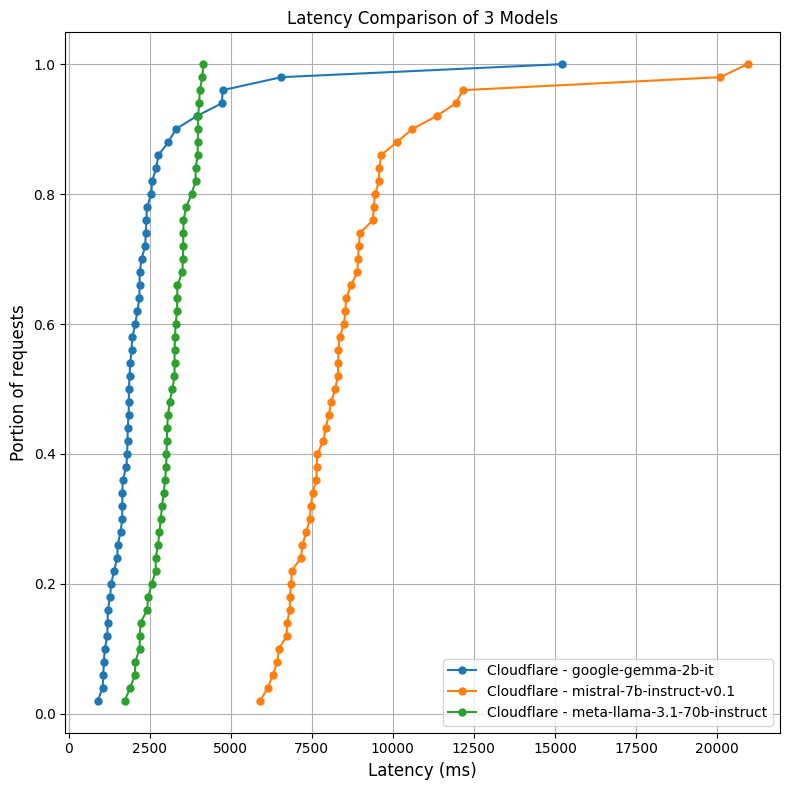

In [35]:
b.plot_metrics(b.totaltime)

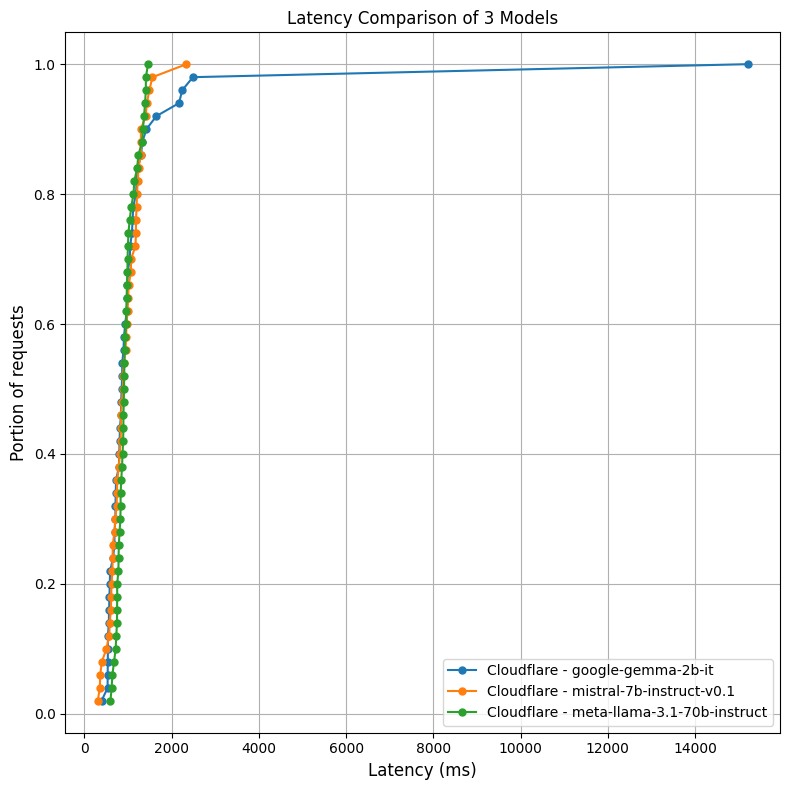

In [36]:
b.plot_metrics(b.timetofirsttoken)

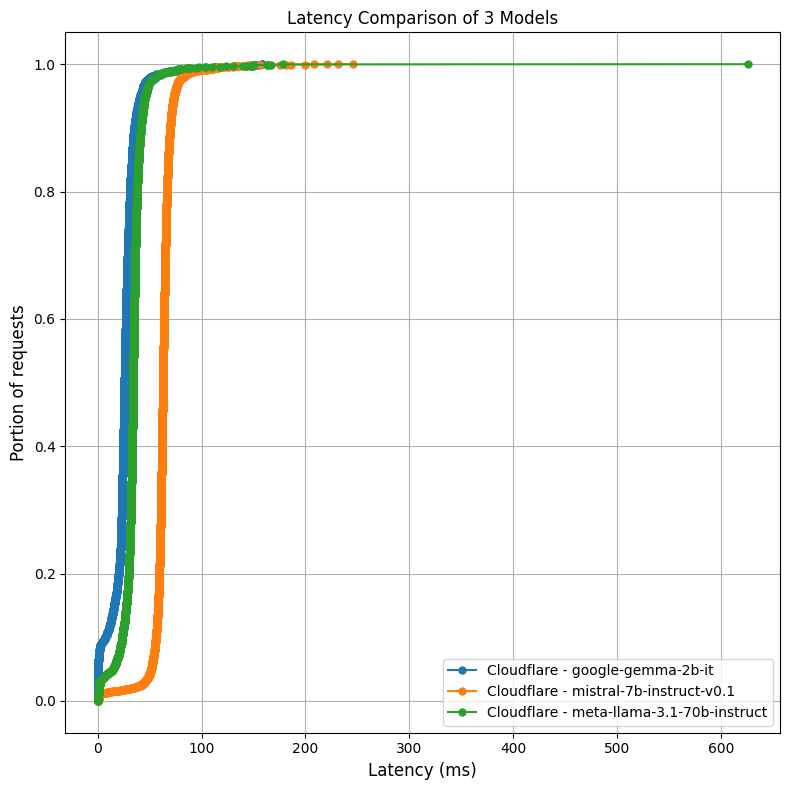

In [37]:
b.plot_metrics(b.timebetweentokens)

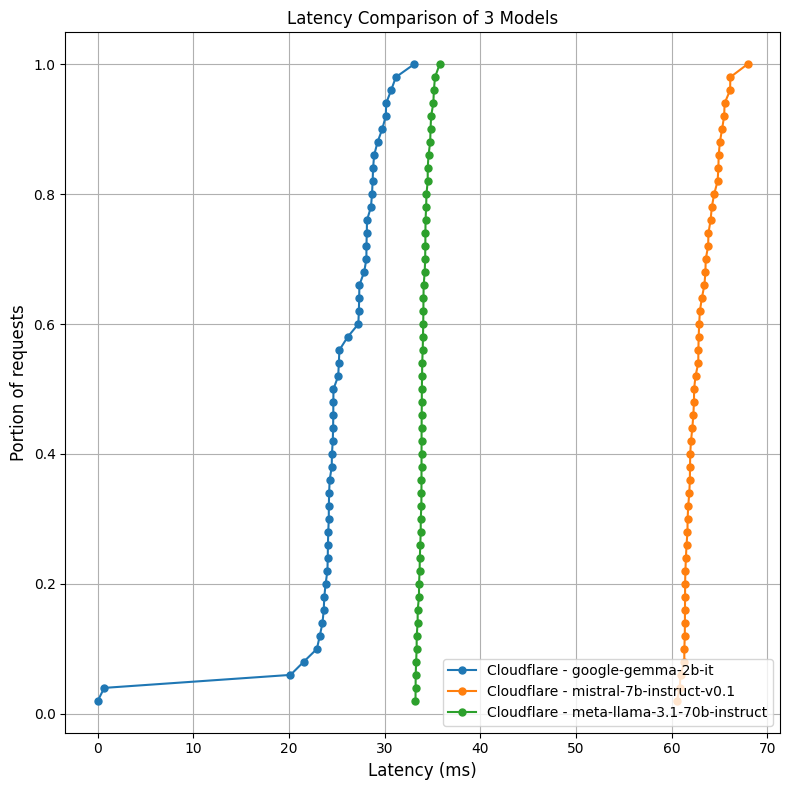

In [38]:
b.plot_metrics(b.timebetweentokens_median)

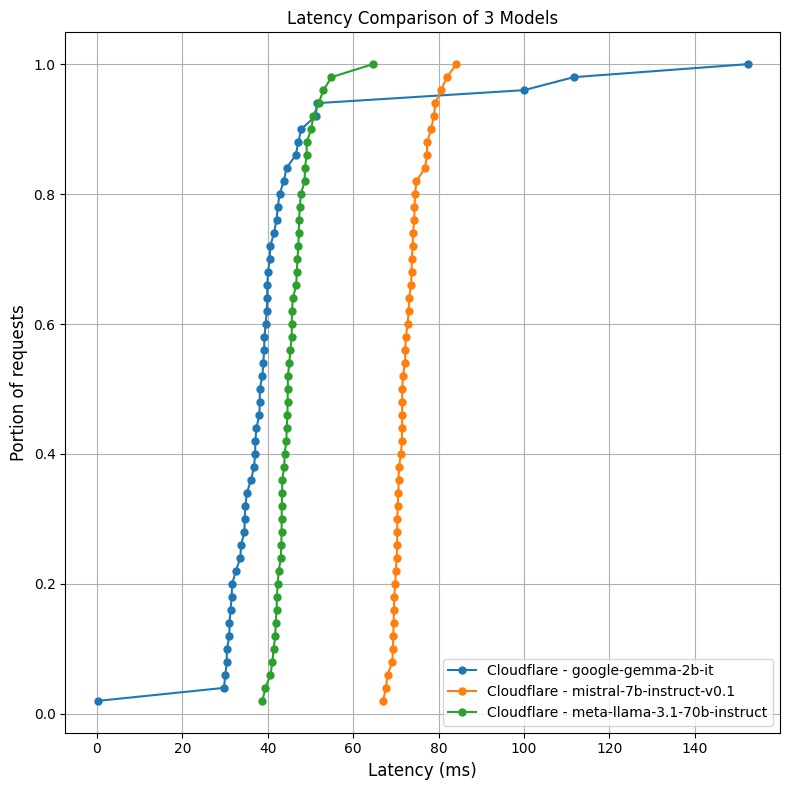

In [39]:
b.plot_metrics(b.timebetweentokens_p95)